In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

2


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['nb_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'nb_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testconv", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
reload (rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [27]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('3003nb_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (195594, 2) (49698, 2)
train/valid # (195594, 2) (49698, 2)


rand split across time
train has 195594 records out of 372221 records
valid has 49698 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1528
0
26 18 (1, 18)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)


{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1528 [..............................] - ETA: 48:18 - loss: 3.1972 - total_loss: 3.1972 - reg_loss: 5.4530

   5/1528 [..............................] - ETA: 9:54 - loss: 2.3787 - total_loss: 2.3787 - reg_loss: 5.3009 

  10/1528 [..............................] - ETA: 5:05 - loss: 2.2924 - total_loss: 2.2924 - reg_loss: 5.7179

  15/1528 [..............................] - ETA: 3:29 - loss: 2.2135 - total_loss: 2.2135 - reg_loss: 4.0790

  20/1528 [..............................] - ETA: 2:40 - loss: 2.1798 - total_loss: 2.1798 - reg_loss: 3.2322

  24/1528 [..............................] - ETA: 2:16 - loss: 2.1584 - total_loss: 2.1584 - reg_loss: 2.8337

  29/1528 [..............................] - ETA: 1:55 - loss: 2.1385 - total_loss: 2.1385 - reg_loss: 2.4704

  33/1528 [..............................] - ETA: 1:43 - loss: 2.1269 - total_loss: 2.1269 - reg_loss: 2.2415

  38/1528 [..............................] - ETA: 1:32 - loss: 2.1156 - total_loss: 2.1156 - reg_loss: 2.0103

  42/1528 [..............................] - ETA: 1:25 - loss: 2.1076 - total_loss: 2.1076 - reg_loss: 1.8688

  46/1528 [..............................] - ETA: 1:19 - loss: 2.1019 - total_loss: 2.1019 - reg_loss: 1.7457

  50/1528 [..............................] - ETA: 1:14 - loss: 2.0978 - total_loss: 2.0978 - reg_loss: 1.6444

  54/1528 [>.............................] - ETA: 1:10 - loss: 2.0920 - total_loss: 2.0920 - reg_loss: 1.5526

  58/1528 [>.............................] - ETA: 1:06 - loss: 2.0891 - total_loss: 2.0891 - reg_loss: 1.4761

  62/1528 [>.............................] - ETA: 1:03 - loss: 2.0868 - total_loss: 2.0868 - reg_loss: 1.4076

  66/1528 [>.............................] - ETA: 1:00 - loss: 2.0845 - total_loss: 2.0845 - reg_loss: 1.3424

  70/1528 [>.............................] - ETA: 57s - loss: 2.0811 - total_loss: 2.0811 - reg_loss: 1.2892 

  75/1528 [>.............................] - ETA: 55s - loss: 2.0788 - total_loss: 2.0788 - reg_loss: 1.2265

  79/1528 [>.............................] - ETA: 53s - loss: 2.0768 - total_loss: 2.0768 - reg_loss: 1.1839

  83/1528 [>.............................] - ETA: 51s - loss: 2.0749 - total_loss: 2.0749 - reg_loss: 1.1446

  87/1528 [>.............................] - ETA: 49s - loss: 2.0735 - total_loss: 2.0735 - reg_loss: 1.1087

  91/1528 [>.............................] - ETA: 48s - loss: 2.0709 - total_loss: 2.0709 - reg_loss: 1.0799

  95/1528 [>.............................] - ETA: 46s - loss: 2.0685 - total_loss: 2.0685 - reg_loss: 1.0543

  99/1528 [>.............................] - ETA: 45s - loss: 2.0680 - total_loss: 2.0680 - reg_loss: 1.0272

 103/1528 [=>............................] - ETA: 44s - loss: 2.0665 - total_loss: 2.0665 - reg_loss: 1.0040

 107/1528 [=>............................] - ETA: 43s - loss: 2.0663 - total_loss: 2.0663 - reg_loss: 0.9808

 111/1528 [=>............................] - ETA: 42s - loss: 2.0653 - total_loss: 2.0653 - reg_loss: 0.9605

 115/1528 [=>............................] - ETA: 41s - loss: 2.0637 - total_loss: 2.0637 - reg_loss: 0.9420

 119/1528 [=>............................] - ETA: 40s - loss: 2.0625 - total_loss: 2.0625 - reg_loss: 0.9235

 124/1528 [=>............................] - ETA: 39s - loss: 2.0613 - total_loss: 2.0613 - reg_loss: 0.9008

 128/1528 [=>............................] - ETA: 38s - loss: 2.0600 - total_loss: 2.0600 - reg_loss: 0.8843

 132/1528 [=>............................] - ETA: 37s - loss: 2.0590 - total_loss: 2.0590 - reg_loss: 0.8688

 136/1528 [=>............................] - ETA: 37s - loss: 2.0588 - total_loss: 2.0588 - reg_loss: 0.8525

 141/1528 [=>............................] - ETA: 36s - loss: 2.0583 - total_loss: 2.0583 - reg_loss: 0.8332

 145/1528 [=>............................] - ETA: 35s - loss: 2.0579 - total_loss: 2.0579 - reg_loss: 0.8198

 149/1528 [=>............................] - ETA: 35s - loss: 2.0573 - total_loss: 2.0573 - reg_loss: 0.8061

 153/1528 [==>...........................] - ETA: 34s - loss: 2.0571 - total_loss: 2.0571 - reg_loss: 0.7944

 158/1528 [==>...........................] - ETA: 34s - loss: 2.0567 - total_loss: 2.0567 - reg_loss: 0.7801

 162/1528 [==>...........................] - ETA: 33s - loss: 2.0562 - total_loss: 2.0562 - reg_loss: 0.7703

 166/1528 [==>...........................] - ETA: 33s - loss: 2.0557 - total_loss: 2.0557 - reg_loss: 0.7598

 170/1528 [==>...........................] - ETA: 32s - loss: 2.0555 - total_loss: 2.0555 - reg_loss: 0.7486

 174/1528 [==>...........................] - ETA: 32s - loss: 2.0546 - total_loss: 2.0546 - reg_loss: 0.7392

 178/1528 [==>...........................] - ETA: 31s - loss: 2.0543 - total_loss: 2.0543 - reg_loss: 0.7293

 182/1528 [==>...........................] - ETA: 31s - loss: 2.0538 - total_loss: 2.0538 - reg_loss: 0.7213

 186/1528 [==>...........................] - ETA: 30s - loss: 2.0531 - total_loss: 2.0531 - reg_loss: 0.7137

 190/1528 [==>...........................] - ETA: 30s - loss: 2.0528 - total_loss: 2.0528 - reg_loss: 0.7051

 194/1528 [==>...........................] - ETA: 30s - loss: 2.0526 - total_loss: 2.0526 - reg_loss: 0.6975

 198/1528 [==>...........................] - ETA: 29s - loss: 2.0522 - total_loss: 2.0522 - reg_loss: 0.6897

 202/1528 [==>...........................] - ETA: 29s - loss: 2.0517 - total_loss: 2.0517 - reg_loss: 0.6827

 206/1528 [===>..........................] - ETA: 29s - loss: 2.0515 - total_loss: 2.0515 - reg_loss: 0.6762

 210/1528 [===>..........................] - ETA: 28s - loss: 2.0511 - total_loss: 2.0511 - reg_loss: 0.6696

 215/1528 [===>..........................] - ETA: 28s - loss: 2.0509 - total_loss: 2.0509 - reg_loss: 0.6607

 220/1528 [===>..........................] - ETA: 28s - loss: 2.0503 - total_loss: 2.0503 - reg_loss: 0.6527

 224/1528 [===>..........................] - ETA: 27s - loss: 2.0501 - total_loss: 2.0501 - reg_loss: 0.6465

 228/1528 [===>..........................] - ETA: 27s - loss: 2.0499 - total_loss: 2.0499 - reg_loss: 0.6407

 232/1528 [===>..........................] - ETA: 27s - loss: 2.0497 - total_loss: 2.0497 - reg_loss: 0.6343

 236/1528 [===>..........................] - ETA: 27s - loss: 2.0496 - total_loss: 2.0496 - reg_loss: 0.6288

 240/1528 [===>..........................] - ETA: 26s - loss: 2.0493 - total_loss: 2.0493 - reg_loss: 0.6239

 244/1528 [===>..........................] - ETA: 26s - loss: 2.0489 - total_loss: 2.0489 - reg_loss: 0.6188

 248/1528 [===>..........................] - ETA: 26s - loss: 2.0486 - total_loss: 2.0486 - reg_loss: 0.6145

 252/1528 [===>..........................] - ETA: 26s - loss: 2.0483 - total_loss: 2.0483 - reg_loss: 0.6102

 256/1528 [====>.........................] - ETA: 25s - loss: 2.0484 - total_loss: 2.0484 - reg_loss: 0.6050

 260/1528 [====>.........................] - ETA: 25s - loss: 2.0487 - total_loss: 2.0487 - reg_loss: 0.6007

 264/1528 [====>.........................] - ETA: 25s - loss: 2.0484 - total_loss: 2.0484 - reg_loss: 0.5955

 268/1528 [====>.........................] - ETA: 25s - loss: 2.0483 - total_loss: 2.0483 - reg_loss: 0.5915

 272/1528 [====>.........................] - ETA: 25s - loss: 2.0483 - total_loss: 2.0483 - reg_loss: 0.5876

 277/1528 [====>.........................] - ETA: 24s - loss: 2.0484 - total_loss: 2.0484 - reg_loss: 0.5829

 281/1528 [====>.........................] - ETA: 24s - loss: 2.0483 - total_loss: 2.0483 - reg_loss: 0.5793

 285/1528 [====>.........................] - ETA: 24s - loss: 2.0481 - total_loss: 2.0481 - reg_loss: 0.5750

 289/1528 [====>.........................] - ETA: 24s - loss: 2.0480 - total_loss: 2.0480 - reg_loss: 0.5717

 293/1528 [====>.........................] - ETA: 24s - loss: 2.0479 - total_loss: 2.0479 - reg_loss: 0.5689

 297/1528 [====>.........................] - ETA: 23s - loss: 2.0479 - total_loss: 2.0479 - reg_loss: 0.5653

 301/1528 [====>.........................] - ETA: 23s - loss: 2.0478 - total_loss: 2.0478 - reg_loss: 0.5620

 305/1528 [====>.........................] - ETA: 23s - loss: 2.0475 - total_loss: 2.0475 - reg_loss: 0.5592

 309/1528 [=====>........................] - ETA: 23s - loss: 2.0473 - total_loss: 2.0473 - reg_loss: 0.5561

 313/1528 [=====>........................] - ETA: 23s - loss: 2.0471 - total_loss: 2.0471 - reg_loss: 0.5530

 317/1528 [=====>........................] - ETA: 23s - loss: 2.0469 - total_loss: 2.0469 - reg_loss: 0.5499

 321/1528 [=====>........................] - ETA: 22s - loss: 2.0468 - total_loss: 2.0468 - reg_loss: 0.5468

 325/1528 [=====>........................] - ETA: 22s - loss: 2.0465 - total_loss: 2.0465 - reg_loss: 0.5438

 329/1528 [=====>........................] - ETA: 22s - loss: 2.0462 - total_loss: 2.0462 - reg_loss: 0.5408

 333/1528 [=====>........................] - ETA: 22s - loss: 2.0461 - total_loss: 2.0461 - reg_loss: 0.5386

 338/1528 [=====>........................] - ETA: 22s - loss: 2.0459 - total_loss: 2.0459 - reg_loss: 0.5353

 342/1528 [=====>........................] - ETA: 22s - loss: 2.0458 - total_loss: 2.0458 - reg_loss: 0.5322

 347/1528 [=====>........................] - ETA: 21s - loss: 2.0457 - total_loss: 2.0457 - reg_loss: 0.5284

 351/1528 [=====>........................] - ETA: 21s - loss: 2.0454 - total_loss: 2.0454 - reg_loss: 0.5260

 355/1528 [=====>........................] - ETA: 21s - loss: 2.0453 - total_loss: 2.0453 - reg_loss: 0.5235

 359/1528 [======>.......................] - ETA: 21s - loss: 2.0453 - total_loss: 2.0453 - reg_loss: 0.5206

 363/1528 [======>.......................] - ETA: 21s - loss: 2.0453 - total_loss: 2.0453 - reg_loss: 0.5184

 367/1528 [======>.......................] - ETA: 21s - loss: 2.0452 - total_loss: 2.0452 - reg_loss: 0.5159

 371/1528 [======>.......................] - ETA: 21s - loss: 2.0448 - total_loss: 2.0448 - reg_loss: 0.5139

 375/1528 [======>.......................] - ETA: 20s - loss: 2.0446 - total_loss: 2.0446 - reg_loss: 0.5117

 379/1528 [======>.......................] - ETA: 20s - loss: 2.0445 - total_loss: 2.0445 - reg_loss: 0.5094

 383/1528 [======>.......................] - ETA: 20s - loss: 2.0443 - total_loss: 2.0443 - reg_loss: 0.5071

 387/1528 [======>.......................] - ETA: 20s - loss: 2.0443 - total_loss: 2.0443 - reg_loss: 0.5049

 391/1528 [======>.......................] - ETA: 20s - loss: 2.0442 - total_loss: 2.0442 - reg_loss: 0.5035

 395/1528 [======>.......................] - ETA: 20s - loss: 2.0440 - total_loss: 2.0440 - reg_loss: 0.5018

 399/1528 [======>.......................] - ETA: 20s - loss: 2.0438 - total_loss: 2.0438 - reg_loss: 0.5002

 403/1528 [======>.......................] - ETA: 20s - loss: 2.0436 - total_loss: 2.0436 - reg_loss: 0.4986

 407/1528 [======>.......................] - ETA: 20s - loss: 2.0435 - total_loss: 2.0435 - reg_loss: 0.4967

 410/1528 [=======>......................] - ETA: 19s - loss: 2.0435 - total_loss: 2.0435 - reg_loss: 0.4953

 414/1528 [=======>......................] - ETA: 19s - loss: 2.0433 - total_loss: 2.0433 - reg_loss: 0.4934

 418/1528 [=======>......................] - ETA: 19s - loss: 2.0433 - total_loss: 2.0433 - reg_loss: 0.4915

 422/1528 [=======>......................] - ETA: 19s - loss: 2.0432 - total_loss: 2.0432 - reg_loss: 0.4904

 426/1528 [=======>......................] - ETA: 19s - loss: 2.0429 - total_loss: 2.0429 - reg_loss: 0.4884

 430/1528 [=======>......................] - ETA: 19s - loss: 2.0428 - total_loss: 2.0428 - reg_loss: 0.4867

 435/1528 [=======>......................] - ETA: 19s - loss: 2.0428 - total_loss: 2.0428 - reg_loss: 0.4849

 439/1528 [=======>......................] - ETA: 19s - loss: 2.0426 - total_loss: 2.0426 - reg_loss: 0.4828

 443/1528 [=======>......................] - ETA: 19s - loss: 2.0424 - total_loss: 2.0424 - reg_loss: 0.4811

 447/1528 [=======>......................] - ETA: 18s - loss: 2.0424 - total_loss: 2.0424 - reg_loss: 0.4799

 451/1528 [=======>......................] - ETA: 18s - loss: 2.0423 - total_loss: 2.0423 - reg_loss: 0.4785

 455/1528 [=======>......................] - ETA: 18s - loss: 2.0422 - total_loss: 2.0422 - reg_loss: 0.4770

 458/1528 [=======>......................] - ETA: 18s - loss: 2.0421 - total_loss: 2.0421 - reg_loss: 0.4759

 462/1528 [========>.....................] - ETA: 18s - loss: 2.0422 - total_loss: 2.0422 - reg_loss: 0.4741

 466/1528 [========>.....................] - ETA: 18s - loss: 2.0420 - total_loss: 2.0420 - reg_loss: 0.4731

 470/1528 [========>.....................] - ETA: 18s - loss: 2.0420 - total_loss: 2.0420 - reg_loss: 0.4719

 474/1528 [========>.....................] - ETA: 18s - loss: 2.0418 - total_loss: 2.0418 - reg_loss: 0.4702

 478/1528 [========>.....................] - ETA: 18s - loss: 2.0418 - total_loss: 2.0418 - reg_loss: 0.4689

 482/1528 [========>.....................] - ETA: 18s - loss: 2.0416 - total_loss: 2.0416 - reg_loss: 0.4672

 486/1528 [========>.....................] - ETA: 17s - loss: 2.0415 - total_loss: 2.0415 - reg_loss: 0.4661

 490/1528 [========>.....................] - ETA: 17s - loss: 2.0414 - total_loss: 2.0414 - reg_loss: 0.4650

 494/1528 [========>.....................] - ETA: 17s - loss: 2.0414 - total_loss: 2.0414 - reg_loss: 0.4637

 498/1528 [========>.....................] - ETA: 17s - loss: 2.0414 - total_loss: 2.0414 - reg_loss: 0.4623

 502/1528 [========>.....................] - ETA: 17s - loss: 2.0414 - total_loss: 2.0414 - reg_loss: 0.4608

 506/1528 [========>.....................] - ETA: 17s - loss: 2.0414 - total_loss: 2.0414 - reg_loss: 0.4594

 510/1528 [=========>....................] - ETA: 17s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.4582

 514/1528 [=========>....................] - ETA: 17s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.4570

 518/1528 [=========>....................] - ETA: 17s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.4558

 522/1528 [=========>....................] - ETA: 17s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.4543

 526/1528 [=========>....................] - ETA: 16s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.4535

 530/1528 [=========>....................] - ETA: 16s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.4523

 534/1528 [=========>....................] - ETA: 16s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.4510

 538/1528 [=========>....................] - ETA: 16s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.4499

 542/1528 [=========>....................] - ETA: 16s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.4486

 546/1528 [=========>....................] - ETA: 16s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.4479

 550/1528 [=========>....................] - ETA: 16s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.4468

 554/1528 [=========>....................] - ETA: 16s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.4459

 558/1528 [=========>....................] - ETA: 16s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.4448

 562/1528 [==========>...................] - ETA: 16s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.4438

 566/1528 [==========>...................] - ETA: 16s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.4427

 570/1528 [==========>...................] - ETA: 15s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.4418

 574/1528 [==========>...................] - ETA: 15s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.4406

 578/1528 [==========>...................] - ETA: 15s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.4397

 582/1528 [==========>...................] - ETA: 15s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.4387

 586/1528 [==========>...................] - ETA: 15s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.4377

 590/1528 [==========>...................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.4371

 594/1528 [==========>...................] - ETA: 15s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.4360

 598/1528 [==========>...................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.4352

 602/1528 [==========>...................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.4341

 606/1528 [==========>...................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.4332

 610/1528 [==========>...................] - ETA: 15s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.4324

 614/1528 [===========>..................] - ETA: 15s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.4314

 618/1528 [===========>..................] - ETA: 14s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.4303

 622/1528 [===========>..................] - ETA: 14s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.4296

 626/1528 [===========>..................] - ETA: 14s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.4286

 630/1528 [===========>..................] - ETA: 14s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.4276

 634/1528 [===========>..................] - ETA: 14s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.4266

 638/1528 [===========>..................] - ETA: 14s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.4260

 642/1528 [===========>..................] - ETA: 14s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.4253

 646/1528 [===========>..................] - ETA: 14s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.4245

 650/1528 [===========>..................] - ETA: 14s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.4237

 654/1528 [===========>..................] - ETA: 14s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.4226

 658/1528 [===========>..................] - ETA: 14s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.4217

 662/1528 [===========>..................] - ETA: 14s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.4209

 666/1528 [============>.................] - ETA: 14s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.4199

 670/1528 [============>.................] - ETA: 13s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.4191

 674/1528 [============>.................] - ETA: 13s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.4182

 679/1528 [============>.................] - ETA: 13s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.4176

 683/1528 [============>.................] - ETA: 13s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.4170

 688/1528 [============>.................] - ETA: 13s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.4162

 692/1528 [============>.................] - ETA: 13s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.4156

 696/1528 [============>.................] - ETA: 13s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.4147

 701/1528 [============>.................] - ETA: 13s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.4137

 705/1528 [============>.................] - ETA: 13s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.4132

 709/1528 [============>.................] - ETA: 13s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.4123

 714/1528 [=============>................] - ETA: 13s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.4114

 718/1528 [=============>................] - ETA: 13s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.4106

 722/1528 [=============>................] - ETA: 12s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.4101

 726/1528 [=============>................] - ETA: 12s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.4095

 730/1528 [=============>................] - ETA: 12s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.4088

 734/1528 [=============>................] - ETA: 12s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.4082

 738/1528 [=============>................] - ETA: 12s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.4077

 742/1528 [=============>................] - ETA: 12s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.4071

 746/1528 [=============>................] - ETA: 12s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.4065

 751/1528 [=============>................] - ETA: 12s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.4058

 755/1528 [=============>................] - ETA: 12s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.4053

 759/1528 [=============>................] - ETA: 12s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.4047

 763/1528 [=============>................] - ETA: 12s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.4041

 767/1528 [==============>...............] - ETA: 12s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.4038

 771/1528 [==============>...............] - ETA: 12s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.4032

 775/1528 [==============>...............] - ETA: 11s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.4027

 779/1528 [==============>...............] - ETA: 11s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.4022

 783/1528 [==============>...............] - ETA: 11s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.4014

 787/1528 [==============>...............] - ETA: 11s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.4009

 791/1528 [==============>...............] - ETA: 11s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.4004

 795/1528 [==============>...............] - ETA: 11s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.3997

 799/1528 [==============>...............] - ETA: 11s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.3992

 803/1528 [==============>...............] - ETA: 11s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.3985

 807/1528 [==============>...............] - ETA: 11s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.3980

 811/1528 [==============>...............] - ETA: 11s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.3974

 815/1528 [===============>..............] - ETA: 11s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.3970

 819/1528 [===============>..............] - ETA: 11s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.3965

 823/1528 [===============>..............] - ETA: 11s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.3963

 827/1528 [===============>..............] - ETA: 11s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.3959

 831/1528 [===============>..............] - ETA: 10s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.3953

 835/1528 [===============>..............] - ETA: 10s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.3948

 839/1528 [===============>..............] - ETA: 10s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.3944

 843/1528 [===============>..............] - ETA: 10s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.3939

 847/1528 [===============>..............] - ETA: 10s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.3934

 851/1528 [===============>..............] - ETA: 10s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.3932

 855/1528 [===============>..............] - ETA: 10s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.3929

 859/1528 [===============>..............] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.3926

 863/1528 [===============>..............] - ETA: 10s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.3920

 867/1528 [================>.............] - ETA: 10s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.3918

 871/1528 [================>.............] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.3913

 875/1528 [================>.............] - ETA: 10s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.3910

 879/1528 [================>.............] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.3906

 883/1528 [================>.............] - ETA: 10s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.3903

 887/1528 [================>.............] - ETA: 10s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.3897

 891/1528 [================>.............] - ETA: 9s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.3892 

 895/1528 [================>.............] - ETA: 9s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.3887

 899/1528 [================>.............] - ETA: 9s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.3881

 903/1528 [================>.............] - ETA: 9s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.3877

 907/1528 [================>.............] - ETA: 9s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.3873

 911/1528 [================>.............] - ETA: 9s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.3870

 915/1528 [================>.............] - ETA: 9s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.3868

 919/1528 [=================>............] - ETA: 9s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.3862

 923/1528 [=================>............] - ETA: 9s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.3857

 927/1528 [=================>............] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.3851

 931/1528 [=================>............] - ETA: 9s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.3846

 935/1528 [=================>............] - ETA: 9s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.3840

 939/1528 [=================>............] - ETA: 9s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.3834

 943/1528 [=================>............] - ETA: 9s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.3831

 947/1528 [=================>............] - ETA: 9s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.3825

 951/1528 [=================>............] - ETA: 8s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.3821

 955/1528 [=================>............] - ETA: 8s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.3818

 959/1528 [=================>............] - ETA: 8s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.3814

 964/1528 [=================>............] - ETA: 8s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.3808

 968/1528 [==================>...........] - ETA: 8s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.3804

 972/1528 [==================>...........] - ETA: 8s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.3799

 976/1528 [==================>...........] - ETA: 8s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.3795

 981/1528 [==================>...........] - ETA: 8s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.3793

 985/1528 [==================>...........] - ETA: 8s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.3790

 989/1528 [==================>...........] - ETA: 8s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.3786

 994/1528 [==================>...........] - ETA: 8s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.3781

 998/1528 [==================>...........] - ETA: 8s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.3777

1002/1528 [==================>...........] - ETA: 8s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.3774

1006/1528 [==================>...........] - ETA: 8s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.3771

1010/1528 [==================>...........] - ETA: 7s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.3768

1014/1528 [==================>...........] - ETA: 7s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.3766

1018/1528 [==================>...........] - ETA: 7s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.3761

1022/1528 [===================>..........] - ETA: 7s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.3757

1026/1528 [===================>..........] - ETA: 7s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.3754

1030/1528 [===================>..........] - ETA: 7s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.3749

1034/1528 [===================>..........] - ETA: 7s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.3745

1039/1528 [===================>..........] - ETA: 7s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.3741

1043/1528 [===================>..........] - ETA: 7s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.3739

1047/1528 [===================>..........] - ETA: 7s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.3736

1051/1528 [===================>..........] - ETA: 7s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.3733

1055/1528 [===================>..........] - ETA: 7s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.3729

1059/1528 [===================>..........] - ETA: 7s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.3726

1063/1528 [===================>..........] - ETA: 7s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.3722

1067/1528 [===================>..........] - ETA: 7s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.3718

1071/1528 [====================>.........] - ETA: 7s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.3715

1075/1528 [====================>.........] - ETA: 6s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.3711

1079/1528 [====================>.........] - ETA: 6s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.3707

1083/1528 [====================>.........] - ETA: 6s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.3706

1087/1528 [====================>.........] - ETA: 6s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.3704

1091/1528 [====================>.........] - ETA: 6s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.3700

1095/1528 [====================>.........] - ETA: 6s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.3698

1099/1528 [====================>.........] - ETA: 6s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.3695

1103/1528 [====================>.........] - ETA: 6s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.3691

1107/1528 [====================>.........] - ETA: 6s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.3688

1111/1528 [====================>.........] - ETA: 6s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.3684

1115/1528 [====================>.........] - ETA: 6s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.3681

1119/1528 [====================>.........] - ETA: 6s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.3678

1124/1528 [=====================>........] - ETA: 6s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.3676

1128/1528 [=====================>........] - ETA: 6s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.3674

1132/1528 [=====================>........] - ETA: 6s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.3671

1136/1528 [=====================>........] - ETA: 5s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.3669

1140/1528 [=====================>........] - ETA: 5s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.3665

1144/1528 [=====================>........] - ETA: 5s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.3660

1148/1528 [=====================>........] - ETA: 5s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.3654

1153/1528 [=====================>........] - ETA: 5s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.3651

1157/1528 [=====================>........] - ETA: 5s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.3647

1161/1528 [=====================>........] - ETA: 5s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.3644

1165/1528 [=====================>........] - ETA: 5s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.3641

1169/1528 [=====================>........] - ETA: 5s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.3639

1173/1528 [======================>.......] - ETA: 5s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.3636

1177/1528 [======================>.......] - ETA: 5s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.3635

1181/1528 [======================>.......] - ETA: 5s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.3632

1185/1528 [======================>.......] - ETA: 5s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.3629

1189/1528 [======================>.......] - ETA: 5s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.3627

1193/1528 [======================>.......] - ETA: 5s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.3625

1197/1528 [======================>.......] - ETA: 5s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.3622

1201/1528 [======================>.......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3620

1205/1528 [======================>.......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3619

1209/1528 [======================>.......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3617

1213/1528 [======================>.......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3615

1217/1528 [======================>.......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3613

1221/1528 [======================>.......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3610

1225/1528 [=======================>......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3607

1229/1528 [=======================>......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3605

1233/1528 [=======================>......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3603

1237/1528 [=======================>......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3601

1241/1528 [=======================>......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3598

1245/1528 [=======================>......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3596

1249/1528 [=======================>......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3594

1253/1528 [=======================>......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3591

1257/1528 [=======================>......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3589

1261/1528 [=======================>......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3586

1266/1528 [=======================>......] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3582

1270/1528 [=======================>......] - ETA: 3s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.3581

1274/1528 [========================>.....] - ETA: 3s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.3577

1278/1528 [========================>.....] - ETA: 3s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.3576

1282/1528 [========================>.....] - ETA: 3s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.3576

1286/1528 [========================>.....] - ETA: 3s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.3574

1290/1528 [========================>.....] - ETA: 3s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.3574

1294/1528 [========================>.....] - ETA: 3s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.3571

1298/1528 [========================>.....] - ETA: 3s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.3569

1302/1528 [========================>.....] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3565

1306/1528 [========================>.....] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3562

1310/1528 [========================>.....] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3558

1314/1528 [========================>.....] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3557

1318/1528 [========================>.....] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.3554

1322/1528 [========================>.....] - ETA: 3s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.3553

1326/1528 [=========================>....] - ETA: 3s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.3551

1330/1528 [=========================>....] - ETA: 2s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.3549

1334/1528 [=========================>....] - ETA: 2s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.3547

1338/1528 [=========================>....] - ETA: 2s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.3544

1342/1528 [=========================>....] - ETA: 2s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.3541

1346/1528 [=========================>....] - ETA: 2s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.3541

1350/1528 [=========================>....] - ETA: 2s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3539

1354/1528 [=========================>....] - ETA: 2s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3536

1358/1528 [=========================>....] - ETA: 2s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3535

1362/1528 [=========================>....] - ETA: 2s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3532

1366/1528 [=========================>....] - ETA: 2s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3530

1370/1528 [=========================>....] - ETA: 2s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3529

1374/1528 [=========================>....] - ETA: 2s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3526

1378/1528 [==========================>...] - ETA: 2s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3524

1383/1528 [==========================>...] - ETA: 2s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3522

1387/1528 [==========================>...] - ETA: 2s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3520

1391/1528 [==========================>...] - ETA: 2s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3518

1395/1528 [==========================>...] - ETA: 1s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3516

1399/1528 [==========================>...] - ETA: 1s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3515

1403/1528 [==========================>...] - ETA: 1s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3513

1407/1528 [==========================>...] - ETA: 1s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3511

1411/1528 [==========================>...] - ETA: 1s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3508

1415/1528 [==========================>...] - ETA: 1s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3506

1419/1528 [==========================>...] - ETA: 1s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3505

1423/1528 [==========================>...] - ETA: 1s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3503

1427/1528 [===========================>..] - ETA: 1s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3502

1431/1528 [===========================>..] - ETA: 1s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3499

1435/1528 [===========================>..] - ETA: 1s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3497

1439/1528 [===========================>..] - ETA: 1s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3495

1443/1528 [===========================>..] - ETA: 1s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3494

1447/1528 [===========================>..] - ETA: 1s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3492

1451/1528 [===========================>..] - ETA: 1s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3490

1455/1528 [===========================>..] - ETA: 1s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3488

1459/1528 [===========================>..] - ETA: 1s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3486

1463/1528 [===========================>..] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3485

1467/1528 [===========================>..] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3484

1471/1528 [===========================>..] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3482

1475/1528 [===========================>..] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3480

1479/1528 [============================>.] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3478

1483/1528 [============================>.] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3475

1487/1528 [============================>.] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3475

1491/1528 [============================>.] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3472

1495/1528 [============================>.] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3470

1499/1528 [============================>.] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3468

1503/1528 [============================>.] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3466

1507/1528 [============================>.] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3464

1511/1528 [============================>.] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3462

1515/1528 [============================>.] - ETA: 0s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3460

1519/1528 [============================>.] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3459

1523/1528 [============================>.] - ETA: 0s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.3457

1527/1528 [============================>.] - ETA: 0s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3455

Epoch 00001: saving model to testconv/model_adam.001.h5
1528/1528 [==============================] - 25s 16ms/step - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.3454 - val_loss: 2.0264 - val_total_loss: 2.0264 - val_reg_loss: 0.2856


Epoch 2/100
   1/1528 [..............................] - ETA: 21s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2159

   5/1528 [..............................] - ETA: 21s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2598

   9/1528 [..............................] - ETA: 21s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2790

  13/1528 [..............................] - ETA: 20s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2924

  17/1528 [..............................] - ETA: 21s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2986

  21/1528 [..............................] - ETA: 20s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2845

  25/1528 [..............................] - ETA: 20s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2855

  29/1528 [..............................] - ETA: 20s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2852

  33/1528 [..............................] - ETA: 20s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2891

  37/1528 [..............................] - ETA: 20s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2838

  41/1528 [..............................] - ETA: 19s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2869

  45/1528 [..............................] - ETA: 20s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2824

  49/1528 [..............................] - ETA: 19s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2798

  53/1528 [>.............................] - ETA: 19s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2780

  57/1528 [>.............................] - ETA: 19s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2780

  62/1528 [>.............................] - ETA: 19s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2778

  66/1528 [>.............................] - ETA: 19s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2767

  70/1528 [>.............................] - ETA: 19s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2772

  75/1528 [>.............................] - ETA: 19s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2770

  79/1528 [>.............................] - ETA: 19s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2785

  83/1528 [>.............................] - ETA: 19s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2775

  87/1528 [>.............................] - ETA: 19s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2745

  91/1528 [>.............................] - ETA: 19s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.2741

  95/1528 [>.............................] - ETA: 19s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2730

  99/1528 [>.............................] - ETA: 19s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2719

 103/1528 [=>............................] - ETA: 19s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2716

 107/1528 [=>............................] - ETA: 19s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2722

 111/1528 [=>............................] - ETA: 18s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2716

 115/1528 [=>............................] - ETA: 18s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2732

 119/1528 [=>............................] - ETA: 18s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2727

 123/1528 [=>............................] - ETA: 18s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2750

 127/1528 [=>............................] - ETA: 18s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2764

 131/1528 [=>............................] - ETA: 18s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2792

 135/1528 [=>............................] - ETA: 18s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2813

 139/1528 [=>............................] - ETA: 18s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2811

 143/1528 [=>............................] - ETA: 18s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2814

 147/1528 [=>............................] - ETA: 18s - loss: 2.0334 - total_loss: 2.0334 - reg_loss: 0.2800

 151/1528 [=>............................] - ETA: 18s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2808

 155/1528 [==>...........................] - ETA: 18s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2805

 159/1528 [==>...........................] - ETA: 18s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2810

 163/1528 [==>...........................] - ETA: 18s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2818

 167/1528 [==>...........................] - ETA: 18s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2811

 171/1528 [==>...........................] - ETA: 18s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2824

 175/1528 [==>...........................] - ETA: 18s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2822

 179/1528 [==>...........................] - ETA: 18s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2824

 183/1528 [==>...........................] - ETA: 18s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2821

 187/1528 [==>...........................] - ETA: 18s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2818

 191/1528 [==>...........................] - ETA: 17s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2811

 195/1528 [==>...........................] - ETA: 17s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2808

 200/1528 [==>...........................] - ETA: 17s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2803

 204/1528 [===>..........................] - ETA: 17s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2798

 208/1528 [===>..........................] - ETA: 17s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2794

 212/1528 [===>..........................] - ETA: 17s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2792

 216/1528 [===>..........................] - ETA: 17s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2792

 220/1528 [===>..........................] - ETA: 17s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2797

 224/1528 [===>..........................] - ETA: 17s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2796

 228/1528 [===>..........................] - ETA: 17s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2784

 232/1528 [===>..........................] - ETA: 17s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2790

 236/1528 [===>..........................] - ETA: 17s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2787

 240/1528 [===>..........................] - ETA: 17s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2793

 244/1528 [===>..........................] - ETA: 17s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2789

 248/1528 [===>..........................] - ETA: 17s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2793

 252/1528 [===>..........................] - ETA: 17s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2786

 256/1528 [====>.........................] - ETA: 17s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2783

 260/1528 [====>.........................] - ETA: 17s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2779

 264/1528 [====>.........................] - ETA: 16s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2775

 268/1528 [====>.........................] - ETA: 16s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2776

 272/1528 [====>.........................] - ETA: 16s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2771

 276/1528 [====>.........................] - ETA: 16s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2771

 280/1528 [====>.........................] - ETA: 16s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2773

 284/1528 [====>.........................] - ETA: 16s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2773

 288/1528 [====>.........................] - ETA: 16s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2773

 292/1528 [====>.........................] - ETA: 16s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2775

 296/1528 [====>.........................] - ETA: 16s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2771

 300/1528 [====>.........................] - ETA: 16s - loss: 2.0334 - total_loss: 2.0334 - reg_loss: 0.2774

 304/1528 [====>.........................] - ETA: 16s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2779

 308/1528 [=====>........................] - ETA: 16s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2775

 312/1528 [=====>........................] - ETA: 16s - loss: 2.0334 - total_loss: 2.0334 - reg_loss: 0.2781

 317/1528 [=====>........................] - ETA: 16s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2777

 321/1528 [=====>........................] - ETA: 16s - loss: 2.0334 - total_loss: 2.0334 - reg_loss: 0.2775

 325/1528 [=====>........................] - ETA: 16s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2777

 329/1528 [=====>........................] - ETA: 16s - loss: 2.0334 - total_loss: 2.0334 - reg_loss: 0.2774

 333/1528 [=====>........................] - ETA: 16s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2770

 337/1528 [=====>........................] - ETA: 16s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2764

 341/1528 [=====>........................] - ETA: 15s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2765

 345/1528 [=====>........................] - ETA: 15s - loss: 2.0334 - total_loss: 2.0334 - reg_loss: 0.2766

 349/1528 [=====>........................] - ETA: 15s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2765

 353/1528 [=====>........................] - ETA: 15s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2760

 357/1528 [======>.......................] - ETA: 15s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2758

 361/1528 [======>.......................] - ETA: 15s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2762

 365/1528 [======>.......................] - ETA: 15s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2759

 369/1528 [======>.......................] - ETA: 15s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2759

 373/1528 [======>.......................] - ETA: 15s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2757

 377/1528 [======>.......................] - ETA: 15s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2756

 381/1528 [======>.......................] - ETA: 15s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2756

 385/1528 [======>.......................] - ETA: 15s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2750

 389/1528 [======>.......................] - ETA: 15s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2751

 393/1528 [======>.......................] - ETA: 15s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2752

 397/1528 [======>.......................] - ETA: 15s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2754

 401/1528 [======>.......................] - ETA: 15s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2753

 405/1528 [======>.......................] - ETA: 15s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2754

 409/1528 [=======>......................] - ETA: 15s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2754

 413/1528 [=======>......................] - ETA: 15s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2753

 417/1528 [=======>......................] - ETA: 14s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2755

 421/1528 [=======>......................] - ETA: 14s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2755

 425/1528 [=======>......................] - ETA: 14s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2755

 429/1528 [=======>......................] - ETA: 14s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2755

 433/1528 [=======>......................] - ETA: 14s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2755

 437/1528 [=======>......................] - ETA: 14s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2757

 441/1528 [=======>......................] - ETA: 14s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2756

 445/1528 [=======>......................] - ETA: 14s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2759

 449/1528 [=======>......................] - ETA: 14s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2757

 453/1528 [=======>......................] - ETA: 14s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2756

 457/1528 [=======>......................] - ETA: 14s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2755

 461/1528 [========>.....................] - ETA: 14s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2753

 465/1528 [========>.....................] - ETA: 14s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2753

 469/1528 [========>.....................] - ETA: 14s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2751

 473/1528 [========>.....................] - ETA: 14s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2750

 477/1528 [========>.....................] - ETA: 14s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2750

 481/1528 [========>.....................] - ETA: 14s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2749

 485/1528 [========>.....................] - ETA: 14s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2748

 489/1528 [========>.....................] - ETA: 14s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2743

 493/1528 [========>.....................] - ETA: 14s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2742

 497/1528 [========>.....................] - ETA: 14s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2742

 501/1528 [========>.....................] - ETA: 13s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2743

 505/1528 [========>.....................] - ETA: 13s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2742

 509/1528 [========>.....................] - ETA: 13s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2741

 513/1528 [=========>....................] - ETA: 13s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2742

 517/1528 [=========>....................] - ETA: 13s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2739

 521/1528 [=========>....................] - ETA: 13s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2738

 525/1528 [=========>....................] - ETA: 13s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2739

 529/1528 [=========>....................] - ETA: 13s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2737

 533/1528 [=========>....................] - ETA: 13s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2740

 537/1528 [=========>....................] - ETA: 13s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2740

 541/1528 [=========>....................] - ETA: 13s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2740

 545/1528 [=========>....................] - ETA: 13s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2740

 549/1528 [=========>....................] - ETA: 13s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2739

 553/1528 [=========>....................] - ETA: 13s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2739

 558/1528 [=========>....................] - ETA: 13s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2740

 562/1528 [==========>...................] - ETA: 13s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2742

 566/1528 [==========>...................] - ETA: 13s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2743

 570/1528 [==========>...................] - ETA: 13s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2744

 574/1528 [==========>...................] - ETA: 12s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2743

 578/1528 [==========>...................] - ETA: 12s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2742

 582/1528 [==========>...................] - ETA: 12s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2742

 586/1528 [==========>...................] - ETA: 12s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2746

 590/1528 [==========>...................] - ETA: 12s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2749

 594/1528 [==========>...................] - ETA: 12s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2748

 598/1528 [==========>...................] - ETA: 12s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2751

 602/1528 [==========>...................] - ETA: 12s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2753

 606/1528 [==========>...................] - ETA: 12s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2754

 610/1528 [==========>...................] - ETA: 12s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2753

 614/1528 [===========>..................] - ETA: 12s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2756

 618/1528 [===========>..................] - ETA: 12s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2758

 622/1528 [===========>..................] - ETA: 12s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2757

 626/1528 [===========>..................] - ETA: 12s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2757

 630/1528 [===========>..................] - ETA: 12s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2756

 634/1528 [===========>..................] - ETA: 12s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2756

 638/1528 [===========>..................] - ETA: 12s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2756

 642/1528 [===========>..................] - ETA: 12s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2753

 646/1528 [===========>..................] - ETA: 12s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2752

 650/1528 [===========>..................] - ETA: 11s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2753

 654/1528 [===========>..................] - ETA: 11s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2754

 658/1528 [===========>..................] - ETA: 11s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2754

 662/1528 [===========>..................] - ETA: 11s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2754

 666/1528 [============>.................] - ETA: 11s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2756

 670/1528 [============>.................] - ETA: 11s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2755

 674/1528 [============>.................] - ETA: 11s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2753

 678/1528 [============>.................] - ETA: 11s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2752

 682/1528 [============>.................] - ETA: 11s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2755

 686/1528 [============>.................] - ETA: 11s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2759

 690/1528 [============>.................] - ETA: 11s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2757

 694/1528 [============>.................] - ETA: 11s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2757

 698/1528 [============>.................] - ETA: 11s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2756

 703/1528 [============>.................] - ETA: 11s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2758

 707/1528 [============>.................] - ETA: 11s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2759

 711/1528 [============>.................] - ETA: 11s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2761

 715/1528 [=============>................] - ETA: 11s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2762

 719/1528 [=============>................] - ETA: 11s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2762

 723/1528 [=============>................] - ETA: 10s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2761

 727/1528 [=============>................] - ETA: 10s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2759

 731/1528 [=============>................] - ETA: 10s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2758

 735/1528 [=============>................] - ETA: 10s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2756

 739/1528 [=============>................] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2758

 743/1528 [=============>................] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2759

 747/1528 [=============>................] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2761

 751/1528 [=============>................] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2764

 755/1528 [=============>................] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2764

 759/1528 [=============>................] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2765

 763/1528 [=============>................] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2764

 767/1528 [==============>...............] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2763

 771/1528 [==============>...............] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2761

 775/1528 [==============>...............] - ETA: 10s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2759

 779/1528 [==============>...............] - ETA: 10s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2758

 783/1528 [==============>...............] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2756

 787/1528 [==============>...............] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2757

 791/1528 [==============>...............] - ETA: 10s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2757

 795/1528 [==============>...............] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2754 

 799/1528 [==============>...............] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2755

 803/1528 [==============>...............] - ETA: 9s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2758

 807/1528 [==============>...............] - ETA: 9s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2760

 811/1528 [==============>...............] - ETA: 9s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2761

 815/1528 [===============>..............] - ETA: 9s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2760

 819/1528 [===============>..............] - ETA: 9s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2761

 823/1528 [===============>..............] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2762

 827/1528 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2764

 831/1528 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

 835/1528 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2765

 839/1528 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2766

 843/1528 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2768

 847/1528 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2767

 851/1528 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2766

 855/1528 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2766

 859/1528 [===============>..............] - ETA: 9s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2768

 863/1528 [===============>..............] - ETA: 9s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2766

 867/1528 [================>.............] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2768

 871/1528 [================>.............] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2769

 875/1528 [================>.............] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2770

 879/1528 [================>.............] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2772

 883/1528 [================>.............] - ETA: 8s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2774

 887/1528 [================>.............] - ETA: 8s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2774

 891/1528 [================>.............] - ETA: 8s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2773

 895/1528 [================>.............] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2773

 899/1528 [================>.............] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2772

 903/1528 [================>.............] - ETA: 8s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2770

 907/1528 [================>.............] - ETA: 8s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2771

 911/1528 [================>.............] - ETA: 8s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2770

 915/1528 [================>.............] - ETA: 8s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2769

 919/1528 [=================>............] - ETA: 8s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2770

 923/1528 [=================>............] - ETA: 8s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2769

 927/1528 [=================>............] - ETA: 8s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2767

 931/1528 [=================>............] - ETA: 8s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2765

 935/1528 [=================>............] - ETA: 8s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2765

 939/1528 [=================>............] - ETA: 8s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2765

 943/1528 [=================>............] - ETA: 7s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2766

 947/1528 [=================>............] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2765

 951/1528 [=================>............] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2764

 955/1528 [=================>............] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2763

 959/1528 [=================>............] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2763

 963/1528 [=================>............] - ETA: 7s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2765

 967/1528 [=================>............] - ETA: 7s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2767

 972/1528 [==================>...........] - ETA: 7s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2770

 977/1528 [==================>...........] - ETA: 7s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2772

 981/1528 [==================>...........] - ETA: 7s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2773

 985/1528 [==================>...........] - ETA: 7s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2773

 989/1528 [==================>...........] - ETA: 7s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2772

 993/1528 [==================>...........] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2773

 997/1528 [==================>...........] - ETA: 7s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2773

1001/1528 [==================>...........] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2771

1005/1528 [==================>...........] - ETA: 7s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2772

1009/1528 [==================>...........] - ETA: 7s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2771

1013/1528 [==================>...........] - ETA: 7s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2771

1017/1528 [==================>...........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2770

1022/1528 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2771

1026/1528 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2771

1030/1528 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2771

1034/1528 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2771

1038/1528 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2772

1042/1528 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2773

1046/1528 [===================>..........] - ETA: 6s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2773

1050/1528 [===================>..........] - ETA: 6s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2774

1055/1528 [===================>..........] - ETA: 6s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2773

1059/1528 [===================>..........] - ETA: 6s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2774

1063/1528 [===================>..........] - ETA: 6s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2774

1067/1528 [===================>..........] - ETA: 6s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2774

1071/1528 [====================>.........] - ETA: 6s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2774

1075/1528 [====================>.........] - ETA: 6s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2773

1079/1528 [====================>.........] - ETA: 6s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2773

1083/1528 [====================>.........] - ETA: 6s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2774

1087/1528 [====================>.........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2774

1091/1528 [====================>.........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2773

1095/1528 [====================>.........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2773

1099/1528 [====================>.........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2772

1103/1528 [====================>.........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2772

1108/1528 [====================>.........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2773

1112/1528 [====================>.........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2772

1117/1528 [====================>.........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2770

1122/1528 [=====================>........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2770

1127/1528 [=====================>........] - ETA: 5s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2770

1131/1528 [=====================>........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2770

1135/1528 [=====================>........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2770

1139/1528 [=====================>........] - ETA: 5s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2769

1143/1528 [=====================>........] - ETA: 5s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2768

1148/1528 [=====================>........] - ETA: 5s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2769

1152/1528 [=====================>........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2769

1156/1528 [=====================>........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2768

1160/1528 [=====================>........] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2768

1164/1528 [=====================>........] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2767

1168/1528 [=====================>........] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2767

1172/1528 [======================>.......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2768

1176/1528 [======================>.......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2767

1180/1528 [======================>.......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2768

1184/1528 [======================>.......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2768

1188/1528 [======================>.......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2767

1192/1528 [======================>.......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2767

1197/1528 [======================>.......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2768

1202/1528 [======================>.......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2768

1206/1528 [======================>.......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2766

1210/1528 [======================>.......] - ETA: 4s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2766

1214/1528 [======================>.......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2765

1219/1528 [======================>.......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2765

1223/1528 [=======================>......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2767

1227/1528 [=======================>......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2766

1231/1528 [=======================>......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2766

1235/1528 [=======================>......] - ETA: 3s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2765

1239/1528 [=======================>......] - ETA: 3s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2764

1243/1528 [=======================>......] - ETA: 3s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2763

1247/1528 [=======================>......] - ETA: 3s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2763

1251/1528 [=======================>......] - ETA: 3s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2764

1255/1528 [=======================>......] - ETA: 3s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2762

1259/1528 [=======================>......] - ETA: 3s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

1263/1528 [=======================>......] - ETA: 3s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

1267/1528 [=======================>......] - ETA: 3s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

1271/1528 [=======================>......] - ETA: 3s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

1275/1528 [========================>.....] - ETA: 3s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2764

1279/1528 [========================>.....] - ETA: 3s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2764

1283/1528 [========================>.....] - ETA: 3s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2765

1287/1528 [========================>.....] - ETA: 3s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2764

1291/1528 [========================>.....] - ETA: 3s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2765

1295/1528 [========================>.....] - ETA: 3s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2765

1299/1528 [========================>.....] - ETA: 3s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2766

1303/1528 [========================>.....] - ETA: 3s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2766

1307/1528 [========================>.....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2766

1311/1528 [========================>.....] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2767

1315/1528 [========================>.....] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2768

1319/1528 [========================>.....] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2767

1323/1528 [========================>.....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2767

1327/1528 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2767

1331/1528 [=========================>....] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2767

1335/1528 [=========================>....] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2767

1339/1528 [=========================>....] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2767

1343/1528 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2766

1347/1528 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2767

1351/1528 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2765

1355/1528 [=========================>....] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2765

1359/1528 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2764

1363/1528 [=========================>....] - ETA: 2s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2765

1367/1528 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2764

1371/1528 [=========================>....] - ETA: 2s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

1375/1528 [=========================>....] - ETA: 2s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

1379/1528 [==========================>...] - ETA: 2s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2762

1383/1528 [==========================>...] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

1387/1528 [==========================>...] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2764

1391/1528 [==========================>...] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

1395/1528 [==========================>...] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

1399/1528 [==========================>...] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2764

1403/1528 [==========================>...] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

1407/1528 [==========================>...] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

1411/1528 [==========================>...] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

1415/1528 [==========================>...] - ETA: 1s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2763

1419/1528 [==========================>...] - ETA: 1s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2762

1423/1528 [==========================>...] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2762

1427/1528 [===========================>..] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2762

1432/1528 [===========================>..] - ETA: 1s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2763

1436/1528 [===========================>..] - ETA: 1s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2764

1440/1528 [===========================>..] - ETA: 1s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2763

1444/1528 [===========================>..] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2764

1448/1528 [===========================>..] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2765

1452/1528 [===========================>..] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2767

1456/1528 [===========================>..] - ETA: 0s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2768

1460/1528 [===========================>..] - ETA: 0s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2769

1464/1528 [===========================>..] - ETA: 0s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2769

1468/1528 [===========================>..] - ETA: 0s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2771

1472/1528 [===========================>..] - ETA: 0s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2771

1476/1528 [===========================>..] - ETA: 0s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2772

1480/1528 [============================>.] - ETA: 0s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2771

1484/1528 [============================>.] - ETA: 0s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2771

1488/1528 [============================>.] - ETA: 0s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2772

1492/1528 [============================>.] - ETA: 0s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2771

1496/1528 [============================>.] - ETA: 0s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2772

1500/1528 [============================>.] - ETA: 0s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2772

1504/1528 [============================>.] - ETA: 0s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2771

1508/1528 [============================>.] - ETA: 0s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2770

1512/1528 [============================>.] - ETA: 0s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2769

1516/1528 [============================>.] - ETA: 0s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2770

1520/1528 [============================>.] - ETA: 0s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2768

1524/1528 [============================>.] - ETA: 0s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2768

Epoch 00002: saving model to testconv/model_adam.002.h5
1528/1528 [==============================] - 23s 15ms/step - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2769 - val_loss: 2.0255 - val_total_loss: 2.0255 - val_reg_loss: 0.2732


Epoch 3/100
   1/1528 [..............................] - ETA: 24s - loss: 2.0221 - total_loss: 2.0221 - reg_loss: 0.3424

   5/1528 [..............................] - ETA: 21s - loss: 2.0198 - total_loss: 2.0198 - reg_loss: 0.2786

   9/1528 [..............................] - ETA: 20s - loss: 2.0180 - total_loss: 2.0180 - reg_loss: 0.2728

  13/1528 [..............................] - ETA: 20s - loss: 2.0181 - total_loss: 2.0181 - reg_loss: 0.2853

  17/1528 [..............................] - ETA: 20s - loss: 2.0188 - total_loss: 2.0188 - reg_loss: 0.2857

  21/1528 [..............................] - ETA: 20s - loss: 2.0218 - total_loss: 2.0218 - reg_loss: 0.2808

  25/1528 [..............................] - ETA: 20s - loss: 2.0227 - total_loss: 2.0227 - reg_loss: 0.2758

  29/1528 [..............................] - ETA: 20s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2781

  33/1528 [..............................] - ETA: 20s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2754

  37/1528 [..............................] - ETA: 20s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2736

  41/1528 [..............................] - ETA: 20s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2773

  45/1528 [..............................] - ETA: 20s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2750

  49/1528 [..............................] - ETA: 20s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2758

  53/1528 [>.............................] - ETA: 20s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2758

  57/1528 [>.............................] - ETA: 19s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2764

  61/1528 [>.............................] - ETA: 19s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2762

  65/1528 [>.............................] - ETA: 19s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2780

  69/1528 [>.............................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2775

  73/1528 [>.............................] - ETA: 19s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2772

  77/1528 [>.............................] - ETA: 19s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2749

  82/1528 [>.............................] - ETA: 19s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2741

  86/1528 [>.............................] - ETA: 19s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2763

  91/1528 [>.............................] - ETA: 19s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2764

  95/1528 [>.............................] - ETA: 19s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2751

 100/1528 [>.............................] - ETA: 18s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2759

 104/1528 [=>............................] - ETA: 18s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2749

 109/1528 [=>............................] - ETA: 18s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2742

 113/1528 [=>............................] - ETA: 18s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2745

 117/1528 [=>............................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2735

 121/1528 [=>............................] - ETA: 18s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2733

 125/1528 [=>............................] - ETA: 18s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2724

 129/1528 [=>............................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2730

 133/1528 [=>............................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2737

 137/1528 [=>............................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2728

 141/1528 [=>............................] - ETA: 18s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2717

 145/1528 [=>............................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2705

 149/1528 [=>............................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2708

 153/1528 [==>...........................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2710

 157/1528 [==>...........................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2721

 161/1528 [==>...........................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2723

 165/1528 [==>...........................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2725

 169/1528 [==>...........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2724

 173/1528 [==>...........................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2725

 177/1528 [==>...........................] - ETA: 18s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2717

 181/1528 [==>...........................] - ETA: 17s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2710

 185/1528 [==>...........................] - ETA: 17s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2707

 189/1528 [==>...........................] - ETA: 17s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2700

 193/1528 [==>...........................] - ETA: 17s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2692

 197/1528 [==>...........................] - ETA: 17s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2698

 201/1528 [==>...........................] - ETA: 17s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2701

 205/1528 [===>..........................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2698

 209/1528 [===>..........................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2693

 213/1528 [===>..........................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2695

 217/1528 [===>..........................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2695

 221/1528 [===>..........................] - ETA: 17s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2687

 225/1528 [===>..........................] - ETA: 17s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2686

 229/1528 [===>..........................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2684

 233/1528 [===>..........................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2686

 237/1528 [===>..........................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2681

 241/1528 [===>..........................] - ETA: 17s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2676

 245/1528 [===>..........................] - ETA: 17s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2682

 249/1528 [===>..........................] - ETA: 17s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2682

 253/1528 [===>..........................] - ETA: 17s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2679

 257/1528 [====>.........................] - ETA: 17s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2683

 261/1528 [====>.........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2681

 265/1528 [====>.........................] - ETA: 17s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2685

 269/1528 [====>.........................] - ETA: 17s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2684

 273/1528 [====>.........................] - ETA: 16s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2685

 277/1528 [====>.........................] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2683

 281/1528 [====>.........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2685

 285/1528 [====>.........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2679

 289/1528 [====>.........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2679

 293/1528 [====>.........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2681

 297/1528 [====>.........................] - ETA: 16s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2681

 301/1528 [====>.........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2677

 305/1528 [====>.........................] - ETA: 16s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2677

 309/1528 [=====>........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2680

 313/1528 [=====>........................] - ETA: 16s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2679

 317/1528 [=====>........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2682

 321/1528 [=====>........................] - ETA: 16s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2681

 325/1528 [=====>........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2678

 329/1528 [=====>........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2672

 333/1528 [=====>........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2666

 337/1528 [=====>........................] - ETA: 16s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2666

 341/1528 [=====>........................] - ETA: 16s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2667

 345/1528 [=====>........................] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2669

 349/1528 [=====>........................] - ETA: 15s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2667

 353/1528 [=====>........................] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2667

 358/1528 [======>.......................] - ETA: 15s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2665

 363/1528 [======>.......................] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2666

 367/1528 [======>.......................] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2669

 371/1528 [======>.......................] - ETA: 15s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2671

 375/1528 [======>.......................] - ETA: 15s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2670

 379/1528 [======>.......................] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2674

 383/1528 [======>.......................] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2673

 387/1528 [======>.......................] - ETA: 15s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2677

 391/1528 [======>.......................] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2675

 395/1528 [======>.......................] - ETA: 15s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2674

 400/1528 [======>.......................] - ETA: 15s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2679

 404/1528 [======>.......................] - ETA: 15s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2677

 408/1528 [=======>......................] - ETA: 15s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2677

 412/1528 [=======>......................] - ETA: 15s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2677

 416/1528 [=======>......................] - ETA: 15s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2678

 420/1528 [=======>......................] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2674

 424/1528 [=======>......................] - ETA: 14s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2672

 428/1528 [=======>......................] - ETA: 14s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2674

 432/1528 [=======>......................] - ETA: 14s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2673

 436/1528 [=======>......................] - ETA: 14s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2678

 440/1528 [=======>......................] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2681

 444/1528 [=======>......................] - ETA: 14s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2678

 448/1528 [=======>......................] - ETA: 14s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2681

 452/1528 [=======>......................] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2679

 456/1528 [=======>......................] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2674

 460/1528 [========>.....................] - ETA: 14s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2676

 464/1528 [========>.....................] - ETA: 14s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2677

 468/1528 [========>.....................] - ETA: 14s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2675

 472/1528 [========>.....................] - ETA: 14s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2674

 476/1528 [========>.....................] - ETA: 14s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2675

 480/1528 [========>.....................] - ETA: 14s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2673

 484/1528 [========>.....................] - ETA: 14s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2673

 488/1528 [========>.....................] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2669

 492/1528 [========>.....................] - ETA: 14s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2666

 496/1528 [========>.....................] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2665

 500/1528 [========>.....................] - ETA: 13s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2664

 504/1528 [========>.....................] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2664

 508/1528 [========>.....................] - ETA: 13s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2662

 512/1528 [=========>....................] - ETA: 13s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2663

 516/1528 [=========>....................] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2666

 520/1528 [=========>....................] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2666

 524/1528 [=========>....................] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2666

 528/1528 [=========>....................] - ETA: 13s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2667

 532/1528 [=========>....................] - ETA: 13s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2670

 536/1528 [=========>....................] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2668

 540/1528 [=========>....................] - ETA: 13s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2664

 544/1528 [=========>....................] - ETA: 13s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2664

 548/1528 [=========>....................] - ETA: 13s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2666

 552/1528 [=========>....................] - ETA: 13s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2664

 556/1528 [=========>....................] - ETA: 13s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2662

 560/1528 [=========>....................] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2659

 564/1528 [==========>...................] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2659

 568/1528 [==========>...................] - ETA: 13s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2658

 572/1528 [==========>...................] - ETA: 12s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2658

 576/1528 [==========>...................] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2660

 580/1528 [==========>...................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2658

 584/1528 [==========>...................] - ETA: 12s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2657

 588/1528 [==========>...................] - ETA: 12s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2656

 592/1528 [==========>...................] - ETA: 12s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2657

 597/1528 [==========>...................] - ETA: 12s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2656

 601/1528 [==========>...................] - ETA: 12s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2656

 605/1528 [==========>...................] - ETA: 12s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2658

 609/1528 [==========>...................] - ETA: 12s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2659

 613/1528 [===========>..................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2658

 617/1528 [===========>..................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2659

 621/1528 [===========>..................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2658

 625/1528 [===========>..................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2659

 629/1528 [===========>..................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2660

 633/1528 [===========>..................] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2663

 637/1528 [===========>..................] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2662

 641/1528 [===========>..................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2660

 645/1528 [===========>..................] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2662

 649/1528 [===========>..................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2663

 653/1528 [===========>..................] - ETA: 11s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2661

 657/1528 [===========>..................] - ETA: 11s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2663

 661/1528 [===========>..................] - ETA: 11s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2663

 665/1528 [============>.................] - ETA: 11s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2665

 669/1528 [============>.................] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2668

 673/1528 [============>.................] - ETA: 11s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2671

 677/1528 [============>.................] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2670

 681/1528 [============>.................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2669

 685/1528 [============>.................] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2668

 689/1528 [============>.................] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2669

 693/1528 [============>.................] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2671

 697/1528 [============>.................] - ETA: 11s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2672

 701/1528 [============>.................] - ETA: 11s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2674

 705/1528 [============>.................] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2672

 709/1528 [============>.................] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2671

 713/1528 [============>.................] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2672

 717/1528 [=============>................] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2672

 721/1528 [=============>................] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2671

 725/1528 [=============>................] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2671

 729/1528 [=============>................] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2671

 733/1528 [=============>................] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2671

 737/1528 [=============>................] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2671

 741/1528 [=============>................] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2672

 745/1528 [=============>................] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2671

 749/1528 [=============>................] - ETA: 10s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2668

 754/1528 [=============>................] - ETA: 10s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2669

 758/1528 [=============>................] - ETA: 10s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2670

 762/1528 [=============>................] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2669

 766/1528 [==============>...............] - ETA: 10s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2672

 770/1528 [==============>...............] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2673

 774/1528 [==============>...............] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2673

 778/1528 [==============>...............] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2673

 782/1528 [==============>...............] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2672

 786/1528 [==============>...............] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2674

 790/1528 [==============>...............] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2675

 794/1528 [==============>...............] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2672

 798/1528 [==============>...............] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2671 

 802/1528 [==============>...............] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2672

 806/1528 [==============>...............] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2673

 811/1528 [==============>...............] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2672

 816/1528 [===============>..............] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2671

 820/1528 [===============>..............] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2672

 824/1528 [===============>..............] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2674

 828/1528 [===============>..............] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2676

 832/1528 [===============>..............] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2675

 836/1528 [===============>..............] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2676

 840/1528 [===============>..............] - ETA: 9s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2676

 844/1528 [===============>..............] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2675

 848/1528 [===============>..............] - ETA: 9s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2676

 852/1528 [===============>..............] - ETA: 9s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2678

 856/1528 [===============>..............] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2679

 860/1528 [===============>..............] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2679

 864/1528 [===============>..............] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2678

 868/1528 [================>.............] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2682

 872/1528 [================>.............] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2682

 876/1528 [================>.............] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2683

 880/1528 [================>.............] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2682

 884/1528 [================>.............] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2682

 888/1528 [================>.............] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2683

 892/1528 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2686

 896/1528 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2686

 901/1528 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2686

 905/1528 [================>.............] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2685

 909/1528 [================>.............] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2683

 913/1528 [================>.............] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2682

 917/1528 [=================>............] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2681

 921/1528 [=================>............] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2682

 925/1528 [=================>............] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2682

 929/1528 [=================>............] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2686

 933/1528 [=================>............] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2685

 937/1528 [=================>............] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2682

 941/1528 [=================>............] - ETA: 7s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2682

 945/1528 [=================>............] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2682

 949/1528 [=================>............] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2680

 953/1528 [=================>............] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2681

 957/1528 [=================>............] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2680

 961/1528 [=================>............] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2680

 965/1528 [=================>............] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2679

 969/1528 [==================>...........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2679

 973/1528 [==================>...........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2678

 977/1528 [==================>...........] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2679

 981/1528 [==================>...........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2678

 985/1528 [==================>...........] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2679

 989/1528 [==================>...........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2678

 993/1528 [==================>...........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2679

 997/1528 [==================>...........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2678

1001/1528 [==================>...........] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2676

1005/1528 [==================>...........] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2676

1009/1528 [==================>...........] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2676

1013/1528 [==================>...........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2675

1017/1528 [==================>...........] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2674

1021/1528 [===================>..........] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2674

1025/1528 [===================>..........] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2673

1029/1528 [===================>..........] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2674

1033/1528 [===================>..........] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2674

1037/1528 [===================>..........] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2674

1041/1528 [===================>..........] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2673

1045/1528 [===================>..........] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2673

1049/1528 [===================>..........] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2674

1053/1528 [===================>..........] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2675

1057/1528 [===================>..........] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2674

1061/1528 [===================>..........] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2672

1065/1528 [===================>..........] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2671

1069/1528 [===================>..........] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2671

1073/1528 [====================>.........] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2671

1077/1528 [====================>.........] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2672

1081/1528 [====================>.........] - ETA: 6s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2672

1085/1528 [====================>.........] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2673

1089/1528 [====================>.........] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2674

1093/1528 [====================>.........] - ETA: 5s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2674

1097/1528 [====================>.........] - ETA: 5s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2674

1101/1528 [====================>.........] - ETA: 5s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2673

1105/1528 [====================>.........] - ETA: 5s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2673

1109/1528 [====================>.........] - ETA: 5s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2674

1113/1528 [====================>.........] - ETA: 5s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2674

1117/1528 [====================>.........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2675

1121/1528 [=====================>........] - ETA: 5s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2677

1125/1528 [=====================>........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2678

1129/1528 [=====================>........] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2679

1133/1528 [=====================>........] - ETA: 5s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2679

1137/1528 [=====================>........] - ETA: 5s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2679

1141/1528 [=====================>........] - ETA: 5s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2678

1145/1528 [=====================>........] - ETA: 5s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2678

1149/1528 [=====================>........] - ETA: 5s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2677

1153/1528 [=====================>........] - ETA: 5s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2678

1158/1528 [=====================>........] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2680

1162/1528 [=====================>........] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2678

1166/1528 [=====================>........] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2677

1170/1528 [=====================>........] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2675

1174/1528 [======================>.......] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2675

1178/1528 [======================>.......] - ETA: 4s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2676

1182/1528 [======================>.......] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2677

1186/1528 [======================>.......] - ETA: 4s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2677

1190/1528 [======================>.......] - ETA: 4s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2677

1195/1528 [======================>.......] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2677

1199/1528 [======================>.......] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2677

1203/1528 [======================>.......] - ETA: 4s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2678

1207/1528 [======================>.......] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2679

1211/1528 [======================>.......] - ETA: 4s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2680

1215/1528 [======================>.......] - ETA: 4s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2679

1220/1528 [======================>.......] - ETA: 4s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2679

1224/1528 [=======================>......] - ETA: 4s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2679

1228/1528 [=======================>......] - ETA: 4s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2678

1232/1528 [=======================>......] - ETA: 4s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2679

1236/1528 [=======================>......] - ETA: 3s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2678

1240/1528 [=======================>......] - ETA: 3s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2678

1244/1528 [=======================>......] - ETA: 3s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2678

1248/1528 [=======================>......] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2677

1252/1528 [=======================>......] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2677

1257/1528 [=======================>......] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2677

1261/1528 [=======================>......] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2675

1265/1528 [=======================>......] - ETA: 3s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2676

1269/1528 [=======================>......] - ETA: 3s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2676

1273/1528 [=======================>......] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2675

1277/1528 [========================>.....] - ETA: 3s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2674

1281/1528 [========================>.....] - ETA: 3s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2674

1285/1528 [========================>.....] - ETA: 3s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2675

1289/1528 [========================>.....] - ETA: 3s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2675

1293/1528 [========================>.....] - ETA: 3s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2675

1297/1528 [========================>.....] - ETA: 3s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2675

1301/1528 [========================>.....] - ETA: 3s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2674

1305/1528 [========================>.....] - ETA: 3s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2674

1309/1528 [========================>.....] - ETA: 2s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2675

1313/1528 [========================>.....] - ETA: 2s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2674

1317/1528 [========================>.....] - ETA: 2s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2675

1321/1528 [========================>.....] - ETA: 2s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2674

1325/1528 [=========================>....] - ETA: 2s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2673

1329/1528 [=========================>....] - ETA: 2s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2674

1333/1528 [=========================>....] - ETA: 2s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2675

1337/1528 [=========================>....] - ETA: 2s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2674

1341/1528 [=========================>....] - ETA: 2s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2675

1345/1528 [=========================>....] - ETA: 2s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2674

1349/1528 [=========================>....] - ETA: 2s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2674

1353/1528 [=========================>....] - ETA: 2s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2674

1357/1528 [=========================>....] - ETA: 2s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2673

1361/1528 [=========================>....] - ETA: 2s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2673

1365/1528 [=========================>....] - ETA: 2s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2673

1369/1528 [=========================>....] - ETA: 2s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2674

1373/1528 [=========================>....] - ETA: 2s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2675

1377/1528 [==========================>...] - ETA: 2s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2676

1381/1528 [==========================>...] - ETA: 2s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2674

1385/1528 [==========================>...] - ETA: 1s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2672

1389/1528 [==========================>...] - ETA: 1s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2671

1393/1528 [==========================>...] - ETA: 1s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2670

1397/1528 [==========================>...] - ETA: 1s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2671

1401/1528 [==========================>...] - ETA: 1s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2672

1405/1528 [==========================>...] - ETA: 1s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2672

1409/1528 [==========================>...] - ETA: 1s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2671

1413/1528 [==========================>...] - ETA: 1s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2670

1417/1528 [==========================>...] - ETA: 1s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2669

1421/1528 [==========================>...] - ETA: 1s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2668

1425/1528 [==========================>...] - ETA: 1s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2667

1429/1528 [===========================>..] - ETA: 1s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2667

1433/1528 [===========================>..] - ETA: 1s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2667

1437/1528 [===========================>..] - ETA: 1s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2666

1441/1528 [===========================>..] - ETA: 1s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2666

1445/1528 [===========================>..] - ETA: 1s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2666

1449/1528 [===========================>..] - ETA: 1s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2667

1453/1528 [===========================>..] - ETA: 1s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2667

1457/1528 [===========================>..] - ETA: 0s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2667

1461/1528 [===========================>..] - ETA: 0s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2667

1465/1528 [===========================>..] - ETA: 0s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2668

1469/1528 [===========================>..] - ETA: 0s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2668

1473/1528 [===========================>..] - ETA: 0s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2668

1477/1528 [===========================>..] - ETA: 0s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2668

1481/1528 [============================>.] - ETA: 0s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2668

1485/1528 [============================>.] - ETA: 0s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2669

1489/1528 [============================>.] - ETA: 0s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2668

1493/1528 [============================>.] - ETA: 0s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2670

1497/1528 [============================>.] - ETA: 0s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2670

1501/1528 [============================>.] - ETA: 0s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2669

1505/1528 [============================>.] - ETA: 0s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2669

1509/1528 [============================>.] - ETA: 0s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2670

1513/1528 [============================>.] - ETA: 0s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2670

1517/1528 [============================>.] - ETA: 0s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2669

1521/1528 [============================>.] - ETA: 0s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2668

1525/1528 [============================>.] - ETA: 0s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2668

Epoch 00003: saving model to testconv/model_adam.003.h5
1528/1528 [==============================] - 23s 15ms/step - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2667 - val_loss: 2.0257 - val_total_loss: 2.0257 - val_reg_loss: 0.2763


Epoch 4/100
   1/1528 [..............................] - ETA: 22s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2632

   5/1528 [..............................] - ETA: 20s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2754

   9/1528 [..............................] - ETA: 20s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2644

  13/1528 [..............................] - ETA: 20s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2576

  17/1528 [..............................] - ETA: 20s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2573

  21/1528 [..............................] - ETA: 20s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2541

  26/1528 [..............................] - ETA: 20s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2525

  30/1528 [..............................] - ETA: 20s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2499

  34/1528 [..............................] - ETA: 20s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2488

  38/1528 [..............................] - ETA: 20s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2511

  42/1528 [..............................] - ETA: 19s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2526

  46/1528 [..............................] - ETA: 20s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2548

  50/1528 [..............................] - ETA: 19s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2567

  54/1528 [>.............................] - ETA: 20s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2586

  58/1528 [>.............................] - ETA: 19s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2584

  62/1528 [>.............................] - ETA: 19s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2608

  66/1528 [>.............................] - ETA: 19s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2602

  70/1528 [>.............................] - ETA: 19s - loss: 2.0336 - total_loss: 2.0336 - reg_loss: 0.2619

  74/1528 [>.............................] - ETA: 19s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2632

  78/1528 [>.............................] - ETA: 19s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2627

  82/1528 [>.............................] - ETA: 19s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2627

  87/1528 [>.............................] - ETA: 19s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2641

  91/1528 [>.............................] - ETA: 19s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2635

  96/1528 [>.............................] - ETA: 19s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2630

 101/1528 [>.............................] - ETA: 18s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2624

 105/1528 [=>............................] - ETA: 18s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2616

 109/1528 [=>............................] - ETA: 18s - loss: 2.0337 - total_loss: 2.0337 - reg_loss: 0.2614

 113/1528 [=>............................] - ETA: 18s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2610

 117/1528 [=>............................] - ETA: 18s - loss: 2.0336 - total_loss: 2.0336 - reg_loss: 0.2597

 122/1528 [=>............................] - ETA: 18s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2596

 126/1528 [=>............................] - ETA: 18s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2599

 130/1528 [=>............................] - ETA: 18s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2601

 134/1528 [=>............................] - ETA: 18s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2607

 138/1528 [=>............................] - ETA: 18s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2601

 142/1528 [=>............................] - ETA: 18s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2594

 146/1528 [=>............................] - ETA: 18s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2600

 150/1528 [=>............................] - ETA: 18s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2604

 154/1528 [==>...........................] - ETA: 18s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2599

 158/1528 [==>...........................] - ETA: 18s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2589

 163/1528 [==>...........................] - ETA: 18s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2585

 167/1528 [==>...........................] - ETA: 18s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2583

 171/1528 [==>...........................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2584

 175/1528 [==>...........................] - ETA: 18s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2594

 179/1528 [==>...........................] - ETA: 17s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2597

 183/1528 [==>...........................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2596

 187/1528 [==>...........................] - ETA: 17s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2601

 191/1528 [==>...........................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2594

 195/1528 [==>...........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2595

 199/1528 [==>...........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2594

 203/1528 [==>...........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2595

 207/1528 [===>..........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2597

 211/1528 [===>..........................] - ETA: 17s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2596

 215/1528 [===>..........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2595

 219/1528 [===>..........................] - ETA: 17s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2596

 223/1528 [===>..........................] - ETA: 17s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2599

 227/1528 [===>..........................] - ETA: 17s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2595

 231/1528 [===>..........................] - ETA: 17s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2593

 235/1528 [===>..........................] - ETA: 17s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2602

 239/1528 [===>..........................] - ETA: 17s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2604

 243/1528 [===>..........................] - ETA: 17s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2605

 247/1528 [===>..........................] - ETA: 17s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2609

 251/1528 [===>..........................] - ETA: 17s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2605

 255/1528 [====>.........................] - ETA: 17s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2602

 259/1528 [====>.........................] - ETA: 17s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2611

 263/1528 [====>.........................] - ETA: 17s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2612

 268/1528 [====>.........................] - ETA: 17s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2600

 272/1528 [====>.........................] - ETA: 16s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2600

 276/1528 [====>.........................] - ETA: 16s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2599

 280/1528 [====>.........................] - ETA: 16s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2596

 284/1528 [====>.........................] - ETA: 16s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2599

 288/1528 [====>.........................] - ETA: 16s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2596

 292/1528 [====>.........................] - ETA: 16s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2597

 297/1528 [====>.........................] - ETA: 16s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2597

 302/1528 [====>.........................] - ETA: 16s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2600

 307/1528 [=====>........................] - ETA: 16s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2607

 312/1528 [=====>........................] - ETA: 16s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2619

 316/1528 [=====>........................] - ETA: 16s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2618

 320/1528 [=====>........................] - ETA: 16s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2617

 324/1528 [=====>........................] - ETA: 16s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2616

 329/1528 [=====>........................] - ETA: 16s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2619

 334/1528 [=====>........................] - ETA: 15s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2621

 338/1528 [=====>........................] - ETA: 15s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2619

 342/1528 [=====>........................] - ETA: 15s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2621

 346/1528 [=====>........................] - ETA: 15s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2620

 350/1528 [=====>........................] - ETA: 15s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2618

 354/1528 [=====>........................] - ETA: 15s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2617

 358/1528 [======>.......................] - ETA: 15s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2616

 362/1528 [======>.......................] - ETA: 15s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2613

 366/1528 [======>.......................] - ETA: 15s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2612

 370/1528 [======>.......................] - ETA: 15s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2616

 374/1528 [======>.......................] - ETA: 15s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2617

 378/1528 [======>.......................] - ETA: 15s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2619

 382/1528 [======>.......................] - ETA: 15s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2616

 387/1528 [======>.......................] - ETA: 15s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2618

 392/1528 [======>.......................] - ETA: 15s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2619

 397/1528 [======>.......................] - ETA: 15s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2616

 401/1528 [======>.......................] - ETA: 15s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2620

 406/1528 [======>.......................] - ETA: 14s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2621

 410/1528 [=======>......................] - ETA: 14s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2621

 414/1528 [=======>......................] - ETA: 14s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2625

 418/1528 [=======>......................] - ETA: 14s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2621

 422/1528 [=======>......................] - ETA: 14s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2623

 426/1528 [=======>......................] - ETA: 14s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2626

 430/1528 [=======>......................] - ETA: 14s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2629

 434/1528 [=======>......................] - ETA: 14s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2627

 438/1528 [=======>......................] - ETA: 14s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2626

 442/1528 [=======>......................] - ETA: 14s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2625

 446/1528 [=======>......................] - ETA: 14s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2628

 450/1528 [=======>......................] - ETA: 14s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2630

 454/1528 [=======>......................] - ETA: 14s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2629

 458/1528 [=======>......................] - ETA: 14s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2627

 463/1528 [========>.....................] - ETA: 14s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2627

 467/1528 [========>.....................] - ETA: 14s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2625

 472/1528 [========>.....................] - ETA: 14s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2625

 476/1528 [========>.....................] - ETA: 13s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2629

 480/1528 [========>.....................] - ETA: 13s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2625

 484/1528 [========>.....................] - ETA: 13s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2624

 488/1528 [========>.....................] - ETA: 13s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2625

 493/1528 [========>.....................] - ETA: 13s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2622

 497/1528 [========>.....................] - ETA: 13s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2625

 501/1528 [========>.....................] - ETA: 13s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2626

 506/1528 [========>.....................] - ETA: 13s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2628

 510/1528 [=========>....................] - ETA: 13s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2631

 514/1528 [=========>....................] - ETA: 13s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2632

 518/1528 [=========>....................] - ETA: 13s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2631

 522/1528 [=========>....................] - ETA: 13s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2634

 526/1528 [=========>....................] - ETA: 13s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2633

 531/1528 [=========>....................] - ETA: 13s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2633

 535/1528 [=========>....................] - ETA: 13s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2629

 539/1528 [=========>....................] - ETA: 13s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2628

 543/1528 [=========>....................] - ETA: 13s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2626

 547/1528 [=========>....................] - ETA: 13s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2627

 551/1528 [=========>....................] - ETA: 13s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2627

 555/1528 [=========>....................] - ETA: 12s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2626

 559/1528 [=========>....................] - ETA: 12s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2625

 563/1528 [==========>...................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2625

 567/1528 [==========>...................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2628

 571/1528 [==========>...................] - ETA: 12s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2627

 575/1528 [==========>...................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2628

 579/1528 [==========>...................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2627

 583/1528 [==========>...................] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2627

 587/1528 [==========>...................] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2628

 591/1528 [==========>...................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2628

 595/1528 [==========>...................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2628

 599/1528 [==========>...................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2629

 603/1528 [==========>...................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2629

 607/1528 [==========>...................] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2631

 611/1528 [==========>...................] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2632

 615/1528 [===========>..................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2633

 619/1528 [===========>..................] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2634

 623/1528 [===========>..................] - ETA: 12s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2637

 627/1528 [===========>..................] - ETA: 12s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2637

 631/1528 [===========>..................] - ETA: 12s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2636

 635/1528 [===========>..................] - ETA: 11s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2635

 639/1528 [===========>..................] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2635

 643/1528 [===========>..................] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2637

 647/1528 [===========>..................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2635

 651/1528 [===========>..................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2638

 655/1528 [===========>..................] - ETA: 11s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2637

 659/1528 [===========>..................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2636

 663/1528 [============>.................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2639

 667/1528 [============>.................] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2638

 671/1528 [============>.................] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2637

 675/1528 [============>.................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2638

 679/1528 [============>.................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2639

 683/1528 [============>.................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2639

 687/1528 [============>.................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2638

 691/1528 [============>.................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2635

 695/1528 [============>.................] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2637

 699/1528 [============>.................] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2636

 703/1528 [============>.................] - ETA: 11s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2637

 707/1528 [============>.................] - ETA: 11s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2636

 711/1528 [============>.................] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2636

 715/1528 [=============>................] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2635

 719/1528 [=============>................] - ETA: 10s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2634

 723/1528 [=============>................] - ETA: 10s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2633

 727/1528 [=============>................] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2633

 731/1528 [=============>................] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2634

 735/1528 [=============>................] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2633

 739/1528 [=============>................] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2634

 743/1528 [=============>................] - ETA: 10s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2635

 747/1528 [=============>................] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2638

 751/1528 [=============>................] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2639

 755/1528 [=============>................] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2639

 759/1528 [=============>................] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2638

 763/1528 [=============>................] - ETA: 10s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2637

 767/1528 [==============>...............] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2635

 771/1528 [==============>...............] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2634

 775/1528 [==============>...............] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2632

 779/1528 [==============>...............] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2631

 783/1528 [==============>...............] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2631

 787/1528 [==============>...............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2630 

 791/1528 [==============>...............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2629

 795/1528 [==============>...............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2629

 799/1528 [==============>...............] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2627

 803/1528 [==============>...............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2629

 807/1528 [==============>...............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2628

 811/1528 [==============>...............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2631

 815/1528 [===============>..............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2631

 819/1528 [===============>..............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2630

 823/1528 [===============>..............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2630

 827/1528 [===============>..............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2630

 831/1528 [===============>..............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2630

 836/1528 [===============>..............] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2630

 840/1528 [===============>..............] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2630

 844/1528 [===============>..............] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2628

 848/1528 [===============>..............] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2627

 852/1528 [===============>..............] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2627

 856/1528 [===============>..............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2628

 860/1528 [===============>..............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2630

 864/1528 [===============>..............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2630

 868/1528 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2630

 872/1528 [================>.............] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2630

 876/1528 [================>.............] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2629

 880/1528 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2630

 884/1528 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2629

 888/1528 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2630

 892/1528 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2628

 896/1528 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2629

 900/1528 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2630

 904/1528 [================>.............] - ETA: 8s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2632

 908/1528 [================>.............] - ETA: 8s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2633

 912/1528 [================>.............] - ETA: 8s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2633

 916/1528 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2631

 920/1528 [=================>............] - ETA: 8s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2632

 924/1528 [=================>............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2631

 928/1528 [=================>............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2631

 932/1528 [=================>............] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2631

 936/1528 [=================>............] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2630

 940/1528 [=================>............] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2630

 944/1528 [=================>............] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2631

 948/1528 [=================>............] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2629

 952/1528 [=================>............] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2631

 956/1528 [=================>............] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2632

 960/1528 [=================>............] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2633

 964/1528 [=================>............] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2634

 968/1528 [==================>...........] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2634

 972/1528 [==================>...........] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2633

 976/1528 [==================>...........] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2632

 980/1528 [==================>...........] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2632

 984/1528 [==================>...........] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2633

 988/1528 [==================>...........] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2632

 992/1528 [==================>...........] - ETA: 7s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2633

 996/1528 [==================>...........] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2632

1000/1528 [==================>...........] - ETA: 7s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2630

1004/1528 [==================>...........] - ETA: 7s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2631

1008/1528 [==================>...........] - ETA: 7s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2631

1012/1528 [==================>...........] - ETA: 6s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2632

1016/1528 [==================>...........] - ETA: 6s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2632

1020/1528 [===================>..........] - ETA: 6s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2633

1024/1528 [===================>..........] - ETA: 6s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2633

1028/1528 [===================>..........] - ETA: 6s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2632

1032/1528 [===================>..........] - ETA: 6s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2632

1036/1528 [===================>..........] - ETA: 6s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2631

1040/1528 [===================>..........] - ETA: 6s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2631

1044/1528 [===================>..........] - ETA: 6s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2630

1048/1528 [===================>..........] - ETA: 6s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2629

1052/1528 [===================>..........] - ETA: 6s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2630

1056/1528 [===================>..........] - ETA: 6s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2630

1060/1528 [===================>..........] - ETA: 6s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2630

1064/1528 [===================>..........] - ETA: 6s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2630

1068/1528 [===================>..........] - ETA: 6s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2629

1072/1528 [====================>.........] - ETA: 6s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2629

1076/1528 [====================>.........] - ETA: 6s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2630

1080/1528 [====================>.........] - ETA: 6s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2630

1084/1528 [====================>.........] - ETA: 6s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2629

1088/1528 [====================>.........] - ETA: 5s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2628

1092/1528 [====================>.........] - ETA: 5s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2628

1096/1528 [====================>.........] - ETA: 5s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2628

1100/1528 [====================>.........] - ETA: 5s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2628

1105/1528 [====================>.........] - ETA: 5s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2626

1109/1528 [====================>.........] - ETA: 5s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2625

1113/1528 [====================>.........] - ETA: 5s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2625

1117/1528 [====================>.........] - ETA: 5s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2625

1121/1528 [=====================>........] - ETA: 5s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2625

1125/1528 [=====================>........] - ETA: 5s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2625

1129/1528 [=====================>........] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2624

1133/1528 [=====================>........] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2624

1137/1528 [=====================>........] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2625

1141/1528 [=====================>........] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2626

1145/1528 [=====================>........] - ETA: 5s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2626

1149/1528 [=====================>........] - ETA: 5s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2626

1153/1528 [=====================>........] - ETA: 5s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2625

1157/1528 [=====================>........] - ETA: 5s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2624

1161/1528 [=====================>........] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2623

1165/1528 [=====================>........] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2625

1169/1528 [=====================>........] - ETA: 4s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2625

1173/1528 [======================>.......] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2626

1177/1528 [======================>.......] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2627

1181/1528 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2627

1185/1528 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2627

1189/1528 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2627

1193/1528 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2628

1197/1528 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2628

1201/1528 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2627

1205/1528 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2627

1209/1528 [======================>.......] - ETA: 4s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2627

1213/1528 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2627

1218/1528 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2627

1222/1528 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2627

1226/1528 [=======================>......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2629

1230/1528 [=======================>......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2629

1234/1528 [=======================>......] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2630

1238/1528 [=======================>......] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2630

1242/1528 [=======================>......] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2630

1246/1528 [=======================>......] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2629

1250/1528 [=======================>......] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2629

1254/1528 [=======================>......] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2629

1258/1528 [=======================>......] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2628

1262/1528 [=======================>......] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2629

1266/1528 [=======================>......] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2629

1270/1528 [=======================>......] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2629

1274/1528 [========================>.....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2628

1278/1528 [========================>.....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2627

1282/1528 [========================>.....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2627

1286/1528 [========================>.....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2627

1290/1528 [========================>.....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2626

1294/1528 [========================>.....] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2626

1298/1528 [========================>.....] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2625

1302/1528 [========================>.....] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2625

1306/1528 [========================>.....] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2625

1310/1528 [========================>.....] - ETA: 2s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2625

1314/1528 [========================>.....] - ETA: 2s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2625

1318/1528 [========================>.....] - ETA: 2s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2625

1322/1528 [========================>.....] - ETA: 2s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2624

1326/1528 [=========================>....] - ETA: 2s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2624

1331/1528 [=========================>....] - ETA: 2s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2623

1335/1528 [=========================>....] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2624

1339/1528 [=========================>....] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2623

1343/1528 [=========================>....] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2623

1347/1528 [=========================>....] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2623

1351/1528 [=========================>....] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2624

1355/1528 [=========================>....] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2624

1359/1528 [=========================>....] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2625

1363/1528 [=========================>....] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2624

1367/1528 [=========================>....] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2623

1371/1528 [=========================>....] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2623

1375/1528 [=========================>....] - ETA: 2s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2623

1379/1528 [==========================>...] - ETA: 2s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2622

1383/1528 [==========================>...] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2623

1387/1528 [==========================>...] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2624

1391/1528 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2623

1395/1528 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2623

1399/1528 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2622

1403/1528 [==========================>...] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2623

1407/1528 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2624

1411/1528 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2624

1415/1528 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2622

1419/1528 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2622

1423/1528 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2623

1427/1528 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2623

1431/1528 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2624

1435/1528 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2624

1439/1528 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2624

1443/1528 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2625

1447/1528 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2624

1451/1528 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2624

1455/1528 [===========================>..] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2625

1459/1528 [===========================>..] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2625

1463/1528 [===========================>..] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2625

1467/1528 [===========================>..] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2624

1471/1528 [===========================>..] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2625

1476/1528 [===========================>..] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2626

1480/1528 [============================>.] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2626

1484/1528 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2626

1488/1528 [============================>.] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2626

1492/1528 [============================>.] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2626

1496/1528 [============================>.] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2626

1500/1528 [============================>.] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2626

1504/1528 [============================>.] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2625

1508/1528 [============================>.] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2624

1512/1528 [============================>.] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2625

1516/1528 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2625

1520/1528 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2626

1524/1528 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2626

Epoch 00004: saving model to testconv/model_adam.004.h5
1528/1528 [==============================] - 23s 15ms/step - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2626 - val_loss: 2.0264 - val_total_loss: 2.0264 - val_reg_loss: 0.2845


Epoch 5/100
   1/1528 [..............................] - ETA: 20s - loss: 2.0560 - total_loss: 2.0560 - reg_loss: 0.1587

   5/1528 [..............................] - ETA: 22s - loss: 2.0443 - total_loss: 2.0443 - reg_loss: 0.2403

   9/1528 [..............................] - ETA: 20s - loss: 2.0424 - total_loss: 2.0424 - reg_loss: 0.2484

  13/1528 [..............................] - ETA: 20s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2550

  17/1528 [..............................] - ETA: 20s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2539

  21/1528 [..............................] - ETA: 20s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2498

  25/1528 [..............................] - ETA: 20s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2538

  29/1528 [..............................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2531

  33/1528 [..............................] - ETA: 20s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2512

  37/1528 [..............................] - ETA: 20s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2521

  41/1528 [..............................] - ETA: 20s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2550

  45/1528 [..............................] - ETA: 20s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2530

  50/1528 [..............................] - ETA: 19s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2542

  54/1528 [>.............................] - ETA: 19s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2545

  58/1528 [>.............................] - ETA: 19s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2545

  62/1528 [>.............................] - ETA: 19s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2540

  66/1528 [>.............................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2532

  70/1528 [>.............................] - ETA: 19s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2520

  74/1528 [>.............................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2523

  78/1528 [>.............................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2530

  82/1528 [>.............................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2530

  86/1528 [>.............................] - ETA: 19s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2548

  90/1528 [>.............................] - ETA: 19s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2545

  94/1528 [>.............................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2542

  98/1528 [>.............................] - ETA: 19s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2552

 102/1528 [=>............................] - ETA: 19s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2536

 106/1528 [=>............................] - ETA: 19s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2531

 110/1528 [=>............................] - ETA: 19s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2528

 114/1528 [=>............................] - ETA: 18s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2526

 118/1528 [=>............................] - ETA: 18s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2528

 122/1528 [=>............................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2537

 126/1528 [=>............................] - ETA: 18s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2542

 130/1528 [=>............................] - ETA: 18s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2554

 134/1528 [=>............................] - ETA: 18s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2546

 139/1528 [=>............................] - ETA: 18s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2537

 143/1528 [=>............................] - ETA: 18s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2527

 147/1528 [=>............................] - ETA: 18s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2517

 151/1528 [=>............................] - ETA: 18s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2526

 155/1528 [==>...........................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2526

 159/1528 [==>...........................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2530

 163/1528 [==>...........................] - ETA: 18s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2531

 167/1528 [==>...........................] - ETA: 18s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2538

 171/1528 [==>...........................] - ETA: 18s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2546

 175/1528 [==>...........................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2557

 179/1528 [==>...........................] - ETA: 18s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2554

 183/1528 [==>...........................] - ETA: 18s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2554

 187/1528 [==>...........................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2556

 191/1528 [==>...........................] - ETA: 17s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2556

 195/1528 [==>...........................] - ETA: 17s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2554

 199/1528 [==>...........................] - ETA: 17s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2545

 204/1528 [===>..........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2549

 208/1528 [===>..........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2550

 212/1528 [===>..........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2546

 217/1528 [===>..........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2559

 221/1528 [===>..........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2559

 225/1528 [===>..........................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2559

 229/1528 [===>..........................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2562

 233/1528 [===>..........................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2561

 237/1528 [===>..........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2558

 241/1528 [===>..........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2557

 245/1528 [===>..........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2553

 249/1528 [===>..........................] - ETA: 17s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2551

 253/1528 [===>..........................] - ETA: 16s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2551

 257/1528 [====>.........................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2552

 261/1528 [====>.........................] - ETA: 16s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2553

 266/1528 [====>.........................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2552

 271/1528 [====>.........................] - ETA: 16s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2551

 275/1528 [====>.........................] - ETA: 16s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2546

 279/1528 [====>.........................] - ETA: 16s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2545

 283/1528 [====>.........................] - ETA: 16s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2548

 287/1528 [====>.........................] - ETA: 16s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2553

 292/1528 [====>.........................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2560

 296/1528 [====>.........................] - ETA: 16s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2559

 300/1528 [====>.........................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2559

 304/1528 [====>.........................] - ETA: 16s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2555

 308/1528 [=====>........................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2553

 312/1528 [=====>........................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2556

 316/1528 [=====>........................] - ETA: 16s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2552

 320/1528 [=====>........................] - ETA: 16s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2556

 324/1528 [=====>........................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2554

 328/1528 [=====>........................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2554

 333/1528 [=====>........................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2552

 338/1528 [=====>........................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2554

 342/1528 [=====>........................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2555

 346/1528 [=====>........................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2558

 351/1528 [=====>........................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2557

 355/1528 [=====>........................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2554

 359/1528 [======>.......................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2552

 363/1528 [======>.......................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2554

 367/1528 [======>.......................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2552

 371/1528 [======>.......................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2553

 375/1528 [======>.......................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2550

 379/1528 [======>.......................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2551

 383/1528 [======>.......................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2550

 387/1528 [======>.......................] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2549

 391/1528 [======>.......................] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2547

 395/1528 [======>.......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2545

 399/1528 [======>.......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2546

 403/1528 [======>.......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2547

 407/1528 [======>.......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2546

 411/1528 [=======>......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2548

 415/1528 [=======>......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2548

 419/1528 [=======>......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2551

 423/1528 [=======>......................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2552

 427/1528 [=======>......................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2548

 431/1528 [=======>......................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2553

 435/1528 [=======>......................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2552

 439/1528 [=======>......................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2551

 443/1528 [=======>......................] - ETA: 14s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2553

 447/1528 [=======>......................] - ETA: 14s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2550

 451/1528 [=======>......................] - ETA: 14s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2550

 455/1528 [=======>......................] - ETA: 14s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2550

 459/1528 [========>.....................] - ETA: 14s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2551

 463/1528 [========>.....................] - ETA: 14s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2553

 467/1528 [========>.....................] - ETA: 14s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2552

 471/1528 [========>.....................] - ETA: 14s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2548

 475/1528 [========>.....................] - ETA: 14s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2549

 479/1528 [========>.....................] - ETA: 14s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2552

 483/1528 [========>.....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2551

 487/1528 [========>.....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2548

 491/1528 [========>.....................] - ETA: 13s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2550

 495/1528 [========>.....................] - ETA: 13s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2554

 499/1528 [========>.....................] - ETA: 13s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2556

 503/1528 [========>.....................] - ETA: 13s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2556

 507/1528 [========>.....................] - ETA: 13s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2555

 512/1528 [=========>....................] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2556

 516/1528 [=========>....................] - ETA: 13s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2554

 520/1528 [=========>....................] - ETA: 13s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2561

 524/1528 [=========>....................] - ETA: 13s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2560

 528/1528 [=========>....................] - ETA: 13s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2561

 532/1528 [=========>....................] - ETA: 13s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2563

 536/1528 [=========>....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2562

 540/1528 [=========>....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2565

 544/1528 [=========>....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2565

 548/1528 [=========>....................] - ETA: 13s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2563

 552/1528 [=========>....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2562

 556/1528 [=========>....................] - ETA: 13s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2562

 560/1528 [=========>....................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2560

 564/1528 [==========>...................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2561

 568/1528 [==========>...................] - ETA: 12s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2561

 572/1528 [==========>...................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2563

 576/1528 [==========>...................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2564

 580/1528 [==========>...................] - ETA: 12s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2565

 584/1528 [==========>...................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2565

 588/1528 [==========>...................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2563

 592/1528 [==========>...................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2564

 596/1528 [==========>...................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2565

 600/1528 [==========>...................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2565

 604/1528 [==========>...................] - ETA: 12s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2566

 608/1528 [==========>...................] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2566

 612/1528 [===========>..................] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2565

 616/1528 [===========>..................] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2568

 620/1528 [===========>..................] - ETA: 12s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2567

 624/1528 [===========>..................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2566

 628/1528 [===========>..................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2565

 632/1528 [===========>..................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2566

 636/1528 [===========>..................] - ETA: 11s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2567

 640/1528 [===========>..................] - ETA: 11s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2568

 644/1528 [===========>..................] - ETA: 11s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2569

 648/1528 [===========>..................] - ETA: 11s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2569

 652/1528 [===========>..................] - ETA: 11s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2569

 656/1528 [===========>..................] - ETA: 11s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2568

 660/1528 [===========>..................] - ETA: 11s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2567

 664/1528 [============>.................] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2566

 668/1528 [============>.................] - ETA: 11s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2564

 672/1528 [============>.................] - ETA: 11s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2565

 676/1528 [============>.................] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2567

 679/1528 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2569

 683/1528 [============>.................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2571

 687/1528 [============>.................] - ETA: 11s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2572

 691/1528 [============>.................] - ETA: 11s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2572

 695/1528 [============>.................] - ETA: 11s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2571

 699/1528 [============>.................] - ETA: 11s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2573

 703/1528 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2574

 707/1528 [============>.................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2575

 711/1528 [============>.................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2572

 715/1528 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2572

 719/1528 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2571

 723/1528 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2570

 727/1528 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2569

 731/1528 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2569

 735/1528 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2570

 739/1528 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

 743/1528 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2569

 747/1528 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2570

 751/1528 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2571

 755/1528 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2574

 759/1528 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2574

 763/1528 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2572

 767/1528 [==============>...............] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2571

 771/1528 [==============>...............] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2572

 775/1528 [==============>...............] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2572

 779/1528 [==============>...............] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2573

 783/1528 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2576

 787/1528 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2577

 791/1528 [==============>...............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2578 

 795/1528 [==============>...............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2579

 799/1528 [==============>...............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2579

 803/1528 [==============>...............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2580

 807/1528 [==============>...............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2579

 811/1528 [==============>...............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2579

 815/1528 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2579

 819/1528 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2580

 823/1528 [===============>..............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2579

 827/1528 [===============>..............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2579

 831/1528 [===============>..............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2579

 835/1528 [===============>..............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2578

 839/1528 [===============>..............] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2578

 843/1528 [===============>..............] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2577

 847/1528 [===============>..............] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2577

 851/1528 [===============>..............] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2576

 855/1528 [===============>..............] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2576

 859/1528 [===============>..............] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2575

 863/1528 [===============>..............] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2575

 867/1528 [================>.............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2576

 871/1528 [================>.............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2576

 875/1528 [================>.............] - ETA: 8s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2577

 879/1528 [================>.............] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2577

 882/1528 [================>.............] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2579

 886/1528 [================>.............] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2580

 890/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2578

 894/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2577

 898/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2577

 902/1528 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2578

 906/1528 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2577

 910/1528 [================>.............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2575

 914/1528 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2576

 918/1528 [=================>............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2579

 922/1528 [=================>............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2580

 926/1528 [=================>............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2582

 930/1528 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2583

 934/1528 [=================>............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2581

 938/1528 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2582

 942/1528 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2583

 946/1528 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2583

 950/1528 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2584

 954/1528 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2584

 958/1528 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2584

 962/1528 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2584

 966/1528 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2583

 971/1528 [==================>...........] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2583

 975/1528 [==================>...........] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2582

 979/1528 [==================>...........] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2581

 983/1528 [==================>...........] - ETA: 7s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2583

 987/1528 [==================>...........] - ETA: 7s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2582

 991/1528 [==================>...........] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2583

 995/1528 [==================>...........] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2583

 999/1528 [==================>...........] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2585

1003/1528 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2587

1007/1528 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2587

1011/1528 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2586

1015/1528 [==================>...........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2586

1019/1528 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2586

1023/1528 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2585

1027/1528 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2585

1031/1528 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2586

1035/1528 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2585

1039/1528 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2587

1043/1528 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2585

1047/1528 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2585

1051/1528 [===================>..........] - ETA: 6s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2587

1055/1528 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2588

1058/1528 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2589

1062/1528 [===================>..........] - ETA: 6s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2591

1066/1528 [===================>..........] - ETA: 6s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2591

1070/1528 [====================>.........] - ETA: 6s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2589

1074/1528 [====================>.........] - ETA: 6s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2591

1078/1528 [====================>.........] - ETA: 6s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2590

1082/1528 [====================>.........] - ETA: 6s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2590

1086/1528 [====================>.........] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2590

1090/1528 [====================>.........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2589

1094/1528 [====================>.........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2588

1098/1528 [====================>.........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2588

1102/1528 [====================>.........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2587

1106/1528 [====================>.........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2587

1110/1528 [====================>.........] - ETA: 5s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2586

1114/1528 [====================>.........] - ETA: 5s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2585

1118/1528 [====================>.........] - ETA: 5s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2587

1122/1528 [=====================>........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2588

1126/1528 [=====================>........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2588

1130/1528 [=====================>........] - ETA: 5s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2588

1135/1528 [=====================>........] - ETA: 5s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2589

1139/1528 [=====================>........] - ETA: 5s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2588

1143/1528 [=====================>........] - ETA: 5s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2589

1147/1528 [=====================>........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2589

1151/1528 [=====================>........] - ETA: 5s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2588

1155/1528 [=====================>........] - ETA: 5s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2589

1159/1528 [=====================>........] - ETA: 5s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2587

1163/1528 [=====================>........] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2588

1167/1528 [=====================>........] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2588

1171/1528 [=====================>........] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2586

1175/1528 [======================>.......] - ETA: 4s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2587

1179/1528 [======================>.......] - ETA: 4s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2585

1183/1528 [======================>.......] - ETA: 4s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2586

1187/1528 [======================>.......] - ETA: 4s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2585

1191/1528 [======================>.......] - ETA: 4s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2586

1195/1528 [======================>.......] - ETA: 4s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2586

1199/1528 [======================>.......] - ETA: 4s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2587

1203/1528 [======================>.......] - ETA: 4s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2588

1207/1528 [======================>.......] - ETA: 4s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2589

1211/1528 [======================>.......] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2590

1215/1528 [======================>.......] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2589

1219/1528 [======================>.......] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2590

1223/1528 [=======================>......] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2590

1227/1528 [=======================>......] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2589

1231/1528 [=======================>......] - ETA: 4s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2588

1235/1528 [=======================>......] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2588

1239/1528 [=======================>......] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2588

1243/1528 [=======================>......] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2587

1247/1528 [=======================>......] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2587

1251/1528 [=======================>......] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2586

1255/1528 [=======================>......] - ETA: 3s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2585

1259/1528 [=======================>......] - ETA: 3s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2585

1263/1528 [=======================>......] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2584

1267/1528 [=======================>......] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2583

1271/1528 [=======================>......] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2585

1276/1528 [========================>.....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2585

1280/1528 [========================>.....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2583

1285/1528 [========================>.....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2582

1289/1528 [========================>.....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2582

1294/1528 [========================>.....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2582

1298/1528 [========================>.....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2582

1302/1528 [========================>.....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2583

1306/1528 [========================>.....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2584

1310/1528 [========================>.....] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2584

1314/1528 [========================>.....] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2583

1318/1528 [========================>.....] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2584

1322/1528 [========================>.....] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2584

1326/1528 [=========================>....] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2584

1330/1528 [=========================>....] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2584

1334/1528 [=========================>....] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2585

1338/1528 [=========================>....] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2586

1342/1528 [=========================>....] - ETA: 2s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2586

1346/1528 [=========================>....] - ETA: 2s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2585

1350/1528 [=========================>....] - ETA: 2s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2584

1354/1528 [=========================>....] - ETA: 2s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2585

1358/1528 [=========================>....] - ETA: 2s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2585

1362/1528 [=========================>....] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2585

1366/1528 [=========================>....] - ETA: 2s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2586

1370/1528 [=========================>....] - ETA: 2s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2586

1374/1528 [=========================>....] - ETA: 2s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2586

1378/1528 [==========================>...] - ETA: 2s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2587

1382/1528 [==========================>...] - ETA: 1s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2587

1387/1528 [==========================>...] - ETA: 1s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2587

1392/1528 [==========================>...] - ETA: 1s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2586

1397/1528 [==========================>...] - ETA: 1s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2586

1401/1528 [==========================>...] - ETA: 1s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2586

1406/1528 [==========================>...] - ETA: 1s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2586

1410/1528 [==========================>...] - ETA: 1s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2585

1414/1528 [==========================>...] - ETA: 1s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2585

1418/1528 [==========================>...] - ETA: 1s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2585

1422/1528 [==========================>...] - ETA: 1s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2586

1426/1528 [==========================>...] - ETA: 1s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2586

1430/1528 [===========================>..] - ETA: 1s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2586

1434/1528 [===========================>..] - ETA: 1s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2585

1438/1528 [===========================>..] - ETA: 1s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2585

1443/1528 [===========================>..] - ETA: 1s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2584

1447/1528 [===========================>..] - ETA: 1s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2584

1452/1528 [===========================>..] - ETA: 1s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2583

1456/1528 [===========================>..] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2583

1460/1528 [===========================>..] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2584

1465/1528 [===========================>..] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2584

1470/1528 [===========================>..] - ETA: 0s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2584

1475/1528 [===========================>..] - ETA: 0s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2584

1479/1528 [============================>.] - ETA: 0s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2584

1483/1528 [============================>.] - ETA: 0s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2584

1487/1528 [============================>.] - ETA: 0s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2584

1492/1528 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2583

1496/1528 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2583

1500/1528 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2582

1505/1528 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2582

1510/1528 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2582

1514/1528 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2581

1518/1528 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2581

1522/1528 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2582

1526/1528 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2581

Epoch 00005: saving model to testconv/model_adam.005.h5
1528/1528 [==============================] - 23s 15ms/step - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2581 - val_loss: 2.0263 - val_total_loss: 2.0263 - val_reg_loss: 0.2808


Epoch 6/100
   1/1528 [..............................] - ETA: 22s - loss: 2.0474 - total_loss: 2.0474 - reg_loss: 0.2614

   5/1528 [..............................] - ETA: 21s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2157

   9/1528 [..............................] - ETA: 21s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2371

  13/1528 [..............................] - ETA: 20s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2363

  16/1528 [..............................] - ETA: 21s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2333

  20/1528 [..............................] - ETA: 21s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2388

  24/1528 [..............................] - ETA: 21s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2411

  28/1528 [..............................] - ETA: 20s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2427

  32/1528 [..............................] - ETA: 20s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2414

  36/1528 [..............................] - ETA: 20s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2440

  41/1528 [..............................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2452

  45/1528 [..............................] - ETA: 20s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2465

  49/1528 [..............................] - ETA: 20s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2469

  53/1528 [>.............................] - ETA: 20s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2496

  57/1528 [>.............................] - ETA: 20s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2520

  61/1528 [>.............................] - ETA: 19s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2526

  65/1528 [>.............................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2549

  69/1528 [>.............................] - ETA: 19s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2548

  73/1528 [>.............................] - ETA: 19s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2574

  78/1528 [>.............................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2563

  82/1528 [>.............................] - ETA: 19s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2573

  87/1528 [>.............................] - ETA: 19s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2558

  91/1528 [>.............................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2562

  95/1528 [>.............................] - ETA: 19s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2551

  99/1528 [>.............................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2551

 103/1528 [=>............................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2540

 107/1528 [=>............................] - ETA: 19s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2551

 111/1528 [=>............................] - ETA: 19s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2561

 115/1528 [=>............................] - ETA: 19s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2568

 119/1528 [=>............................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2567

 123/1528 [=>............................] - ETA: 19s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2573

 127/1528 [=>............................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2571

 131/1528 [=>............................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2576

 135/1528 [=>............................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2573

 139/1528 [=>............................] - ETA: 18s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2570

 143/1528 [=>............................] - ETA: 18s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2567

 147/1528 [=>............................] - ETA: 18s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2554

 152/1528 [=>............................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2560

 156/1528 [==>...........................] - ETA: 18s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2561

 160/1528 [==>...........................] - ETA: 18s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2557

 164/1528 [==>...........................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2549

 168/1528 [==>...........................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2550

 172/1528 [==>...........................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2545

 176/1528 [==>...........................] - ETA: 18s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2539

 180/1528 [==>...........................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2537

 184/1528 [==>...........................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2539

 188/1528 [==>...........................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2538

 192/1528 [==>...........................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2541

 196/1528 [==>...........................] - ETA: 17s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2541

 200/1528 [==>...........................] - ETA: 17s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2538

 204/1528 [===>..........................] - ETA: 17s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2537

 208/1528 [===>..........................] - ETA: 17s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2542

 212/1528 [===>..........................] - ETA: 17s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2544

 216/1528 [===>..........................] - ETA: 17s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2542

 220/1528 [===>..........................] - ETA: 17s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2544

 224/1528 [===>..........................] - ETA: 17s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2538

 228/1528 [===>..........................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2538

 232/1528 [===>..........................] - ETA: 17s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2543

 236/1528 [===>..........................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2547

 240/1528 [===>..........................] - ETA: 17s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2542

 244/1528 [===>..........................] - ETA: 17s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2541

 249/1528 [===>..........................] - ETA: 17s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2543

 253/1528 [===>..........................] - ETA: 17s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2543

 257/1528 [====>.........................] - ETA: 17s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2539

 261/1528 [====>.........................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2538

 265/1528 [====>.........................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2542

 269/1528 [====>.........................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2545

 273/1528 [====>.........................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2547

 277/1528 [====>.........................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2547

 281/1528 [====>.........................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2548

 285/1528 [====>.........................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2548

 289/1528 [====>.........................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2557

 293/1528 [====>.........................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2558

 297/1528 [====>.........................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2553

 301/1528 [====>.........................] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2552

 305/1528 [====>.........................] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2549

 309/1528 [=====>........................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2549

 313/1528 [=====>........................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2546

 317/1528 [=====>........................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2551

 321/1528 [=====>........................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2552

 325/1528 [=====>........................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2549

 329/1528 [=====>........................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2546

 333/1528 [=====>........................] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2547

 337/1528 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2549

 341/1528 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2547

 345/1528 [=====>........................] - ETA: 16s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2545

 349/1528 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2544

 353/1528 [=====>........................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2547

 357/1528 [======>.......................] - ETA: 15s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2545

 361/1528 [======>.......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2543

 365/1528 [======>.......................] - ETA: 15s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2539

 369/1528 [======>.......................] - ETA: 15s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2536

 373/1528 [======>.......................] - ETA: 15s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2541

 377/1528 [======>.......................] - ETA: 15s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2541

 381/1528 [======>.......................] - ETA: 15s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2547

 385/1528 [======>.......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2546

 390/1528 [======>.......................] - ETA: 15s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2546

 395/1528 [======>.......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2544

 399/1528 [======>.......................] - ETA: 15s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2545

 403/1528 [======>.......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2542

 407/1528 [======>.......................] - ETA: 15s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2543

 411/1528 [=======>......................] - ETA: 15s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2547

 415/1528 [=======>......................] - ETA: 15s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2547

 419/1528 [=======>......................] - ETA: 15s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2548

 423/1528 [=======>......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2552

 427/1528 [=======>......................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2551

 431/1528 [=======>......................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2551

 435/1528 [=======>......................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2552

 439/1528 [=======>......................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2550

 443/1528 [=======>......................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2547

 447/1528 [=======>......................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2547

 451/1528 [=======>......................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2553

 455/1528 [=======>......................] - ETA: 14s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2554

 459/1528 [========>.....................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2553

 463/1528 [========>.....................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2552

 467/1528 [========>.....................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2549

 471/1528 [========>.....................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2547

 475/1528 [========>.....................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2548

 479/1528 [========>.....................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2547

 483/1528 [========>.....................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2547

 487/1528 [========>.....................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2549

 491/1528 [========>.....................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2549

 495/1528 [========>.....................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2550

 499/1528 [========>.....................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2546

 503/1528 [========>.....................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2543

 507/1528 [========>.....................] - ETA: 13s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2546

 511/1528 [=========>....................] - ETA: 13s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2550

 515/1528 [=========>....................] - ETA: 13s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2548

 519/1528 [=========>....................] - ETA: 13s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2550

 523/1528 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2549

 527/1528 [=========>....................] - ETA: 13s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2551

 531/1528 [=========>....................] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2553

 535/1528 [=========>....................] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2553

 539/1528 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2555

 543/1528 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2553

 547/1528 [=========>....................] - ETA: 13s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2551

 551/1528 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2551

 555/1528 [=========>....................] - ETA: 13s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2549

 559/1528 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2546

 563/1528 [==========>...................] - ETA: 13s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2545

 567/1528 [==========>...................] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2545

 571/1528 [==========>...................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2546

 575/1528 [==========>...................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2546

 579/1528 [==========>...................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2545

 583/1528 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2544

 587/1528 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2544

 591/1528 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2545

 595/1528 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2545

 599/1528 [==========>...................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2545

 603/1528 [==========>...................] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2545

 607/1528 [==========>...................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2544

 611/1528 [==========>...................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2542

 615/1528 [===========>..................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2541

 619/1528 [===========>..................] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2543

 623/1528 [===========>..................] - ETA: 12s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2543

 627/1528 [===========>..................] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2542

 631/1528 [===========>..................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2542

 635/1528 [===========>..................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2545

 639/1528 [===========>..................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2546

 643/1528 [===========>..................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2545

 647/1528 [===========>..................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2543

 651/1528 [===========>..................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2544

 655/1528 [===========>..................] - ETA: 11s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2543

 659/1528 [===========>..................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2544

 663/1528 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2541

 667/1528 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2541

 671/1528 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2538

 676/1528 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2538

 680/1528 [============>.................] - ETA: 11s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2539

 684/1528 [============>.................] - ETA: 11s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2542

 688/1528 [============>.................] - ETA: 11s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2542

 692/1528 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2543

 696/1528 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2542

 700/1528 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2541

 704/1528 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2542

 708/1528 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2542

 712/1528 [============>.................] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2542

 716/1528 [=============>................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2544

 720/1528 [=============>................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2543

 724/1528 [=============>................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2543

 728/1528 [=============>................] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2543

 732/1528 [=============>................] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2543

 736/1528 [=============>................] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2541

 740/1528 [=============>................] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2540

 744/1528 [=============>................] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2539

 748/1528 [=============>................] - ETA: 10s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2540

 752/1528 [=============>................] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2540

 756/1528 [=============>................] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2542

 760/1528 [=============>................] - ETA: 10s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2541

 764/1528 [==============>...............] - ETA: 10s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2539

 768/1528 [==============>...............] - ETA: 10s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2538

 772/1528 [==============>...............] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2540

 777/1528 [==============>...............] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2539

 781/1528 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2538

 785/1528 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2538

 789/1528 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2538

 793/1528 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2536

 797/1528 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2538

 802/1528 [==============>...............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2538 

 806/1528 [==============>...............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2538

 810/1528 [==============>...............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2539

 814/1528 [==============>...............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2538

 818/1528 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2536

 822/1528 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2536

 826/1528 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2536

 830/1528 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2535

 834/1528 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2534

 838/1528 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2533

 842/1528 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2533

 846/1528 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2533

 850/1528 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2532

 854/1528 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2531

 858/1528 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2530

 862/1528 [===============>..............] - ETA: 9s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2532

 866/1528 [================>.............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2531

 870/1528 [================>.............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2532

 874/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2531

 878/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2531

 882/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2532

 886/1528 [================>.............] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2532

 890/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2533

 894/1528 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2533

 898/1528 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2533

 903/1528 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2533

 907/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2535

 911/1528 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2536

 915/1528 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2534

 919/1528 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2535

 923/1528 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2535

 927/1528 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2535

 931/1528 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2536

 935/1528 [=================>............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2536

 939/1528 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2536

 943/1528 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2537

 947/1528 [=================>............] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2537

 951/1528 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2538

 955/1528 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2537

 959/1528 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2538

 963/1528 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2537

 967/1528 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2537

 971/1528 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2536

 975/1528 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2537

 979/1528 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2537

 983/1528 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2537

 987/1528 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2536

 991/1528 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2538

 995/1528 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2539

 999/1528 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2538

1003/1528 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2539

1007/1528 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2541

1011/1528 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2542

1016/1528 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2543

1020/1528 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2544

1024/1528 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2544

1028/1528 [===================>..........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2544

1032/1528 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2544

1036/1528 [===================>..........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2543

1040/1528 [===================>..........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2543

1044/1528 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2541

1048/1528 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2541

1052/1528 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2540

1056/1528 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2540

1060/1528 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2540

1064/1528 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2540

1068/1528 [===================>..........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2541

1072/1528 [====================>.........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2541

1076/1528 [====================>.........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2541

1080/1528 [====================>.........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2542

1084/1528 [====================>.........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2542

1088/1528 [====================>.........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2541

1093/1528 [====================>.........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2541

1097/1528 [====================>.........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2540

1101/1528 [====================>.........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2540

1106/1528 [====================>.........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2541

1110/1528 [====================>.........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2542

1114/1528 [====================>.........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2541

1118/1528 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2540

1122/1528 [=====================>........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2539

1126/1528 [=====================>........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2540

1130/1528 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2540

1134/1528 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2540

1138/1528 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2539

1142/1528 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2540

1146/1528 [=====================>........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2539

1150/1528 [=====================>........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2540

1154/1528 [=====================>........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2539

1158/1528 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2539

1162/1528 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2538

1166/1528 [=====================>........] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2539

1170/1528 [=====================>........] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2540

1174/1528 [======================>.......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2541

1179/1528 [======================>.......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2542

1183/1528 [======================>.......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2543

1187/1528 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2543

1191/1528 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2543

1195/1528 [======================>.......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2543

1199/1528 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2542

1203/1528 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2544

1207/1528 [======================>.......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2544

1211/1528 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2544

1215/1528 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2544

1219/1528 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2544

1223/1528 [=======================>......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2544

1227/1528 [=======================>......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2544

1231/1528 [=======================>......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2543

1235/1528 [=======================>......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2543

1239/1528 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2543

1243/1528 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2545

1247/1528 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2545

1251/1528 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2546

1255/1528 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2546

1259/1528 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2545

1263/1528 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2544

1267/1528 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2544

1271/1528 [=======================>......] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2543

1275/1528 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2542

1279/1528 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2543

1283/1528 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2543

1287/1528 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2544

1291/1528 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2544

1295/1528 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2543

1299/1528 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2542

1303/1528 [========================>.....] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2542

1307/1528 [========================>.....] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2542

1311/1528 [========================>.....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2543

1315/1528 [========================>.....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2543

1319/1528 [========================>.....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2543

1323/1528 [========================>.....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2543

1327/1528 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2544

1331/1528 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2543

1335/1528 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2542

1339/1528 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2542

1343/1528 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2542

1347/1528 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2543

1351/1528 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2543

1355/1528 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2542

1359/1528 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2542

1364/1528 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2542

1368/1528 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2541

1372/1528 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2541

1376/1528 [==========================>...] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2541

1381/1528 [==========================>...] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2540

1385/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2540

1389/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2539

1393/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2539

1397/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2540

1401/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2540

1405/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2541

1409/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2541

1413/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2541

1417/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2541

1421/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2542

1425/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2542

1429/1528 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2541

1433/1528 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2542

1437/1528 [===========================>..] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2543

1441/1528 [===========================>..] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2543

1445/1528 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2542

1449/1528 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2542

1454/1528 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2542

1458/1528 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2543

1462/1528 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2543

1466/1528 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2543

1470/1528 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2543

1474/1528 [===========================>..] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2543

1478/1528 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2543

1482/1528 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2543

1486/1528 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2541

1490/1528 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2542

1494/1528 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2543

1498/1528 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2542

1502/1528 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2543

1506/1528 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2543

1510/1528 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2543

1514/1528 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2543

1519/1528 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2544

1523/1528 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2545

1527/1528 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2544

Epoch 00006: saving model to testconv/model_adam.006.h5
1528/1528 [==============================] - 23s 15ms/step - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2544 - val_loss: 2.0250 - val_total_loss: 2.0250 - val_reg_loss: 0.2722


Epoch 7/100
   1/1528 [..............................] - ETA: 19s - loss: 2.0689 - total_loss: 2.0689 - reg_loss: 0.2878

   5/1528 [..............................] - ETA: 20s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2513

   9/1528 [..............................] - ETA: 20s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2441

  13/1528 [..............................] - ETA: 20s - loss: 2.0337 - total_loss: 2.0337 - reg_loss: 0.2499

  17/1528 [..............................] - ETA: 20s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2459

  21/1528 [..............................] - ETA: 20s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2459

  25/1528 [..............................] - ETA: 20s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2474

  29/1528 [..............................] - ETA: 20s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2442

  33/1528 [..............................] - ETA: 20s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2453

  37/1528 [..............................] - ETA: 20s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2454

  41/1528 [..............................] - ETA: 20s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2463

  45/1528 [..............................] - ETA: 20s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2481

  49/1528 [..............................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2517

  53/1528 [>.............................] - ETA: 20s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2500

  57/1528 [>.............................] - ETA: 19s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2476

  61/1528 [>.............................] - ETA: 19s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2483

  65/1528 [>.............................] - ETA: 19s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2521

  70/1528 [>.............................] - ETA: 19s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2528

  75/1528 [>.............................] - ETA: 19s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2527

  79/1528 [>.............................] - ETA: 19s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2526

  83/1528 [>.............................] - ETA: 19s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2530

  87/1528 [>.............................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2529

  91/1528 [>.............................] - ETA: 19s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2525

  95/1528 [>.............................] - ETA: 19s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2511

  99/1528 [>.............................] - ETA: 18s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2508

 103/1528 [=>............................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2502

 107/1528 [=>............................] - ETA: 18s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2488

 111/1528 [=>............................] - ETA: 18s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2488

 115/1528 [=>............................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2486

 119/1528 [=>............................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2497

 123/1528 [=>............................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2502

 128/1528 [=>............................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2498

 132/1528 [=>............................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2505

 136/1528 [=>............................] - ETA: 18s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2509

 140/1528 [=>............................] - ETA: 18s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2513

 144/1528 [=>............................] - ETA: 18s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2509

 148/1528 [=>............................] - ETA: 18s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2523

 152/1528 [=>............................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2524

 157/1528 [==>...........................] - ETA: 18s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2519

 161/1528 [==>...........................] - ETA: 18s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2529

 165/1528 [==>...........................] - ETA: 18s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2529

 169/1528 [==>...........................] - ETA: 18s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2530

 173/1528 [==>...........................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2530

 178/1528 [==>...........................] - ETA: 17s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2533

 182/1528 [==>...........................] - ETA: 17s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2536

 186/1528 [==>...........................] - ETA: 17s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2545

 190/1528 [==>...........................] - ETA: 17s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2540

 194/1528 [==>...........................] - ETA: 17s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2543

 198/1528 [==>...........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2543

 202/1528 [==>...........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2541

 206/1528 [===>..........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2540

 211/1528 [===>..........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2539

 215/1528 [===>..........................] - ETA: 17s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2537

 219/1528 [===>..........................] - ETA: 17s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2531

 223/1528 [===>..........................] - ETA: 17s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2530

 227/1528 [===>..........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2527

 231/1528 [===>..........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2528

 235/1528 [===>..........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2525

 239/1528 [===>..........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2519

 243/1528 [===>..........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2527

 247/1528 [===>..........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2528

 251/1528 [===>..........................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2527

 255/1528 [====>.........................] - ETA: 16s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2520

 259/1528 [====>.........................] - ETA: 16s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2517

 263/1528 [====>.........................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2515

 267/1528 [====>.........................] - ETA: 16s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2520

 271/1528 [====>.........................] - ETA: 16s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2517

 275/1528 [====>.........................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2516

 279/1528 [====>.........................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2515

 283/1528 [====>.........................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2510

 288/1528 [====>.........................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2512

 292/1528 [====>.........................] - ETA: 16s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2515

 296/1528 [====>.........................] - ETA: 16s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2515

 300/1528 [====>.........................] - ETA: 16s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2515

 304/1528 [====>.........................] - ETA: 16s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2515

 308/1528 [=====>........................] - ETA: 16s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2510

 312/1528 [=====>........................] - ETA: 16s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2513

 316/1528 [=====>........................] - ETA: 16s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2511

 320/1528 [=====>........................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2513

 324/1528 [=====>........................] - ETA: 16s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2514

 328/1528 [=====>........................] - ETA: 16s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2514

 332/1528 [=====>........................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2509

 336/1528 [=====>........................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2510

 340/1528 [=====>........................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2508

 344/1528 [=====>........................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2504

 348/1528 [=====>........................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2503

 352/1528 [=====>........................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2503

 356/1528 [=====>........................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2503

 360/1528 [======>.......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2501

 364/1528 [======>.......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2506

 368/1528 [======>.......................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2507

 372/1528 [======>.......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2509

 376/1528 [======>.......................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2508

 380/1528 [======>.......................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2505

 384/1528 [======>.......................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2508

 388/1528 [======>.......................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2510

 393/1528 [======>.......................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2510

 397/1528 [======>.......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2511

 401/1528 [======>.......................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2513

 405/1528 [======>.......................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2512

 409/1528 [=======>......................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2512

 413/1528 [=======>......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2513

 417/1528 [=======>......................] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2513

 421/1528 [=======>......................] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2514

 425/1528 [=======>......................] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2517

 429/1528 [=======>......................] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2516

 433/1528 [=======>......................] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2518

 437/1528 [=======>......................] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2518

 441/1528 [=======>......................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2517

 445/1528 [=======>......................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2512

 449/1528 [=======>......................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2516

 453/1528 [=======>......................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2517

 457/1528 [=======>......................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2518

 461/1528 [========>.....................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2517

 465/1528 [========>.....................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2515

 469/1528 [========>.....................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2513

 473/1528 [========>.....................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2514

 477/1528 [========>.....................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2515

 481/1528 [========>.....................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2517

 485/1528 [========>.....................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2519

 489/1528 [========>.....................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2517

 493/1528 [========>.....................] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2516

 497/1528 [========>.....................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2517

 501/1528 [========>.....................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2518

 505/1528 [========>.....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2519

 509/1528 [========>.....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2517

 513/1528 [=========>....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2519

 517/1528 [=========>....................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2519

 521/1528 [=========>....................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2520

 525/1528 [=========>....................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2520

 529/1528 [=========>....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2517

 533/1528 [=========>....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2515

 537/1528 [=========>....................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2515

 541/1528 [=========>....................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2515

 545/1528 [=========>....................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2517

 549/1528 [=========>....................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2518

 553/1528 [=========>....................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2518

 557/1528 [=========>....................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2517

 561/1528 [==========>...................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2516

 565/1528 [==========>...................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2517

 569/1528 [==========>...................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2517

 573/1528 [==========>...................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2518

 577/1528 [==========>...................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2517

 581/1528 [==========>...................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2517

 585/1528 [==========>...................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2517

 589/1528 [==========>...................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2518

 593/1528 [==========>...................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2520

 597/1528 [==========>...................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2520

 601/1528 [==========>...................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2519

 605/1528 [==========>...................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2519

 609/1528 [==========>...................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2520

 613/1528 [===========>..................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2520

 617/1528 [===========>..................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2518

 621/1528 [===========>..................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2518

 625/1528 [===========>..................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2514

 629/1528 [===========>..................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2514

 633/1528 [===========>..................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2513

 638/1528 [===========>..................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2511

 642/1528 [===========>..................] - ETA: 12s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2508

 646/1528 [===========>..................] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2507

 651/1528 [===========>..................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2507

 655/1528 [===========>..................] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2509

 659/1528 [===========>..................] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2508

 663/1528 [============>.................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2507

 667/1528 [============>.................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2505

 671/1528 [============>.................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2505

 675/1528 [============>.................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2506

 679/1528 [============>.................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2505

 683/1528 [============>.................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2508

 688/1528 [============>.................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2509

 692/1528 [============>.................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2510

 696/1528 [============>.................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2509

 700/1528 [============>.................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2507

 705/1528 [============>.................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2509

 709/1528 [============>.................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2508

 713/1528 [============>.................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2505

 717/1528 [=============>................] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2505

 721/1528 [=============>................] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2505

 725/1528 [=============>................] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2504

 729/1528 [=============>................] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2506

 733/1528 [=============>................] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2504

 737/1528 [=============>................] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2505

 742/1528 [=============>................] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2505

 746/1528 [=============>................] - ETA: 10s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2503

 750/1528 [=============>................] - ETA: 10s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2502

 754/1528 [=============>................] - ETA: 10s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2502

 758/1528 [=============>................] - ETA: 10s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2502

 762/1528 [=============>................] - ETA: 10s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2503

 766/1528 [==============>...............] - ETA: 10s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2504

 770/1528 [==============>...............] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2505

 774/1528 [==============>...............] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2503

 778/1528 [==============>...............] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2503

 782/1528 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2502

 786/1528 [==============>...............] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2503

 790/1528 [==============>...............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2504 

 794/1528 [==============>...............] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2503

 798/1528 [==============>...............] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2503

 802/1528 [==============>...............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2503

 806/1528 [==============>...............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2501

 810/1528 [==============>...............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2502

 814/1528 [==============>...............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2502

 818/1528 [===============>..............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2503

 822/1528 [===============>..............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2505

 826/1528 [===============>..............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2504

 830/1528 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2505

 834/1528 [===============>..............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2505

 838/1528 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2504

 842/1528 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2504

 846/1528 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2506

 850/1528 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2506

 854/1528 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2507

 858/1528 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2507

 862/1528 [===============>..............] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2507

 866/1528 [================>.............] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2509

 870/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2509

 874/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2509

 878/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2511

 882/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2511

 886/1528 [================>.............] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2512

 890/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2512

 894/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2511

 898/1528 [================>.............] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2511

 902/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2511

 906/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2511

 910/1528 [================>.............] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2512

 914/1528 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2512

 918/1528 [=================>............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2512

 922/1528 [=================>............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2514

 926/1528 [=================>............] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2515

 930/1528 [=================>............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2514

 935/1528 [=================>............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2515

 939/1528 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2514

 943/1528 [=================>............] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2512

 947/1528 [=================>............] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2512

 951/1528 [=================>............] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2512

 955/1528 [=================>............] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2511

 959/1528 [=================>............] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2512

 963/1528 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2512

 967/1528 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2511

 971/1528 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2510

 975/1528 [==================>...........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2510

 979/1528 [==================>...........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2509

 983/1528 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2508

 987/1528 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2509

 991/1528 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2509

 995/1528 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2510

 999/1528 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2509

1003/1528 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2510

1007/1528 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2510

1011/1528 [==================>...........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2509

1015/1528 [==================>...........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2508

1019/1528 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2508

1023/1528 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2508

1027/1528 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2509

1031/1528 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2510

1035/1528 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2509

1039/1528 [===================>..........] - ETA: 6s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2509

1043/1528 [===================>..........] - ETA: 6s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2507

1047/1528 [===================>..........] - ETA: 6s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2507

1052/1528 [===================>..........] - ETA: 6s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2507

1056/1528 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2508

1061/1528 [===================>..........] - ETA: 6s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2508

1066/1528 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2510

1070/1528 [====================>.........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2509

1074/1528 [====================>.........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2510

1078/1528 [====================>.........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2509

1082/1528 [====================>.........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2510

1086/1528 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2508

1090/1528 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2508

1094/1528 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2508

1098/1528 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2509

1102/1528 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2509

1106/1528 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2509

1110/1528 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2509

1114/1528 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2509

1118/1528 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2509

1123/1528 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2510

1127/1528 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2510

1131/1528 [=====================>........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2510

1135/1528 [=====================>........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2509

1139/1528 [=====================>........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2508

1143/1528 [=====================>........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2509

1147/1528 [=====================>........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2509

1151/1528 [=====================>........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2510

1155/1528 [=====================>........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2511

1159/1528 [=====================>........] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2510

1163/1528 [=====================>........] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2511

1167/1528 [=====================>........] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2511

1171/1528 [=====================>........] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2510

1175/1528 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2511

1179/1528 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2511

1183/1528 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2511

1187/1528 [======================>.......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2510

1191/1528 [======================>.......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2511

1195/1528 [======================>.......] - ETA: 4s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2511

1199/1528 [======================>.......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2513

1203/1528 [======================>.......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2513

1207/1528 [======================>.......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2512

1211/1528 [======================>.......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2512

1215/1528 [======================>.......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2512

1219/1528 [======================>.......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2512

1223/1528 [=======================>......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2513

1227/1528 [=======================>......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2513

1231/1528 [=======================>......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2514

1235/1528 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2514

1239/1528 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2515

1243/1528 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2516

1247/1528 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2514

1251/1528 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2514

1255/1528 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2513

1259/1528 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2513

1263/1528 [=======================>......] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2514

1267/1528 [=======================>......] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2515

1271/1528 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2514

1275/1528 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2514

1279/1528 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2513

1283/1528 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2514

1287/1528 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2514

1291/1528 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2513

1295/1528 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2513

1299/1528 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2513

1303/1528 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2513

1307/1528 [========================>.....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2512

1311/1528 [========================>.....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2511

1315/1528 [========================>.....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2512

1319/1528 [========================>.....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2512

1323/1528 [========================>.....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2511

1327/1528 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2511

1331/1528 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2510

1335/1528 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2508

1339/1528 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2508

1343/1528 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2508

1347/1528 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2509

1351/1528 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2509

1355/1528 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2509

1359/1528 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2508

1363/1528 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2508

1367/1528 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2509

1371/1528 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2508

1375/1528 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2508

1379/1528 [==========================>...] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2510

1383/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2510

1387/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2510

1391/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2511

1395/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2510

1399/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2510

1403/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2509

1407/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2511

1411/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2511

1415/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2510

1419/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2509

1423/1528 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2510

1427/1528 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2510

1431/1528 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2510

1435/1528 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2509

1439/1528 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2509

1443/1528 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2509

1447/1528 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2508

1451/1528 [===========================>..] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2507

1455/1528 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2507

1459/1528 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2506

1463/1528 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2506

1467/1528 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2505

1471/1528 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2506

1476/1528 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2506

1480/1528 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2505

1484/1528 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2504

1488/1528 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2505

1492/1528 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2505

1496/1528 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2506

1500/1528 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2506

1504/1528 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2506

1508/1528 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2505

1512/1528 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2505

1516/1528 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2505

1520/1528 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2504

1524/1528 [============================>.] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2504

Epoch 00007: saving model to testconv/model_adam.007.h5
1528/1528 [==============================] - 23s 15ms/step - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2504 - val_loss: 2.0254 - val_total_loss: 2.0254 - val_reg_loss: 0.2725


Epoch 8/100
   1/1528 [..............................] - ETA: 21s - loss: 2.0092 - total_loss: 2.0092 - reg_loss: 0.3218

   5/1528 [..............................] - ETA: 20s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2491

   9/1528 [..............................] - ETA: 20s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2384

  13/1528 [..............................] - ETA: 20s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2418

  17/1528 [..............................] - ETA: 20s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2449

  21/1528 [..............................] - ETA: 20s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2477

  25/1528 [..............................] - ETA: 21s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2473

  29/1528 [..............................] - ETA: 20s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2467

  33/1528 [..............................] - ETA: 20s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2445

  37/1528 [..............................] - ETA: 20s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2446

  41/1528 [..............................] - ETA: 20s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2401

  45/1528 [..............................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2413

  49/1528 [..............................] - ETA: 20s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2409

  53/1528 [>.............................] - ETA: 20s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2419

  57/1528 [>.............................] - ETA: 20s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2414

  61/1528 [>.............................] - ETA: 20s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2424

  65/1528 [>.............................] - ETA: 20s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2437

  69/1528 [>.............................] - ETA: 20s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2428

  73/1528 [>.............................] - ETA: 20s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2411

  77/1528 [>.............................] - ETA: 20s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2421

  81/1528 [>.............................] - ETA: 20s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2418

  85/1528 [>.............................] - ETA: 20s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2418

  89/1528 [>.............................] - ETA: 20s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2414

  93/1528 [>.............................] - ETA: 20s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2427

  97/1528 [>.............................] - ETA: 19s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2428

 101/1528 [>.............................] - ETA: 19s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2416

 105/1528 [=>............................] - ETA: 19s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2427

 109/1528 [=>............................] - ETA: 19s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2437

 113/1528 [=>............................] - ETA: 19s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2437

 117/1528 [=>............................] - ETA: 19s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2437

 121/1528 [=>............................] - ETA: 19s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2444

 125/1528 [=>............................] - ETA: 19s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2462

 129/1528 [=>............................] - ETA: 19s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2470

 133/1528 [=>............................] - ETA: 19s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2470

 137/1528 [=>............................] - ETA: 19s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2461

 141/1528 [=>............................] - ETA: 19s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2470

 145/1528 [=>............................] - ETA: 19s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2469

 149/1528 [=>............................] - ETA: 19s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2469

 153/1528 [==>...........................] - ETA: 19s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2479

 157/1528 [==>...........................] - ETA: 19s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2479

 161/1528 [==>...........................] - ETA: 19s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2472

 165/1528 [==>...........................] - ETA: 19s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2475

 169/1528 [==>...........................] - ETA: 19s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2478

 173/1528 [==>...........................] - ETA: 19s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2477

 177/1528 [==>...........................] - ETA: 18s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2478

 181/1528 [==>...........................] - ETA: 18s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2481

 185/1528 [==>...........................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2477

 189/1528 [==>...........................] - ETA: 18s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2473

 193/1528 [==>...........................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2472

 197/1528 [==>...........................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2469

 201/1528 [==>...........................] - ETA: 18s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2470

 205/1528 [===>..........................] - ETA: 18s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2467

 209/1528 [===>..........................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2461

 213/1528 [===>..........................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2457

 217/1528 [===>..........................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2459

 221/1528 [===>..........................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2461

 225/1528 [===>..........................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2462

 229/1528 [===>..........................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2469

 233/1528 [===>..........................] - ETA: 18s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2470

 237/1528 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2472

 241/1528 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2468

 245/1528 [===>..........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2466

 249/1528 [===>..........................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2466

 253/1528 [===>..........................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2461

 257/1528 [====>.........................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2457

 261/1528 [====>.........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2460

 265/1528 [====>.........................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2454

 269/1528 [====>.........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2453

 273/1528 [====>.........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2446

 277/1528 [====>.........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2449

 281/1528 [====>.........................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2450

 285/1528 [====>.........................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2447

 289/1528 [====>.........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2443

 293/1528 [====>.........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2445

 297/1528 [====>.........................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2444

 301/1528 [====>.........................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2441

 305/1528 [====>.........................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2440

 309/1528 [=====>........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2442

 313/1528 [=====>........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2440

 317/1528 [=====>........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2439

 321/1528 [=====>........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2437

 325/1528 [=====>........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2437

 329/1528 [=====>........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2437

 333/1528 [=====>........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2436

 337/1528 [=====>........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2444

 341/1528 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2443

 345/1528 [=====>........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2442

 349/1528 [=====>........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2446

 353/1528 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2444

 357/1528 [======>.......................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2443

 361/1528 [======>.......................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2442

 365/1528 [======>.......................] - ETA: 16s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2440

 369/1528 [======>.......................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2442

 373/1528 [======>.......................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2447

 377/1528 [======>.......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2443

 381/1528 [======>.......................] - ETA: 15s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2440

 385/1528 [======>.......................] - ETA: 15s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2441

 389/1528 [======>.......................] - ETA: 15s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2439

 393/1528 [======>.......................] - ETA: 15s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2440

 397/1528 [======>.......................] - ETA: 15s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2439

 401/1528 [======>.......................] - ETA: 15s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2436

 405/1528 [======>.......................] - ETA: 15s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2434

 409/1528 [=======>......................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2437

 413/1528 [=======>......................] - ETA: 15s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2438

 417/1528 [=======>......................] - ETA: 15s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2437

 421/1528 [=======>......................] - ETA: 15s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2435

 425/1528 [=======>......................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2432

 429/1528 [=======>......................] - ETA: 15s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2431

 433/1528 [=======>......................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2432

 437/1528 [=======>......................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2435

 441/1528 [=======>......................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2432

 445/1528 [=======>......................] - ETA: 15s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2433

 449/1528 [=======>......................] - ETA: 14s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2434

 453/1528 [=======>......................] - ETA: 14s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2434

 457/1528 [=======>......................] - ETA: 14s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2435

 461/1528 [========>.....................] - ETA: 14s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2435

 465/1528 [========>.....................] - ETA: 14s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2435

 469/1528 [========>.....................] - ETA: 14s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2436

 473/1528 [========>.....................] - ETA: 14s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2438

 477/1528 [========>.....................] - ETA: 14s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2439

 481/1528 [========>.....................] - ETA: 14s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2440

 485/1528 [========>.....................] - ETA: 14s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2440

 489/1528 [========>.....................] - ETA: 14s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2441

 493/1528 [========>.....................] - ETA: 14s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2442

 497/1528 [========>.....................] - ETA: 14s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2441

 501/1528 [========>.....................] - ETA: 14s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2442

 505/1528 [========>.....................] - ETA: 14s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2441

 509/1528 [========>.....................] - ETA: 14s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2441

 513/1528 [=========>....................] - ETA: 14s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2438

 517/1528 [=========>....................] - ETA: 14s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2437

 521/1528 [=========>....................] - ETA: 13s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2436

 525/1528 [=========>....................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2435

 529/1528 [=========>....................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2436

 533/1528 [=========>....................] - ETA: 13s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2439

 537/1528 [=========>....................] - ETA: 13s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2440

 541/1528 [=========>....................] - ETA: 13s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2440

 546/1528 [=========>....................] - ETA: 13s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2444

 550/1528 [=========>....................] - ETA: 13s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2443

 554/1528 [=========>....................] - ETA: 13s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2441

 558/1528 [=========>....................] - ETA: 13s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2440

 562/1528 [==========>...................] - ETA: 13s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2440

 566/1528 [==========>...................] - ETA: 13s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2439

 570/1528 [==========>...................] - ETA: 13s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2438

 574/1528 [==========>...................] - ETA: 13s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2438

 578/1528 [==========>...................] - ETA: 13s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2437

 582/1528 [==========>...................] - ETA: 13s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2435

 586/1528 [==========>...................] - ETA: 13s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2436

 590/1528 [==========>...................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2436

 594/1528 [==========>...................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2436

 598/1528 [==========>...................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2436

 602/1528 [==========>...................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2439

 606/1528 [==========>...................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2438

 610/1528 [==========>...................] - ETA: 12s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2435

 614/1528 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2433

 618/1528 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2436

 622/1528 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2436

 626/1528 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2437

 630/1528 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2440

 634/1528 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2441

 638/1528 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2444

 642/1528 [===========>..................] - ETA: 12s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2443

 646/1528 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2442

 650/1528 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2444

 655/1528 [===========>..................] - ETA: 12s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2445

 659/1528 [===========>..................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2444

 663/1528 [============>.................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2446

 667/1528 [============>.................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2446

 671/1528 [============>.................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2446

 675/1528 [============>.................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2445

 679/1528 [============>.................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2444

 683/1528 [============>.................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2444

 687/1528 [============>.................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2443

 691/1528 [============>.................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2445

 695/1528 [============>.................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2442

 699/1528 [============>.................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2442

 703/1528 [============>.................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2440

 707/1528 [============>.................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2445

 711/1528 [============>.................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2445

 715/1528 [=============>................] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2443

 719/1528 [=============>................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2442

 723/1528 [=============>................] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2444

 727/1528 [=============>................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2446

 731/1528 [=============>................] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2447

 735/1528 [=============>................] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2449

 739/1528 [=============>................] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2451

 743/1528 [=============>................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2452

 747/1528 [=============>................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2452

 751/1528 [=============>................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2454

 755/1528 [=============>................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2453

 759/1528 [=============>................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2455

 763/1528 [=============>................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2454

 767/1528 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2456

 771/1528 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2455

 775/1528 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2456

 779/1528 [==============>...............] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2454

 783/1528 [==============>...............] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2456

 787/1528 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2457

 791/1528 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2456

 795/1528 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2455

 799/1528 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2455

 804/1528 [==============>...............] - ETA: 9s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2457 

 808/1528 [==============>...............] - ETA: 9s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2459

 812/1528 [==============>...............] - ETA: 9s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2461

 816/1528 [===============>..............] - ETA: 9s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2460

 820/1528 [===============>..............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2459

 824/1528 [===============>..............] - ETA: 9s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2459

 828/1528 [===============>..............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2459

 832/1528 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2458

 836/1528 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2457

 840/1528 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2458

 844/1528 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2458

 848/1528 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2456

 852/1528 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2457

 856/1528 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2458

 860/1528 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2458

 865/1528 [===============>..............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2458

 869/1528 [================>.............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2458

 873/1528 [================>.............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2458

 877/1528 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2458

 881/1528 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2457

 885/1528 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2457

 889/1528 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2455

 893/1528 [================>.............] - ETA: 8s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2458

 897/1528 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2459

 901/1528 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2459

 905/1528 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2461

 909/1528 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2461

 913/1528 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2459

 917/1528 [=================>............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2460

 921/1528 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2460

 925/1528 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2462

 929/1528 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2462

 933/1528 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2463

 937/1528 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2463

 941/1528 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2461

 945/1528 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2461

 949/1528 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2460

 953/1528 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2460

 957/1528 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2460

 961/1528 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2459

 965/1528 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2460

 969/1528 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2461

 973/1528 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2461

 977/1528 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2461

 981/1528 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2463

 985/1528 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2462

 989/1528 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2463

 993/1528 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2462

 997/1528 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2461

1001/1528 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2461

1005/1528 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2461

1009/1528 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2462

1013/1528 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2464

1017/1528 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2464

1021/1528 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2463

1025/1528 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2463

1029/1528 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2464

1033/1528 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2462

1037/1528 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2462

1041/1528 [===================>..........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2461

1045/1528 [===================>..........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2460

1049/1528 [===================>..........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2460

1053/1528 [===================>..........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2460

1057/1528 [===================>..........] - ETA: 6s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2461

1061/1528 [===================>..........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2460

1066/1528 [===================>..........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2461

1070/1528 [====================>.........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2461

1074/1528 [====================>.........] - ETA: 6s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2461

1078/1528 [====================>.........] - ETA: 6s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2460

1082/1528 [====================>.........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2461

1086/1528 [====================>.........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2461

1090/1528 [====================>.........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2461

1094/1528 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2461

1098/1528 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2460

1102/1528 [====================>.........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2460

1106/1528 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2461

1110/1528 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2460

1114/1528 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2461

1118/1528 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2463

1122/1528 [=====================>........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2464

1126/1528 [=====================>........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2463

1130/1528 [=====================>........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2463

1134/1528 [=====================>........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2463

1138/1528 [=====================>........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2464

1142/1528 [=====================>........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2464

1146/1528 [=====================>........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2464

1150/1528 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2463

1154/1528 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2462

1158/1528 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2462

1162/1528 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2462

1166/1528 [=====================>........] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2462

1170/1528 [=====================>........] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2462

1174/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2463

1178/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2462

1182/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2463

1186/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2463

1190/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2463

1194/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2463

1198/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2463

1202/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2463

1206/1528 [======================>.......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2463

1210/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2463

1214/1528 [======================>.......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2463

1218/1528 [======================>.......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2463

1222/1528 [======================>.......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2464

1226/1528 [=======================>......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2464

1230/1528 [=======================>......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2464

1234/1528 [=======================>......] - ETA: 4s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2464

1238/1528 [=======================>......] - ETA: 3s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2463

1242/1528 [=======================>......] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2463

1246/1528 [=======================>......] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2464

1250/1528 [=======================>......] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2463

1255/1528 [=======================>......] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2463

1259/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2463

1263/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2463

1267/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2464

1271/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2463

1275/1528 [========================>.....] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2463

1279/1528 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2463

1283/1528 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2462

1287/1528 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2461

1291/1528 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2463

1295/1528 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2463

1299/1528 [========================>.....] - ETA: 3s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2462

1303/1528 [========================>.....] - ETA: 3s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2461

1307/1528 [========================>.....] - ETA: 3s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2461

1311/1528 [========================>.....] - ETA: 2s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2460

1315/1528 [========================>.....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2460

1319/1528 [========================>.....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2461

1323/1528 [========================>.....] - ETA: 2s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2461

1327/1528 [=========================>....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2461

1331/1528 [=========================>....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2462

1335/1528 [=========================>....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2462

1339/1528 [=========================>....] - ETA: 2s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2462

1343/1528 [=========================>....] - ETA: 2s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2463

1347/1528 [=========================>....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2463

1351/1528 [=========================>....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2462

1355/1528 [=========================>....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2462

1359/1528 [=========================>....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2462

1363/1528 [=========================>....] - ETA: 2s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2462

1367/1528 [=========================>....] - ETA: 2s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2462

1371/1528 [=========================>....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2462

1375/1528 [=========================>....] - ETA: 2s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2461

1379/1528 [==========================>...] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2461

1383/1528 [==========================>...] - ETA: 1s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2460

1387/1528 [==========================>...] - ETA: 1s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2461

1391/1528 [==========================>...] - ETA: 1s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2461

1395/1528 [==========================>...] - ETA: 1s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2461

1399/1528 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2462

1403/1528 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2461

1407/1528 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2462

1411/1528 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2461

1415/1528 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2459

1419/1528 [==========================>...] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2458

1423/1528 [==========================>...] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2458

1427/1528 [===========================>..] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2458

1431/1528 [===========================>..] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2458

1435/1528 [===========================>..] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2458

1439/1528 [===========================>..] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2458

1443/1528 [===========================>..] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2457

1447/1528 [===========================>..] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2458

1451/1528 [===========================>..] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2458

1456/1528 [===========================>..] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2458

1460/1528 [===========================>..] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2457

1464/1528 [===========================>..] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2458

1468/1528 [===========================>..] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2459

1472/1528 [===========================>..] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2459

1476/1528 [===========================>..] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2460

1480/1528 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2460

1484/1528 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2460

1488/1528 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2460

1492/1528 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2460

1496/1528 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2460

1500/1528 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2461

1504/1528 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2461

1508/1528 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2460

1512/1528 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2461

1516/1528 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2461

1520/1528 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2461

1524/1528 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2462

Epoch 00008: saving model to testconv/model_adam.008.h5
1528/1528 [==============================] - 23s 15ms/step - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2462 - val_loss: 2.0260 - val_total_loss: 2.0260 - val_reg_loss: 0.2747


Epoch 9/100
   1/1528 [..............................] - ETA: 18s - loss: 2.0183 - total_loss: 2.0183 - reg_loss: 0.2230

   6/1528 [..............................] - ETA: 18s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2238

  10/1528 [..............................] - ETA: 19s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2293

  15/1528 [..............................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2292

  19/1528 [..............................] - ETA: 18s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2358

  23/1528 [..............................] - ETA: 18s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2383

  27/1528 [..............................] - ETA: 18s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2371

  31/1528 [..............................] - ETA: 18s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2369

  36/1528 [..............................] - ETA: 18s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2329

  40/1528 [..............................] - ETA: 18s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2348

  45/1528 [..............................] - ETA: 18s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2346

  49/1528 [..............................] - ETA: 18s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2376

  53/1528 [>.............................] - ETA: 18s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2371

  57/1528 [>.............................] - ETA: 18s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2406

  61/1528 [>.............................] - ETA: 18s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2418

  65/1528 [>.............................] - ETA: 18s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2408

  69/1528 [>.............................] - ETA: 18s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2400

  73/1528 [>.............................] - ETA: 18s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2388

  77/1528 [>.............................] - ETA: 18s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2376

  81/1528 [>.............................] - ETA: 18s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2376

  85/1528 [>.............................] - ETA: 18s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2375

  90/1528 [>.............................] - ETA: 18s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2387

  95/1528 [>.............................] - ETA: 18s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2394

 100/1528 [>.............................] - ETA: 17s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2383

 105/1528 [=>............................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2390

 110/1528 [=>............................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2394

 115/1528 [=>............................] - ETA: 17s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2391

 120/1528 [=>............................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2395

 125/1528 [=>............................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2397

 130/1528 [=>............................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2387

 135/1528 [=>............................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2384

 140/1528 [=>............................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2392

 145/1528 [=>............................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2393

 150/1528 [=>............................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2391

 154/1528 [==>...........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2397

 159/1528 [==>...........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2399

 164/1528 [==>...........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2394

 169/1528 [==>...........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2389

 174/1528 [==>...........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2389

 179/1528 [==>...........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2388

 183/1528 [==>...........................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2389

 188/1528 [==>...........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2388

 193/1528 [==>...........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2384

 198/1528 [==>...........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2383

 202/1528 [==>...........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2384

 207/1528 [===>..........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2384

 212/1528 [===>..........................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2384

 217/1528 [===>..........................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2387

 222/1528 [===>..........................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2385

 227/1528 [===>..........................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2393

 232/1528 [===>..........................] - ETA: 15s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2388

 237/1528 [===>..........................] - ETA: 15s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2386

 242/1528 [===>..........................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2397

 247/1528 [===>..........................] - ETA: 15s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2394

 252/1528 [===>..........................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2393

 257/1528 [====>.........................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2393

 262/1528 [====>.........................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2391

 267/1528 [====>.........................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2390

 272/1528 [====>.........................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2386

 277/1528 [====>.........................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2385

 282/1528 [====>.........................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2392

 287/1528 [====>.........................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2394

 292/1528 [====>.........................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2392

 297/1528 [====>.........................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2391

 302/1528 [====>.........................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2387

 307/1528 [=====>........................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2397

 312/1528 [=====>........................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2397

 317/1528 [=====>........................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2396

 322/1528 [=====>........................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2400

 327/1528 [=====>........................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2404

 332/1528 [=====>........................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2400

 337/1528 [=====>........................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2401

 342/1528 [=====>........................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2402

 347/1528 [=====>........................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2402

 352/1528 [=====>........................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2403

 356/1528 [=====>........................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2405

 360/1528 [======>.......................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2404

 364/1528 [======>.......................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2402

 368/1528 [======>.......................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2402

 372/1528 [======>.......................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2402

 376/1528 [======>.......................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2407

 380/1528 [======>.......................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2410

 384/1528 [======>.......................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2413

 388/1528 [======>.......................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2413

 392/1528 [======>.......................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2412

 396/1528 [======>.......................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2413

 401/1528 [======>.......................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2411

 404/1528 [======>.......................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2410

 409/1528 [=======>......................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2411

 414/1528 [=======>......................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2413

 419/1528 [=======>......................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2413

 424/1528 [=======>......................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2412

 428/1528 [=======>......................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2415

 432/1528 [=======>......................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2414

 436/1528 [=======>......................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2412

 440/1528 [=======>......................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2412

 445/1528 [=======>......................] - ETA: 12s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2411

 448/1528 [=======>......................] - ETA: 12s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2415

 453/1528 [=======>......................] - ETA: 12s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2415

 458/1528 [=======>......................] - ETA: 12s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2417

 463/1528 [========>.....................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2412

 468/1528 [========>.....................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2412

 473/1528 [========>.....................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2413

 478/1528 [========>.....................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2413

 483/1528 [========>.....................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2413

 488/1528 [========>.....................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2413

 493/1528 [========>.....................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2416

 498/1528 [========>.....................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2414

 503/1528 [========>.....................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2413

 508/1528 [========>.....................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2413

 513/1528 [=========>....................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2413

 518/1528 [=========>....................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2414

 523/1528 [=========>....................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2416

 528/1528 [=========>....................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2416

 532/1528 [=========>....................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2415

 537/1528 [=========>....................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2416

 542/1528 [=========>....................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2416

 547/1528 [=========>....................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2414

 552/1528 [=========>....................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2413

 556/1528 [=========>....................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2416

 561/1528 [==========>...................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2415

 566/1528 [==========>...................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2417

 571/1528 [==========>...................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2416

 576/1528 [==========>...................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2415

 581/1528 [==========>...................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2413

 586/1528 [==========>...................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2412

 591/1528 [==========>...................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2412

 596/1528 [==========>...................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2413

 600/1528 [==========>...................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2413

 605/1528 [==========>...................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2413

 610/1528 [==========>...................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2413

 615/1528 [===========>..................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2413

 620/1528 [===========>..................] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2411

 624/1528 [===========>..................] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2409

 628/1528 [===========>..................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2409

 632/1528 [===========>..................] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2409

 636/1528 [===========>..................] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2413

 640/1528 [===========>..................] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2413

 644/1528 [===========>..................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2414

 648/1528 [===========>..................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2417

 652/1528 [===========>..................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2416

 656/1528 [===========>..................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2418

 660/1528 [===========>..................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2418

 664/1528 [============>.................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2419

 669/1528 [============>.................] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2420

 673/1528 [============>.................] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2420

 677/1528 [============>.................] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2418

 682/1528 [============>.................] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2420

 686/1528 [============>.................] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2419

 690/1528 [============>.................] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2423

 694/1528 [============>.................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2423

 698/1528 [============>.................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2423

 702/1528 [============>.................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2422

 706/1528 [============>.................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2423

 711/1528 [============>.................] - ETA: 9s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2421 

 716/1528 [=============>................] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2420

 721/1528 [=============>................] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2419

 726/1528 [=============>................] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2417

 730/1528 [=============>................] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2418

 734/1528 [=============>................] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2417

 739/1528 [=============>................] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2416

 744/1528 [=============>................] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2414

 749/1528 [=============>................] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2413

 754/1528 [=============>................] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2412

 759/1528 [=============>................] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2412

 764/1528 [==============>...............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2415

 768/1528 [==============>...............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2417

 773/1528 [==============>...............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2417

 778/1528 [==============>...............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2417

 783/1528 [==============>...............] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2417

 788/1528 [==============>...............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2416

 793/1528 [==============>...............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2417

 798/1528 [==============>...............] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2417

 803/1528 [==============>...............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2419

 808/1528 [==============>...............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2417

 812/1528 [==============>...............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2418

 817/1528 [===============>..............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2420

 822/1528 [===============>..............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2420

 827/1528 [===============>..............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2419

 832/1528 [===============>..............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2419

 837/1528 [===============>..............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2420

 842/1528 [===============>..............] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2419

 847/1528 [===============>..............] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2419

 852/1528 [===============>..............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2421

 857/1528 [===============>..............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2421

 862/1528 [===============>..............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2422

 867/1528 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2421

 872/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2420

 877/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2419

 882/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2420

 887/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2419

 892/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

 896/1528 [================>.............] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2421

 900/1528 [================>.............] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2421

 904/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2421

 908/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2420

 912/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2419

 916/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2420

 920/1528 [=================>............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2421

 924/1528 [=================>............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2421

 928/1528 [=================>............] - ETA: 7s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2421

 932/1528 [=================>............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

 936/1528 [=================>............] - ETA: 7s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2420

 940/1528 [=================>............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2421

 944/1528 [=================>............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

 948/1528 [=================>............] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2423

 952/1528 [=================>............] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2423

 957/1528 [=================>............] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2424

 962/1528 [=================>............] - ETA: 6s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2425

 967/1528 [=================>............] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2427

 971/1528 [==================>...........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2427

 976/1528 [==================>...........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2426

 980/1528 [==================>...........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2425

 985/1528 [==================>...........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2424

 990/1528 [==================>...........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2424

 994/1528 [==================>...........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2422

 998/1528 [==================>...........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

1003/1528 [==================>...........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2423

1008/1528 [==================>...........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

1012/1528 [==================>...........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

1016/1528 [==================>...........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2423

1021/1528 [===================>..........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2423

1026/1528 [===================>..........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

1031/1528 [===================>..........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

1035/1528 [===================>..........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

1040/1528 [===================>..........] - ETA: 5s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2423

1045/1528 [===================>..........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2424

1050/1528 [===================>..........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2423

1055/1528 [===================>..........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

1060/1528 [===================>..........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2423

1065/1528 [===================>..........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2421

1070/1528 [====================>.........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2421

1075/1528 [====================>.........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2419

1080/1528 [====================>.........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2418

1085/1528 [====================>.........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2420

1090/1528 [====================>.........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2420

1095/1528 [====================>.........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2420

1100/1528 [====================>.........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2419

1105/1528 [====================>.........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2418

1110/1528 [====================>.........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2418

1114/1528 [====================>.........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2417

1119/1528 [====================>.........] - ETA: 5s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2417

1124/1528 [=====================>........] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2418

1129/1528 [=====================>........] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2418

1134/1528 [=====================>........] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2418

1139/1528 [=====================>........] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2418

1144/1528 [=====================>........] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2418

1149/1528 [=====================>........] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2420

1153/1528 [=====================>........] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2420

1158/1528 [=====================>........] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2421

1163/1528 [=====================>........] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2420

1168/1528 [=====================>........] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2421

1172/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2421

1176/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

1180/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2421

1184/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

1189/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

1194/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2421

1199/1528 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

1204/1528 [======================>.......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2421

1208/1528 [======================>.......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2420

1212/1528 [======================>.......] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2421

1216/1528 [======================>.......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2423

1220/1528 [======================>.......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2423

1224/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2424

1228/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2423

1232/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2424

1236/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2423

1240/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2424

1244/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2424

1248/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2424

1252/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2425

1255/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2425

1259/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2425

1264/1528 [=======================>......] - ETA: 3s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2427

1269/1528 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2426

1272/1528 [=======================>......] - ETA: 3s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2426

1277/1528 [========================>.....] - ETA: 3s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2426

1281/1528 [========================>.....] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2425

1286/1528 [========================>.....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2425

1290/1528 [========================>.....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2425

1294/1528 [========================>.....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2424

1299/1528 [========================>.....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2424

1304/1528 [========================>.....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2424

1309/1528 [========================>.....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2423

1314/1528 [========================>.....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2423

1319/1528 [========================>.....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2421

1324/1528 [========================>.....] - ETA: 2s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2421

1329/1528 [=========================>....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

1334/1528 [=========================>....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2423

1339/1528 [=========================>....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2423

1344/1528 [=========================>....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2422

1349/1528 [=========================>....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2423

1354/1528 [=========================>....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2423

1359/1528 [=========================>....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2423

1364/1528 [=========================>....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2423

1369/1528 [=========================>....] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2424

1373/1528 [=========================>....] - ETA: 1s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2424

1377/1528 [==========================>...] - ETA: 1s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2424

1382/1528 [==========================>...] - ETA: 1s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2426

1387/1528 [==========================>...] - ETA: 1s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2426

1392/1528 [==========================>...] - ETA: 1s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2426

1397/1528 [==========================>...] - ETA: 1s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2425

1401/1528 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2425

1405/1528 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2426

1410/1528 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2426

1415/1528 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2426

1419/1528 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2426

1424/1528 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2426

1429/1528 [===========================>..] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2425

1434/1528 [===========================>..] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2425

1439/1528 [===========================>..] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2425

1444/1528 [===========================>..] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2425

1449/1528 [===========================>..] - ETA: 0s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2425

1454/1528 [===========================>..] - ETA: 0s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2424

1459/1528 [===========================>..] - ETA: 0s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2424

1464/1528 [===========================>..] - ETA: 0s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2423

1469/1528 [===========================>..] - ETA: 0s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2424

1474/1528 [===========================>..] - ETA: 0s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2425

1479/1528 [============================>.] - ETA: 0s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2425

1484/1528 [============================>.] - ETA: 0s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2425

1489/1528 [============================>.] - ETA: 0s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2425

1494/1528 [============================>.] - ETA: 0s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2424

1499/1528 [============================>.] - ETA: 0s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2424

1503/1528 [============================>.] - ETA: 0s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2423

1508/1528 [============================>.] - ETA: 0s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2423

1512/1528 [============================>.] - ETA: 0s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2422

1517/1528 [============================>.] - ETA: 0s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2421

1522/1528 [============================>.] - ETA: 0s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2421

1527/1528 [============================>.] - ETA: 0s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2422

Epoch 00009: saving model to testconv/model_adam.009.h5
1528/1528 [==============================] - 21s 14ms/step - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2421 - val_loss: 2.0275 - val_total_loss: 2.0275 - val_reg_loss: 0.2759


Epoch 10/100
   1/1528 [..............................] - ETA: 18s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.1925

   6/1528 [..............................] - ETA: 17s - loss: 2.0440 - total_loss: 2.0440 - reg_loss: 0.2467

  11/1528 [..............................] - ETA: 17s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2431

  16/1528 [..............................] - ETA: 17s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.2333

  21/1528 [..............................] - ETA: 17s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2360

  26/1528 [..............................] - ETA: 17s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2367

  31/1528 [..............................] - ETA: 17s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2350

  35/1528 [..............................] - ETA: 17s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2346

  39/1528 [..............................] - ETA: 17s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2340

  43/1528 [..............................] - ETA: 18s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2342

  48/1528 [..............................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2329

  52/1528 [>.............................] - ETA: 18s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2333

  56/1528 [>.............................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2352

  60/1528 [>.............................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2333

  64/1528 [>.............................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2334

  68/1528 [>.............................] - ETA: 18s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2339

  72/1528 [>.............................] - ETA: 18s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2334

  76/1528 [>.............................] - ETA: 18s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2335

  81/1528 [>.............................] - ETA: 18s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2328

  86/1528 [>.............................] - ETA: 18s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2340

  91/1528 [>.............................] - ETA: 18s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2333

  96/1528 [>.............................] - ETA: 18s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2340

 101/1528 [>.............................] - ETA: 17s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2341

 106/1528 [=>............................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2322

 110/1528 [=>............................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2323

 114/1528 [=>............................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2326

 119/1528 [=>............................] - ETA: 17s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2339

 124/1528 [=>............................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2337

 129/1528 [=>............................] - ETA: 17s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2341

 133/1528 [=>............................] - ETA: 17s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2345

 137/1528 [=>............................] - ETA: 17s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2345

 141/1528 [=>............................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2351

 145/1528 [=>............................] - ETA: 17s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2359

 150/1528 [=>............................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2348

 155/1528 [==>...........................] - ETA: 17s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2349

 159/1528 [==>...........................] - ETA: 17s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2342

 164/1528 [==>...........................] - ETA: 17s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2337

 169/1528 [==>...........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2349

 174/1528 [==>...........................] - ETA: 16s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2348

 179/1528 [==>...........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2350

 184/1528 [==>...........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2349

 189/1528 [==>...........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2348

 194/1528 [==>...........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2349

 199/1528 [==>...........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2343

 204/1528 [===>..........................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2337

 209/1528 [===>..........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2338

 214/1528 [===>..........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2335

 219/1528 [===>..........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2335

 223/1528 [===>..........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2338

 227/1528 [===>..........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2344

 232/1528 [===>..........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2338

 237/1528 [===>..........................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2337

 242/1528 [===>..........................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2337

 247/1528 [===>..........................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2334

 252/1528 [===>..........................] - ETA: 15s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2332

 257/1528 [====>.........................] - ETA: 15s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2333

 261/1528 [====>.........................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2328

 266/1528 [====>.........................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2329

 271/1528 [====>.........................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2330

 276/1528 [====>.........................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2330

 281/1528 [====>.........................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2327

 286/1528 [====>.........................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2321

 291/1528 [====>.........................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2322

 296/1528 [====>.........................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2322

 301/1528 [====>.........................] - ETA: 15s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2319

 306/1528 [=====>........................] - ETA: 15s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2324

 311/1528 [=====>........................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2325

 316/1528 [=====>........................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2322

 321/1528 [=====>........................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2319

 326/1528 [=====>........................] - ETA: 14s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2314

 331/1528 [=====>........................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2314

 335/1528 [=====>........................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2315

 340/1528 [=====>........................] - ETA: 14s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2321

 345/1528 [=====>........................] - ETA: 14s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2325

 350/1528 [=====>........................] - ETA: 14s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2326

 354/1528 [=====>........................] - ETA: 14s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2326

 358/1528 [======>.......................] - ETA: 14s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2325

 362/1528 [======>.......................] - ETA: 14s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2327

 366/1528 [======>.......................] - ETA: 14s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2324

 370/1528 [======>.......................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2322

 374/1528 [======>.......................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2324

 378/1528 [======>.......................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2323

 382/1528 [======>.......................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2321

 386/1528 [======>.......................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2318

 390/1528 [======>.......................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2318

 394/1528 [======>.......................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2320

 398/1528 [======>.......................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2322

 402/1528 [======>.......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2324

 406/1528 [======>.......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2321

 410/1528 [=======>......................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2322

 414/1528 [=======>......................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2321

 418/1528 [=======>......................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2321

 422/1528 [=======>......................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2320

 426/1528 [=======>......................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2321

 431/1528 [=======>......................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2324

 436/1528 [=======>......................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2326

 441/1528 [=======>......................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2322

 446/1528 [=======>......................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2321

 451/1528 [=======>......................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2322

 456/1528 [=======>......................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2319

 461/1528 [========>.....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2315

 466/1528 [========>.....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2317

 471/1528 [========>.....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2316

 476/1528 [========>.....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2315

 481/1528 [========>.....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2315

 486/1528 [========>.....................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2314

 491/1528 [========>.....................] - ETA: 12s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2314

 496/1528 [========>.....................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2314

 501/1528 [========>.....................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2312

 506/1528 [========>.....................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2313

 511/1528 [=========>....................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2314

 516/1528 [=========>....................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2312

 521/1528 [=========>....................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2312

 526/1528 [=========>....................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2312

 531/1528 [=========>....................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2312

 536/1528 [=========>....................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2314

 541/1528 [=========>....................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2312

 546/1528 [=========>....................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2311

 551/1528 [=========>....................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2314

 556/1528 [=========>....................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2314

 561/1528 [==========>...................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2313

 566/1528 [==========>...................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2317

 571/1528 [==========>...................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2318

 576/1528 [==========>...................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2320

 581/1528 [==========>...................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2319

 586/1528 [==========>...................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2324

 591/1528 [==========>...................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2324

 596/1528 [==========>...................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2325

 601/1528 [==========>...................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2324

 606/1528 [==========>...................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2324

 611/1528 [==========>...................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2325

 616/1528 [===========>..................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2323

 621/1528 [===========>..................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2325

 626/1528 [===========>..................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2327

 631/1528 [===========>..................] - ETA: 10s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2328

 636/1528 [===========>..................] - ETA: 10s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2331

 641/1528 [===========>..................] - ETA: 10s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2329

 646/1528 [===========>..................] - ETA: 10s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2330

 651/1528 [===========>..................] - ETA: 10s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2331

 656/1528 [===========>..................] - ETA: 10s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2332

 661/1528 [===========>..................] - ETA: 10s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2334

 665/1528 [============>.................] - ETA: 10s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2334

 670/1528 [============>.................] - ETA: 10s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2339

 675/1528 [============>.................] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2338

 680/1528 [============>.................] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2340

 685/1528 [============>.................] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2340

 690/1528 [============>.................] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2340

 695/1528 [============>.................] - ETA: 10s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2341

 700/1528 [============>.................] - ETA: 10s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2339

 705/1528 [============>.................] - ETA: 10s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2341

 709/1528 [============>.................] - ETA: 10s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2341

 714/1528 [=============>................] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2342 

 719/1528 [=============>................] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2342

 724/1528 [=============>................] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2342

 729/1528 [=============>................] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2344

 734/1528 [=============>................] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2342

 739/1528 [=============>................] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2342

 743/1528 [=============>................] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2343

 748/1528 [=============>................] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2344

 753/1528 [=============>................] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2344

 757/1528 [=============>................] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2345

 761/1528 [=============>................] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2344

 765/1528 [==============>...............] - ETA: 9s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2346

 769/1528 [==============>...............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2347

 773/1528 [==============>...............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2348

 777/1528 [==============>...............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2347

 781/1528 [==============>...............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2349

 785/1528 [==============>...............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2349

 789/1528 [==============>...............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2348

 793/1528 [==============>...............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2347

 797/1528 [==============>...............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2348

 801/1528 [==============>...............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2349

 806/1528 [==============>...............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2349

 810/1528 [==============>...............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2350

 814/1528 [==============>...............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2351

 818/1528 [===============>..............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2349

 821/1528 [===============>..............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2349

 825/1528 [===============>..............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2347

 830/1528 [===============>..............] - ETA: 8s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2348

 835/1528 [===============>..............] - ETA: 8s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2351

 840/1528 [===============>..............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2350

 844/1528 [===============>..............] - ETA: 8s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2349

 849/1528 [===============>..............] - ETA: 8s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2348

 853/1528 [===============>..............] - ETA: 8s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2350

 858/1528 [===============>..............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2348

 863/1528 [===============>..............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2347

 868/1528 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2348

 873/1528 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2348

 878/1528 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2348

 883/1528 [================>.............] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2348

 888/1528 [================>.............] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2349

 893/1528 [================>.............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2349

 898/1528 [================>.............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2348

 903/1528 [================>.............] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2350

 908/1528 [================>.............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2349

 913/1528 [================>.............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2350

 918/1528 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2351

 923/1528 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2351

 928/1528 [=================>............] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2353

 933/1528 [=================>............] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2354

 938/1528 [=================>............] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2355

 943/1528 [=================>............] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2354

 948/1528 [=================>............] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2354

 953/1528 [=================>............] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2352

 958/1528 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2352

 963/1528 [=================>............] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2355

 968/1528 [==================>...........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2356

 973/1528 [==================>...........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2356

 978/1528 [==================>...........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2356

 983/1528 [==================>...........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2356

 988/1528 [==================>...........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2356

 993/1528 [==================>...........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2358

 998/1528 [==================>...........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2358

1003/1528 [==================>...........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2356

1008/1528 [==================>...........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2357

1013/1528 [==================>...........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2358

1018/1528 [==================>...........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2358

1023/1528 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2358

1028/1528 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2359

1033/1528 [===================>..........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2360

1038/1528 [===================>..........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2359

1043/1528 [===================>..........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2358

1048/1528 [===================>..........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2359

1053/1528 [===================>..........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2359

1058/1528 [===================>..........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2358

1063/1528 [===================>..........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2359

1068/1528 [===================>..........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2360

1073/1528 [====================>.........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2361

1078/1528 [====================>.........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2362

1083/1528 [====================>.........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2361

1088/1528 [====================>.........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2362

1093/1528 [====================>.........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2362

1098/1528 [====================>.........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2362

1103/1528 [====================>.........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2363

1108/1528 [====================>.........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2363

1113/1528 [====================>.........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2363

1118/1528 [====================>.........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2363

1123/1528 [=====================>........] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2363

1128/1528 [=====================>........] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2364

1133/1528 [=====================>........] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2366

1138/1528 [=====================>........] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2368

1142/1528 [=====================>........] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2367

1147/1528 [=====================>........] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2368

1152/1528 [=====================>........] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2369

1156/1528 [=====================>........] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2369

1160/1528 [=====================>........] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2372

1164/1528 [=====================>........] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2372

1168/1528 [=====================>........] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2372

1172/1528 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2374

1176/1528 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2373

1180/1528 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2373

1184/1528 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2374

1188/1528 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2373

1192/1528 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2373

1196/1528 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2373

1200/1528 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2372

1204/1528 [======================>.......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2372

1209/1528 [======================>.......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2372

1213/1528 [======================>.......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2373

1217/1528 [======================>.......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2374

1221/1528 [======================>.......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2375

1225/1528 [=======================>......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2375

1230/1528 [=======================>......] - ETA: 3s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2375

1235/1528 [=======================>......] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2375

1240/1528 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2374

1245/1528 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2375

1250/1528 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2374

1254/1528 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2375

1259/1528 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2376

1264/1528 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2375

1269/1528 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2375

1274/1528 [========================>.....] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2377

1279/1528 [========================>.....] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2376

1284/1528 [========================>.....] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2377

1289/1528 [========================>.....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2377

1293/1528 [========================>.....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2377

1298/1528 [========================>.....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2377

1303/1528 [========================>.....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2377

1307/1528 [========================>.....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2378

1311/1528 [========================>.....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2377

1316/1528 [========================>.....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2376

1320/1528 [========================>.....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2377

1325/1528 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2377

1330/1528 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2377

1335/1528 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2377

1340/1528 [=========================>....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2378

1345/1528 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2378

1350/1528 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2378

1355/1528 [=========================>....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2378

1360/1528 [=========================>....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2378

1365/1528 [=========================>....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2379

1370/1528 [=========================>....] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2379

1375/1528 [=========================>....] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2380

1380/1528 [==========================>...] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2379

1385/1528 [==========================>...] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2378

1390/1528 [==========================>...] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2378

1395/1528 [==========================>...] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2378

1400/1528 [==========================>...] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2378

1405/1528 [==========================>...] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2378

1410/1528 [==========================>...] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2379

1415/1528 [==========================>...] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2378

1420/1528 [==========================>...] - ETA: 1s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2377

1424/1528 [==========================>...] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2377

1428/1528 [===========================>..] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2377

1433/1528 [===========================>..] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2377

1438/1528 [===========================>..] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2377

1442/1528 [===========================>..] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2377

1446/1528 [===========================>..] - ETA: 1s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2377

1450/1528 [===========================>..] - ETA: 0s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2377

1455/1528 [===========================>..] - ETA: 0s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2376

1460/1528 [===========================>..] - ETA: 0s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2376

1465/1528 [===========================>..] - ETA: 0s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2376

1470/1528 [===========================>..] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2376

1474/1528 [===========================>..] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2376

1479/1528 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2375

1484/1528 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2375

1489/1528 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2375

1494/1528 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2375

1499/1528 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2376

1504/1528 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2376

1509/1528 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2376

1514/1528 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2377

1519/1528 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2377

1524/1528 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2376

Epoch 00010: saving model to testconv/model_adam.010.h5
1528/1528 [==============================] - 21s 14ms/step - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2377 - val_loss: 2.0260 - val_total_loss: 2.0260 - val_reg_loss: 0.2810


Epoch 11/100
   1/1528 [..............................] - ETA: 17s - loss: 2.0536 - total_loss: 2.0536 - reg_loss: 0.2020

   6/1528 [..............................] - ETA: 16s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2283

  11/1528 [..............................] - ETA: 16s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2277

  16/1528 [..............................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2263

  21/1528 [..............................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2411

  26/1528 [..............................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2391

  31/1528 [..............................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2358

  36/1528 [..............................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2357

  41/1528 [..............................] - ETA: 16s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2357

  46/1528 [..............................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2344

  51/1528 [>.............................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2341

  56/1528 [>.............................] - ETA: 16s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2330

  61/1528 [>.............................] - ETA: 16s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2312

  65/1528 [>.............................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2305

  69/1528 [>.............................] - ETA: 16s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2305

  74/1528 [>.............................] - ETA: 16s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2308

  79/1528 [>.............................] - ETA: 16s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2317

  83/1528 [>.............................] - ETA: 16s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2305

  88/1528 [>.............................] - ETA: 16s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2293

  93/1528 [>.............................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2276

  98/1528 [>.............................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2286

 103/1528 [=>............................] - ETA: 16s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2271

 108/1528 [=>............................] - ETA: 16s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2262

 113/1528 [=>............................] - ETA: 16s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2256

 118/1528 [=>............................] - ETA: 16s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2268

 123/1528 [=>............................] - ETA: 16s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2272

 128/1528 [=>............................] - ETA: 16s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2270

 132/1528 [=>............................] - ETA: 16s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2270

 137/1528 [=>............................] - ETA: 16s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2282

 142/1528 [=>............................] - ETA: 16s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2296

 146/1528 [=>............................] - ETA: 16s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2294

 151/1528 [=>............................] - ETA: 16s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2307

 155/1528 [==>...........................] - ETA: 16s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2308

 160/1528 [==>...........................] - ETA: 16s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2303

 165/1528 [==>...........................] - ETA: 16s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2308

 170/1528 [==>...........................] - ETA: 15s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2310

 175/1528 [==>...........................] - ETA: 15s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2301

 180/1528 [==>...........................] - ETA: 15s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2299

 185/1528 [==>...........................] - ETA: 15s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2301

 189/1528 [==>...........................] - ETA: 15s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2298

 193/1528 [==>...........................] - ETA: 15s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2292

 197/1528 [==>...........................] - ETA: 15s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2288

 201/1528 [==>...........................] - ETA: 15s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2285

 205/1528 [===>..........................] - ETA: 15s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2283

 210/1528 [===>..........................] - ETA: 15s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2287

 215/1528 [===>..........................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2295

 220/1528 [===>..........................] - ETA: 15s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2292

 225/1528 [===>..........................] - ETA: 15s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2288

 230/1528 [===>..........................] - ETA: 15s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2286

 235/1528 [===>..........................] - ETA: 15s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2285

 240/1528 [===>..........................] - ETA: 15s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2284

 245/1528 [===>..........................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2284

 250/1528 [===>..........................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2286

 255/1528 [====>.........................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2283

 260/1528 [====>.........................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2281

 265/1528 [====>.........................] - ETA: 15s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2286

 270/1528 [====>.........................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2285

 275/1528 [====>.........................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2280

 280/1528 [====>.........................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2283

 284/1528 [====>.........................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2281

 289/1528 [====>.........................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2275

 294/1528 [====>.........................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2275

 299/1528 [====>.........................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2274

 304/1528 [====>.........................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2277

 309/1528 [=====>........................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2284

 314/1528 [=====>........................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2281

 319/1528 [=====>........................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2284

 324/1528 [=====>........................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2283

 329/1528 [=====>........................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2280

 333/1528 [=====>........................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2279

 337/1528 [=====>........................] - ETA: 14s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2275

 341/1528 [=====>........................] - ETA: 14s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2273

 345/1528 [=====>........................] - ETA: 14s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2273

 349/1528 [=====>........................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2275

 353/1528 [=====>........................] - ETA: 14s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2275

 357/1528 [======>.......................] - ETA: 14s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2276

 361/1528 [======>.......................] - ETA: 14s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2278

 365/1528 [======>.......................] - ETA: 14s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2283

 368/1528 [======>.......................] - ETA: 14s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2280

 372/1528 [======>.......................] - ETA: 14s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2279

 376/1528 [======>.......................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2279

 381/1528 [======>.......................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2278

 386/1528 [======>.......................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2275

 391/1528 [======>.......................] - ETA: 13s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2276

 394/1528 [======>.......................] - ETA: 13s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2276

 398/1528 [======>.......................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2276

 402/1528 [======>.......................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2276

 406/1528 [======>.......................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2279

 410/1528 [=======>......................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2277

 415/1528 [=======>......................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2276

 420/1528 [=======>......................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2276

 425/1528 [=======>......................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2276

 430/1528 [=======>......................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2272

 434/1528 [=======>......................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2271

 438/1528 [=======>......................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2273

 443/1528 [=======>......................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2274

 448/1528 [=======>......................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2274

 453/1528 [=======>......................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2275

 458/1528 [=======>......................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2275

 462/1528 [========>.....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2277

 467/1528 [========>.....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2277

 472/1528 [========>.....................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2275

 477/1528 [========>.....................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2274

 482/1528 [========>.....................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2274

 487/1528 [========>.....................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2276

 492/1528 [========>.....................] - ETA: 12s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2276

 496/1528 [========>.....................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2274

 501/1528 [========>.....................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2273

 506/1528 [========>.....................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2273

 511/1528 [=========>....................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2274

 516/1528 [=========>....................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2276

 521/1528 [=========>....................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2275

 526/1528 [=========>....................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2280

 530/1528 [=========>....................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2280

 535/1528 [=========>....................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2279

 540/1528 [=========>....................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2278

 545/1528 [=========>....................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2278

 550/1528 [=========>....................] - ETA: 11s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2277

 555/1528 [=========>....................] - ETA: 11s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2278

 560/1528 [=========>....................] - ETA: 11s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2280

 565/1528 [==========>...................] - ETA: 11s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2280

 570/1528 [==========>...................] - ETA: 11s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2280

 575/1528 [==========>...................] - ETA: 11s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2280

 580/1528 [==========>...................] - ETA: 11s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2283

 585/1528 [==========>...................] - ETA: 11s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2283

 590/1528 [==========>...................] - ETA: 11s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2288

 595/1528 [==========>...................] - ETA: 11s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2288

 600/1528 [==========>...................] - ETA: 11s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2287

 605/1528 [==========>...................] - ETA: 11s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2285

 610/1528 [==========>...................] - ETA: 11s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2287

 614/1528 [===========>..................] - ETA: 11s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2289

 619/1528 [===========>..................] - ETA: 11s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2291

 623/1528 [===========>..................] - ETA: 11s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2293

 628/1528 [===========>..................] - ETA: 10s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2295

 633/1528 [===========>..................] - ETA: 10s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2295

 638/1528 [===========>..................] - ETA: 10s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2297

 643/1528 [===========>..................] - ETA: 10s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2297

 648/1528 [===========>..................] - ETA: 10s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2298

 653/1528 [===========>..................] - ETA: 10s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2298

 658/1528 [===========>..................] - ETA: 10s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2298

 663/1528 [============>.................] - ETA: 10s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2299

 668/1528 [============>.................] - ETA: 10s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2299

 673/1528 [============>.................] - ETA: 10s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2299

 677/1528 [============>.................] - ETA: 10s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2298

 682/1528 [============>.................] - ETA: 10s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2299

 687/1528 [============>.................] - ETA: 10s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2299

 692/1528 [============>.................] - ETA: 10s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2301

 697/1528 [============>.................] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2300

 701/1528 [============>.................] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2302

 706/1528 [============>.................] - ETA: 9s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2300 

 711/1528 [============>.................] - ETA: 9s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2303

 716/1528 [=============>................] - ETA: 9s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2304

 721/1528 [=============>................] - ETA: 9s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2303

 726/1528 [=============>................] - ETA: 9s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2304

 731/1528 [=============>................] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2303

 736/1528 [=============>................] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2303

 741/1528 [=============>................] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2301

 746/1528 [=============>................] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2302

 750/1528 [=============>................] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2301

 754/1528 [=============>................] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2302

 759/1528 [=============>................] - ETA: 9s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2303

 764/1528 [==============>...............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2304

 769/1528 [==============>...............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2306

 774/1528 [==============>...............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2305

 779/1528 [==============>...............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2305

 783/1528 [==============>...............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2303

 788/1528 [==============>...............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2304

 793/1528 [==============>...............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2305

 797/1528 [==============>...............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2305

 802/1528 [==============>...............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2306

 807/1528 [==============>...............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2306

 811/1528 [==============>...............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2304

 815/1528 [===============>..............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2306

 819/1528 [===============>..............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2306

 824/1528 [===============>..............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2306

 828/1528 [===============>..............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2306

 832/1528 [===============>..............] - ETA: 8s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2306

 837/1528 [===============>..............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2305

 842/1528 [===============>..............] - ETA: 8s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2304

 847/1528 [===============>..............] - ETA: 8s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2305

 852/1528 [===============>..............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2304

 857/1528 [===============>..............] - ETA: 8s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2303

 862/1528 [===============>..............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2303

 866/1528 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2304

 870/1528 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2304

 875/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2304

 880/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2303

 885/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2303

 890/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2304

 895/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2302

 899/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2303

 903/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2303

 907/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2304

 911/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2304

 916/1528 [================>.............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2303

 921/1528 [=================>............] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2304

 926/1528 [=================>............] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2304

 931/1528 [=================>............] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2303

 936/1528 [=================>............] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2303

 941/1528 [=================>............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2305

 946/1528 [=================>............] - ETA: 7s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2307

 951/1528 [=================>............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2307

 955/1528 [=================>............] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2307

 959/1528 [=================>............] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2308

 963/1528 [=================>............] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2309

 968/1528 [==================>...........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2311

 973/1528 [==================>...........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2310

 978/1528 [==================>...........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2310

 983/1528 [==================>...........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2311

 988/1528 [==================>...........] - ETA: 6s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2311

 992/1528 [==================>...........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2311

 997/1528 [==================>...........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2312

1002/1528 [==================>...........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2311

1007/1528 [==================>...........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2312

1012/1528 [==================>...........] - ETA: 6s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2312

1017/1528 [==================>...........] - ETA: 6s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2312

1022/1528 [===================>..........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2312

1027/1528 [===================>..........] - ETA: 6s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2312

1032/1528 [===================>..........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2311

1037/1528 [===================>..........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2312

1042/1528 [===================>..........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2313

1047/1528 [===================>..........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2313

1052/1528 [===================>..........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2313

1057/1528 [===================>..........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2314

1062/1528 [===================>..........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2314

1067/1528 [===================>..........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2316

1071/1528 [====================>.........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2317

1076/1528 [====================>.........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2317

1081/1528 [====================>.........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2316

1086/1528 [====================>.........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2317

1091/1528 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2317

1096/1528 [====================>.........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2319

1100/1528 [====================>.........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2319

1105/1528 [====================>.........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2318

1110/1528 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2319

1115/1528 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2319

1119/1528 [====================>.........] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2319

1123/1528 [=====================>........] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2319

1128/1528 [=====================>........] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2320

1133/1528 [=====================>........] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2319

1138/1528 [=====================>........] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2319

1142/1528 [=====================>........] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2318

1147/1528 [=====================>........] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2319

1152/1528 [=====================>........] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2320

1157/1528 [=====================>........] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2318

1162/1528 [=====================>........] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2320

1167/1528 [=====================>........] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2319

1172/1528 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2319

1177/1528 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2320

1182/1528 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2321

1186/1528 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2321

1190/1528 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2321

1195/1528 [======================>.......] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2322

1200/1528 [======================>.......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2323

1205/1528 [======================>.......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2322

1210/1528 [======================>.......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2322

1215/1528 [======================>.......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2322

1220/1528 [======================>.......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2322

1225/1528 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2322

1230/1528 [=======================>......] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2323

1235/1528 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2324

1240/1528 [=======================>......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2324

1245/1528 [=======================>......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2323

1250/1528 [=======================>......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2323

1255/1528 [=======================>......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2324

1260/1528 [=======================>......] - ETA: 3s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2324

1265/1528 [=======================>......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2324

1270/1528 [=======================>......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2325

1275/1528 [========================>.....] - ETA: 3s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2326

1280/1528 [========================>.....] - ETA: 3s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2327

1284/1528 [========================>.....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2327

1288/1528 [========================>.....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2328

1292/1528 [========================>.....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2330

1296/1528 [========================>.....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2329

1300/1528 [========================>.....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2332

1305/1528 [========================>.....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2332

1310/1528 [========================>.....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2332

1315/1528 [========================>.....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2331

1320/1528 [========================>.....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2331

1324/1528 [========================>.....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2332

1328/1528 [=========================>....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2332

1333/1528 [=========================>....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2333

1337/1528 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2332

1342/1528 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2331

1347/1528 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2331

1351/1528 [=========================>....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2331

1356/1528 [=========================>....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2332

1361/1528 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2333

1366/1528 [=========================>....] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2334

1371/1528 [=========================>....] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2333

1376/1528 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2334

1381/1528 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2334

1386/1528 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2334

1391/1528 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2334

1396/1528 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2334

1400/1528 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2335

1404/1528 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2336

1409/1528 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2337

1413/1528 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2337

1418/1528 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2337

1423/1528 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2338

1428/1528 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2340

1432/1528 [===========================>..] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2339

1437/1528 [===========================>..] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2339

1441/1528 [===========================>..] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2338

1445/1528 [===========================>..] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2339

1449/1528 [===========================>..] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2339

1454/1528 [===========================>..] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2339

1459/1528 [===========================>..] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2339

1464/1528 [===========================>..] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2339

1469/1528 [===========================>..] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2338

1474/1528 [===========================>..] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2339

1479/1528 [============================>.] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2338

1484/1528 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2338

1489/1528 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2338

1494/1528 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2339

1498/1528 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2337

1503/1528 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2338

1508/1528 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2336

1513/1528 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2336

1518/1528 [============================>.] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2337

1523/1528 [============================>.] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2337

Epoch 00011: saving model to testconv/model_adam.011.h5
1528/1528 [==============================] - 21s 14ms/step - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2337 - val_loss: 2.0261 - val_total_loss: 2.0261 - val_reg_loss: 0.2783


best_epochs [6, 7, 2, 3, 10]


individual loss [ 0.27106068  0.27198185  0.27329909  0.2763524   0.27847816]
[ 0.23117301  0.16074022  0.2360361   0.16761366  0.20443701] 0.263572711233
best_epochs [6, 7, 2, 3, 10]


0.263572711236 0.263572711236
(1, 0.26357271123566678)
0.263572711236
best_epochs [6, 7, 2, 3, 10]


(5803, 1) 2.71929685375 (5803, 2)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893007  0.036103  0.226454    7  2017-04-16
472     2.507290  2.557889 -0.050598  0.228241    1  2017-04-17
473     2.661330  2.679891 -0.018561  0.245934    2  2017-04-18
474     2.754815  2.759953 -0.005139  0.205273    3  2017-04-19
475     2.713762  2.721446 -0.007684  0.237690    4  2017-04-20
476     2.999000  2.997147  0.001853  0.152943    5  2017-04-21
477     3.075529  3.060725  0.014804  0.185744    6  2017-04-22

0.211754179685
best_epochs [6, 7, 2, 3, 10]


(829, 1) 2.68682362787

 

2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (195594, 2) (49698, 2)
train/valid # (195594, 2) (49698, 2)


rand split across time
train has 195594 records out of 372221 records
valid has 49698 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1528
0
26 18 (2, 18)


input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)


{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1528 [..............................] - ETA: 12:02 - loss: 8.8821 - total_loss: 8.8821 - reg_loss: 7.2834

   5/1528 [..............................] - ETA: 2:40 - loss: 3.5547 - total_loss: 3.5547 - reg_loss: 6.9321 

   9/1528 [..............................] - ETA: 1:38 - loss: 3.1083 - total_loss: 3.1083 - reg_loss: 19.2424

  13/1528 [..............................] - ETA: 1:14 - loss: 2.9222 - total_loss: 2.9222 - reg_loss: 22.0962

  17/1528 [..............................] - ETA: 1:02 - loss: 2.7539 - total_loss: 2.7539 - reg_loss: 18.5799

  21/1528 [..............................] - ETA: 53s - loss: 2.6357 - total_loss: 2.6357 - reg_loss: 15.2732 

  25/1528 [..............................] - ETA: 48s - loss: 2.5445 - total_loss: 2.5445 - reg_loss: 12.9713

  29/1528 [..............................] - ETA: 44s - loss: 2.4818 - total_loss: 2.4818 - reg_loss: 11.4335

  33/1528 [..............................] - ETA: 41s - loss: 2.4331 - total_loss: 2.4331 - reg_loss: 10.1348

  37/1528 [..............................] - ETA: 39s - loss: 2.3933 - total_loss: 2.3933 - reg_loss: 9.0948 

  41/1528 [..............................] - ETA: 37s - loss: 2.3601 - total_loss: 2.3601 - reg_loss: 8.2640

  45/1528 [..............................] - ETA: 35s - loss: 2.3322 - total_loss: 2.3322 - reg_loss: 7.5898

  49/1528 [..............................] - ETA: 34s - loss: 2.3100 - total_loss: 2.3100 - reg_loss: 7.0057

  54/1528 [>.............................] - ETA: 32s - loss: 2.2853 - total_loss: 2.2853 - reg_loss: 6.4074

  58/1528 [>.............................] - ETA: 31s - loss: 2.2698 - total_loss: 2.2698 - reg_loss: 5.9953

  62/1528 [>.............................] - ETA: 30s - loss: 2.2576 - total_loss: 2.2576 - reg_loss: 5.6356

  66/1528 [>.............................] - ETA: 30s - loss: 2.2455 - total_loss: 2.2455 - reg_loss: 5.3196

  70/1528 [>.............................] - ETA: 29s - loss: 2.2345 - total_loss: 2.2345 - reg_loss: 5.0384

  74/1528 [>.............................] - ETA: 28s - loss: 2.2237 - total_loss: 2.2237 - reg_loss: 4.7875

  78/1528 [>.............................] - ETA: 28s - loss: 2.2150 - total_loss: 2.2150 - reg_loss: 4.5651

  82/1528 [>.............................] - ETA: 27s - loss: 2.2068 - total_loss: 2.2068 - reg_loss: 4.3603

  86/1528 [>.............................] - ETA: 27s - loss: 2.2000 - total_loss: 2.2000 - reg_loss: 4.1796

  90/1528 [>.............................] - ETA: 26s - loss: 2.1933 - total_loss: 2.1933 - reg_loss: 4.0104

  94/1528 [>.............................] - ETA: 26s - loss: 2.1869 - total_loss: 2.1869 - reg_loss: 3.8572

  98/1528 [>.............................] - ETA: 26s - loss: 2.1821 - total_loss: 2.1821 - reg_loss: 3.7129

 102/1528 [=>............................] - ETA: 25s - loss: 2.1763 - total_loss: 2.1763 - reg_loss: 3.5824

 106/1528 [=>............................] - ETA: 25s - loss: 2.1718 - total_loss: 2.1718 - reg_loss: 3.4612

 110/1528 [=>............................] - ETA: 25s - loss: 2.1674 - total_loss: 2.1674 - reg_loss: 3.3499

 114/1528 [=>............................] - ETA: 24s - loss: 2.1626 - total_loss: 2.1626 - reg_loss: 3.2489

 118/1528 [=>............................] - ETA: 24s - loss: 2.1592 - total_loss: 2.1592 - reg_loss: 3.1497

 122/1528 [=>............................] - ETA: 24s - loss: 2.1556 - total_loss: 2.1556 - reg_loss: 3.0585

 126/1528 [=>............................] - ETA: 24s - loss: 2.1521 - total_loss: 2.1521 - reg_loss: 2.9739

 130/1528 [=>............................] - ETA: 24s - loss: 2.1492 - total_loss: 2.1492 - reg_loss: 2.8938

 134/1528 [=>............................] - ETA: 23s - loss: 2.1462 - total_loss: 2.1462 - reg_loss: 2.8183

 138/1528 [=>............................] - ETA: 23s - loss: 2.1436 - total_loss: 2.1436 - reg_loss: 2.7483

 142/1528 [=>............................] - ETA: 23s - loss: 2.1411 - total_loss: 2.1411 - reg_loss: 2.6817

 146/1528 [=>............................] - ETA: 23s - loss: 2.1385 - total_loss: 2.1385 - reg_loss: 2.6192

 150/1528 [=>............................] - ETA: 23s - loss: 2.1359 - total_loss: 2.1359 - reg_loss: 2.5584

 154/1528 [==>...........................] - ETA: 22s - loss: 2.1332 - total_loss: 2.1332 - reg_loss: 2.5023

 158/1528 [==>...........................] - ETA: 22s - loss: 2.1308 - total_loss: 2.1308 - reg_loss: 2.4473

 162/1528 [==>...........................] - ETA: 22s - loss: 2.1284 - total_loss: 2.1284 - reg_loss: 2.3965

 166/1528 [==>...........................] - ETA: 22s - loss: 2.1261 - total_loss: 2.1261 - reg_loss: 2.3484

 170/1528 [==>...........................] - ETA: 22s - loss: 2.1239 - total_loss: 2.1239 - reg_loss: 2.3015

 174/1528 [==>...........................] - ETA: 22s - loss: 2.1218 - total_loss: 2.1218 - reg_loss: 2.2568

 178/1528 [==>...........................] - ETA: 21s - loss: 2.1203 - total_loss: 2.1203 - reg_loss: 2.2143

 182/1528 [==>...........................] - ETA: 21s - loss: 2.1187 - total_loss: 2.1187 - reg_loss: 2.1726

 186/1528 [==>...........................] - ETA: 21s - loss: 2.1168 - total_loss: 2.1168 - reg_loss: 2.1335

 190/1528 [==>...........................] - ETA: 21s - loss: 2.1152 - total_loss: 2.1152 - reg_loss: 2.0959

 194/1528 [==>...........................] - ETA: 21s - loss: 2.1135 - total_loss: 2.1135 - reg_loss: 2.0603

 198/1528 [==>...........................] - ETA: 21s - loss: 2.1122 - total_loss: 2.1122 - reg_loss: 2.0268

 202/1528 [==>...........................] - ETA: 21s - loss: 2.1107 - total_loss: 2.1107 - reg_loss: 1.9942

 206/1528 [===>..........................] - ETA: 21s - loss: 2.1090 - total_loss: 2.1090 - reg_loss: 1.9614

 210/1528 [===>..........................] - ETA: 20s - loss: 2.1077 - total_loss: 2.1077 - reg_loss: 1.9303

 214/1528 [===>..........................] - ETA: 20s - loss: 2.1066 - total_loss: 2.1066 - reg_loss: 1.9004

 218/1528 [===>..........................] - ETA: 20s - loss: 2.1056 - total_loss: 2.1056 - reg_loss: 1.8722

 222/1528 [===>..........................] - ETA: 20s - loss: 2.1045 - total_loss: 2.1045 - reg_loss: 1.8439

 226/1528 [===>..........................] - ETA: 20s - loss: 2.1029 - total_loss: 2.1029 - reg_loss: 1.8172

 230/1528 [===>..........................] - ETA: 20s - loss: 2.1018 - total_loss: 2.1018 - reg_loss: 1.7919

 234/1528 [===>..........................] - ETA: 20s - loss: 2.1010 - total_loss: 2.1010 - reg_loss: 1.7664

 238/1528 [===>..........................] - ETA: 20s - loss: 2.0999 - total_loss: 2.0999 - reg_loss: 1.7427

 242/1528 [===>..........................] - ETA: 20s - loss: 2.0989 - total_loss: 2.0989 - reg_loss: 1.7200

 246/1528 [===>..........................] - ETA: 19s - loss: 2.0980 - total_loss: 2.0980 - reg_loss: 1.6974

 250/1528 [===>..........................] - ETA: 19s - loss: 2.0967 - total_loss: 2.0967 - reg_loss: 1.6763

 254/1528 [===>..........................] - ETA: 19s - loss: 2.0960 - total_loss: 2.0960 - reg_loss: 1.6551

 258/1528 [====>.........................] - ETA: 19s - loss: 2.0955 - total_loss: 2.0955 - reg_loss: 1.6350

 262/1528 [====>.........................] - ETA: 19s - loss: 2.0946 - total_loss: 2.0946 - reg_loss: 1.6152

 266/1528 [====>.........................] - ETA: 19s - loss: 2.0939 - total_loss: 2.0939 - reg_loss: 1.5966

 270/1528 [====>.........................] - ETA: 19s - loss: 2.0932 - total_loss: 2.0932 - reg_loss: 1.5779

 274/1528 [====>.........................] - ETA: 19s - loss: 2.0923 - total_loss: 2.0923 - reg_loss: 1.5594

 278/1528 [====>.........................] - ETA: 19s - loss: 2.0917 - total_loss: 2.0917 - reg_loss: 1.5417

 282/1528 [====>.........................] - ETA: 19s - loss: 2.0908 - total_loss: 2.0908 - reg_loss: 1.5242

 286/1528 [====>.........................] - ETA: 18s - loss: 2.0904 - total_loss: 2.0904 - reg_loss: 1.5071

 290/1528 [====>.........................] - ETA: 18s - loss: 2.0899 - total_loss: 2.0899 - reg_loss: 1.4912

 294/1528 [====>.........................] - ETA: 18s - loss: 2.0891 - total_loss: 2.0891 - reg_loss: 1.4756

 298/1528 [====>.........................] - ETA: 18s - loss: 2.0889 - total_loss: 2.0889 - reg_loss: 1.4602

 302/1528 [====>.........................] - ETA: 18s - loss: 2.0883 - total_loss: 2.0883 - reg_loss: 1.4460

 306/1528 [=====>........................] - ETA: 18s - loss: 2.0879 - total_loss: 2.0879 - reg_loss: 1.4317

 310/1528 [=====>........................] - ETA: 18s - loss: 2.0872 - total_loss: 2.0872 - reg_loss: 1.4176

 314/1528 [=====>........................] - ETA: 18s - loss: 2.0869 - total_loss: 2.0869 - reg_loss: 1.4040

 318/1528 [=====>........................] - ETA: 18s - loss: 2.0863 - total_loss: 2.0863 - reg_loss: 1.3911

 322/1528 [=====>........................] - ETA: 18s - loss: 2.0860 - total_loss: 2.0860 - reg_loss: 1.3781

 326/1528 [=====>........................] - ETA: 18s - loss: 2.0854 - total_loss: 2.0854 - reg_loss: 1.3649

 330/1528 [=====>........................] - ETA: 18s - loss: 2.0850 - total_loss: 2.0850 - reg_loss: 1.3528

 334/1528 [=====>........................] - ETA: 18s - loss: 2.0844 - total_loss: 2.0844 - reg_loss: 1.3408

 338/1528 [=====>........................] - ETA: 17s - loss: 2.0841 - total_loss: 2.0841 - reg_loss: 1.3285

 342/1528 [=====>........................] - ETA: 17s - loss: 2.0835 - total_loss: 2.0835 - reg_loss: 1.3173

 346/1528 [=====>........................] - ETA: 17s - loss: 2.0830 - total_loss: 2.0830 - reg_loss: 1.3061

 350/1528 [=====>........................] - ETA: 17s - loss: 2.0825 - total_loss: 2.0825 - reg_loss: 1.2945

 354/1528 [=====>........................] - ETA: 17s - loss: 2.0821 - total_loss: 2.0821 - reg_loss: 1.2833

 358/1528 [======>.......................] - ETA: 17s - loss: 2.0818 - total_loss: 2.0818 - reg_loss: 1.2725

 362/1528 [======>.......................] - ETA: 17s - loss: 2.0812 - total_loss: 2.0812 - reg_loss: 1.2626

 366/1528 [======>.......................] - ETA: 17s - loss: 2.0807 - total_loss: 2.0807 - reg_loss: 1.2523

 370/1528 [======>.......................] - ETA: 17s - loss: 2.0804 - total_loss: 2.0804 - reg_loss: 1.2421

 374/1528 [======>.......................] - ETA: 17s - loss: 2.0800 - total_loss: 2.0800 - reg_loss: 1.2320

 378/1528 [======>.......................] - ETA: 17s - loss: 2.0796 - total_loss: 2.0796 - reg_loss: 1.2221

 382/1528 [======>.......................] - ETA: 17s - loss: 2.0789 - total_loss: 2.0789 - reg_loss: 1.2126

 386/1528 [======>.......................] - ETA: 17s - loss: 2.0787 - total_loss: 2.0787 - reg_loss: 1.2035

 390/1528 [======>.......................] - ETA: 16s - loss: 2.0784 - total_loss: 2.0784 - reg_loss: 1.1950

 394/1528 [======>.......................] - ETA: 16s - loss: 2.0778 - total_loss: 2.0778 - reg_loss: 1.1861

 399/1528 [======>.......................] - ETA: 16s - loss: 2.0774 - total_loss: 2.0774 - reg_loss: 1.1752

 403/1528 [======>.......................] - ETA: 16s - loss: 2.0772 - total_loss: 2.0772 - reg_loss: 1.1662

 408/1528 [=======>......................] - ETA: 16s - loss: 2.0768 - total_loss: 2.0768 - reg_loss: 1.1558

 412/1528 [=======>......................] - ETA: 16s - loss: 2.0764 - total_loss: 2.0764 - reg_loss: 1.1477

 416/1528 [=======>......................] - ETA: 16s - loss: 2.0762 - total_loss: 2.0762 - reg_loss: 1.1401

 420/1528 [=======>......................] - ETA: 16s - loss: 2.0758 - total_loss: 2.0758 - reg_loss: 1.1322

 424/1528 [=======>......................] - ETA: 16s - loss: 2.0756 - total_loss: 2.0756 - reg_loss: 1.1245

 428/1528 [=======>......................] - ETA: 16s - loss: 2.0754 - total_loss: 2.0754 - reg_loss: 1.1165

 432/1528 [=======>......................] - ETA: 16s - loss: 2.0751 - total_loss: 2.0751 - reg_loss: 1.1089

 436/1528 [=======>......................] - ETA: 16s - loss: 2.0749 - total_loss: 2.0749 - reg_loss: 1.1014

 440/1528 [=======>......................] - ETA: 16s - loss: 2.0745 - total_loss: 2.0745 - reg_loss: 1.0941

 444/1528 [=======>......................] - ETA: 16s - loss: 2.0743 - total_loss: 2.0743 - reg_loss: 1.0875

 448/1528 [=======>......................] - ETA: 15s - loss: 2.0740 - total_loss: 2.0740 - reg_loss: 1.0807

 452/1528 [=======>......................] - ETA: 15s - loss: 2.0736 - total_loss: 2.0736 - reg_loss: 1.0734

 456/1528 [=======>......................] - ETA: 15s - loss: 2.0732 - total_loss: 2.0732 - reg_loss: 1.0669

 460/1528 [========>.....................] - ETA: 15s - loss: 2.0730 - total_loss: 2.0730 - reg_loss: 1.0603

 464/1528 [========>.....................] - ETA: 15s - loss: 2.0728 - total_loss: 2.0728 - reg_loss: 1.0537

 468/1528 [========>.....................] - ETA: 15s - loss: 2.0728 - total_loss: 2.0728 - reg_loss: 1.0473

 472/1528 [========>.....................] - ETA: 15s - loss: 2.0724 - total_loss: 2.0724 - reg_loss: 1.0409

 476/1528 [========>.....................] - ETA: 15s - loss: 2.0722 - total_loss: 2.0722 - reg_loss: 1.0346

 480/1528 [========>.....................] - ETA: 15s - loss: 2.0719 - total_loss: 2.0719 - reg_loss: 1.0285

 484/1528 [========>.....................] - ETA: 15s - loss: 2.0716 - total_loss: 2.0716 - reg_loss: 1.0232

 488/1528 [========>.....................] - ETA: 15s - loss: 2.0714 - total_loss: 2.0714 - reg_loss: 1.0176

 492/1528 [========>.....................] - ETA: 15s - loss: 2.0711 - total_loss: 2.0711 - reg_loss: 1.0117

 496/1528 [========>.....................] - ETA: 15s - loss: 2.0709 - total_loss: 2.0709 - reg_loss: 1.0059

 500/1528 [========>.....................] - ETA: 15s - loss: 2.0706 - total_loss: 2.0706 - reg_loss: 1.0007

 504/1528 [========>.....................] - ETA: 15s - loss: 2.0704 - total_loss: 2.0704 - reg_loss: 0.9950

 508/1528 [========>.....................] - ETA: 14s - loss: 2.0702 - total_loss: 2.0702 - reg_loss: 0.9895

 512/1528 [=========>....................] - ETA: 14s - loss: 2.0699 - total_loss: 2.0699 - reg_loss: 0.9843

 516/1528 [=========>....................] - ETA: 14s - loss: 2.0696 - total_loss: 2.0696 - reg_loss: 0.9793

 520/1528 [=========>....................] - ETA: 14s - loss: 2.0695 - total_loss: 2.0695 - reg_loss: 0.9740

 524/1528 [=========>....................] - ETA: 14s - loss: 2.0693 - total_loss: 2.0693 - reg_loss: 0.9687

 528/1528 [=========>....................] - ETA: 14s - loss: 2.0691 - total_loss: 2.0691 - reg_loss: 0.9640

 532/1528 [=========>....................] - ETA: 14s - loss: 2.0690 - total_loss: 2.0690 - reg_loss: 0.9600

 536/1528 [=========>....................] - ETA: 14s - loss: 2.0687 - total_loss: 2.0687 - reg_loss: 0.9556

 541/1528 [=========>....................] - ETA: 14s - loss: 2.0684 - total_loss: 2.0684 - reg_loss: 0.9496

 545/1528 [=========>....................] - ETA: 14s - loss: 2.0684 - total_loss: 2.0684 - reg_loss: 0.9450

 550/1528 [=========>....................] - ETA: 14s - loss: 2.0682 - total_loss: 2.0682 - reg_loss: 0.9395

 554/1528 [=========>....................] - ETA: 14s - loss: 2.0679 - total_loss: 2.0679 - reg_loss: 0.9348

 558/1528 [=========>....................] - ETA: 14s - loss: 2.0676 - total_loss: 2.0676 - reg_loss: 0.9305

 562/1528 [==========>...................] - ETA: 14s - loss: 2.0675 - total_loss: 2.0675 - reg_loss: 0.9263

 566/1528 [==========>...................] - ETA: 13s - loss: 2.0672 - total_loss: 2.0672 - reg_loss: 0.9220

 570/1528 [==========>...................] - ETA: 13s - loss: 2.0670 - total_loss: 2.0670 - reg_loss: 0.9175

 574/1528 [==========>...................] - ETA: 13s - loss: 2.0669 - total_loss: 2.0669 - reg_loss: 0.9128

 578/1528 [==========>...................] - ETA: 13s - loss: 2.0666 - total_loss: 2.0666 - reg_loss: 0.9088

 582/1528 [==========>...................] - ETA: 13s - loss: 2.0664 - total_loss: 2.0664 - reg_loss: 0.9046

 586/1528 [==========>...................] - ETA: 13s - loss: 2.0663 - total_loss: 2.0663 - reg_loss: 0.9002

 591/1528 [==========>...................] - ETA: 13s - loss: 2.0660 - total_loss: 2.0660 - reg_loss: 0.8951

 595/1528 [==========>...................] - ETA: 13s - loss: 2.0659 - total_loss: 2.0659 - reg_loss: 0.8911

 599/1528 [==========>...................] - ETA: 13s - loss: 2.0658 - total_loss: 2.0658 - reg_loss: 0.8870

 603/1528 [==========>...................] - ETA: 13s - loss: 2.0656 - total_loss: 2.0656 - reg_loss: 0.8832

 607/1528 [==========>...................] - ETA: 13s - loss: 2.0655 - total_loss: 2.0655 - reg_loss: 0.8792

 612/1528 [===========>..................] - ETA: 13s - loss: 2.0653 - total_loss: 2.0653 - reg_loss: 0.8745

 616/1528 [===========>..................] - ETA: 13s - loss: 2.0651 - total_loss: 2.0651 - reg_loss: 0.8709

 620/1528 [===========>..................] - ETA: 13s - loss: 2.0648 - total_loss: 2.0648 - reg_loss: 0.8674

 624/1528 [===========>..................] - ETA: 13s - loss: 2.0645 - total_loss: 2.0645 - reg_loss: 0.8637

 628/1528 [===========>..................] - ETA: 13s - loss: 2.0645 - total_loss: 2.0645 - reg_loss: 0.8600

 632/1528 [===========>..................] - ETA: 12s - loss: 2.0644 - total_loss: 2.0644 - reg_loss: 0.8562

 636/1528 [===========>..................] - ETA: 12s - loss: 2.0642 - total_loss: 2.0642 - reg_loss: 0.8527

 640/1528 [===========>..................] - ETA: 12s - loss: 2.0641 - total_loss: 2.0641 - reg_loss: 0.8491

 644/1528 [===========>..................] - ETA: 12s - loss: 2.0641 - total_loss: 2.0641 - reg_loss: 0.8461

 648/1528 [===========>..................] - ETA: 12s - loss: 2.0640 - total_loss: 2.0640 - reg_loss: 0.8425

 652/1528 [===========>..................] - ETA: 12s - loss: 2.0640 - total_loss: 2.0640 - reg_loss: 0.8396

 656/1528 [===========>..................] - ETA: 12s - loss: 2.0639 - total_loss: 2.0639 - reg_loss: 0.8363

 660/1528 [===========>..................] - ETA: 12s - loss: 2.0638 - total_loss: 2.0638 - reg_loss: 0.8330

 664/1528 [============>.................] - ETA: 12s - loss: 2.0638 - total_loss: 2.0638 - reg_loss: 0.8297

 668/1528 [============>.................] - ETA: 12s - loss: 2.0635 - total_loss: 2.0635 - reg_loss: 0.8265

 672/1528 [============>.................] - ETA: 12s - loss: 2.0635 - total_loss: 2.0635 - reg_loss: 0.8234

 676/1528 [============>.................] - ETA: 12s - loss: 2.0633 - total_loss: 2.0633 - reg_loss: 0.8209

 680/1528 [============>.................] - ETA: 12s - loss: 2.0631 - total_loss: 2.0631 - reg_loss: 0.8178

 684/1528 [============>.................] - ETA: 12s - loss: 2.0630 - total_loss: 2.0630 - reg_loss: 0.8151

 688/1528 [============>.................] - ETA: 12s - loss: 2.0629 - total_loss: 2.0629 - reg_loss: 0.8117

 692/1528 [============>.................] - ETA: 12s - loss: 2.0627 - total_loss: 2.0627 - reg_loss: 0.8089

 696/1528 [============>.................] - ETA: 11s - loss: 2.0625 - total_loss: 2.0625 - reg_loss: 0.8059

 700/1528 [============>.................] - ETA: 11s - loss: 2.0625 - total_loss: 2.0625 - reg_loss: 0.8028

 704/1528 [============>.................] - ETA: 11s - loss: 2.0623 - total_loss: 2.0623 - reg_loss: 0.8000

 708/1528 [============>.................] - ETA: 11s - loss: 2.0622 - total_loss: 2.0622 - reg_loss: 0.7970

 712/1528 [============>.................] - ETA: 11s - loss: 2.0621 - total_loss: 2.0621 - reg_loss: 0.7940

 716/1528 [=============>................] - ETA: 11s - loss: 2.0619 - total_loss: 2.0619 - reg_loss: 0.7916

 720/1528 [=============>................] - ETA: 11s - loss: 2.0617 - total_loss: 2.0617 - reg_loss: 0.7889

 724/1528 [=============>................] - ETA: 11s - loss: 2.0616 - total_loss: 2.0616 - reg_loss: 0.7864

 728/1528 [=============>................] - ETA: 11s - loss: 2.0614 - total_loss: 2.0614 - reg_loss: 0.7837

 732/1528 [=============>................] - ETA: 11s - loss: 2.0613 - total_loss: 2.0613 - reg_loss: 0.7811

 736/1528 [=============>................] - ETA: 11s - loss: 2.0612 - total_loss: 2.0612 - reg_loss: 0.7785

 740/1528 [=============>................] - ETA: 11s - loss: 2.0610 - total_loss: 2.0610 - reg_loss: 0.7759

 744/1528 [=============>................] - ETA: 11s - loss: 2.0609 - total_loss: 2.0609 - reg_loss: 0.7734

 748/1528 [=============>................] - ETA: 11s - loss: 2.0609 - total_loss: 2.0609 - reg_loss: 0.7710

 752/1528 [=============>................] - ETA: 11s - loss: 2.0608 - total_loss: 2.0608 - reg_loss: 0.7685

 756/1528 [=============>................] - ETA: 11s - loss: 2.0606 - total_loss: 2.0606 - reg_loss: 0.7660

 760/1528 [=============>................] - ETA: 11s - loss: 2.0605 - total_loss: 2.0605 - reg_loss: 0.7634

 764/1528 [==============>...............] - ETA: 10s - loss: 2.0603 - total_loss: 2.0603 - reg_loss: 0.7608

 768/1528 [==============>...............] - ETA: 10s - loss: 2.0602 - total_loss: 2.0602 - reg_loss: 0.7584

 772/1528 [==============>...............] - ETA: 10s - loss: 2.0600 - total_loss: 2.0600 - reg_loss: 0.7559

 776/1528 [==============>...............] - ETA: 10s - loss: 2.0600 - total_loss: 2.0600 - reg_loss: 0.7533

 780/1528 [==============>...............] - ETA: 10s - loss: 2.0599 - total_loss: 2.0599 - reg_loss: 0.7508

 784/1528 [==============>...............] - ETA: 10s - loss: 2.0599 - total_loss: 2.0599 - reg_loss: 0.7483

 788/1528 [==============>...............] - ETA: 10s - loss: 2.0598 - total_loss: 2.0598 - reg_loss: 0.7461

 792/1528 [==============>...............] - ETA: 10s - loss: 2.0596 - total_loss: 2.0596 - reg_loss: 0.7440

 796/1528 [==============>...............] - ETA: 10s - loss: 2.0595 - total_loss: 2.0595 - reg_loss: 0.7420

 800/1528 [==============>...............] - ETA: 10s - loss: 2.0594 - total_loss: 2.0594 - reg_loss: 0.7398

 804/1528 [==============>...............] - ETA: 10s - loss: 2.0593 - total_loss: 2.0593 - reg_loss: 0.7376

 808/1528 [==============>...............] - ETA: 10s - loss: 2.0593 - total_loss: 2.0593 - reg_loss: 0.7355

 812/1528 [==============>...............] - ETA: 10s - loss: 2.0592 - total_loss: 2.0592 - reg_loss: 0.7333

 816/1528 [===============>..............] - ETA: 10s - loss: 2.0591 - total_loss: 2.0591 - reg_loss: 0.7315

 820/1528 [===============>..............] - ETA: 10s - loss: 2.0590 - total_loss: 2.0590 - reg_loss: 0.7295

 824/1528 [===============>..............] - ETA: 10s - loss: 2.0590 - total_loss: 2.0590 - reg_loss: 0.7274

 828/1528 [===============>..............] - ETA: 10s - loss: 2.0589 - total_loss: 2.0589 - reg_loss: 0.7252

 832/1528 [===============>..............] - ETA: 9s - loss: 2.0588 - total_loss: 2.0588 - reg_loss: 0.7230 

 836/1528 [===============>..............] - ETA: 9s - loss: 2.0587 - total_loss: 2.0587 - reg_loss: 0.7213

 840/1528 [===============>..............] - ETA: 9s - loss: 2.0586 - total_loss: 2.0586 - reg_loss: 0.7194

 844/1528 [===============>..............] - ETA: 9s - loss: 2.0585 - total_loss: 2.0585 - reg_loss: 0.7176

 848/1528 [===============>..............] - ETA: 9s - loss: 2.0584 - total_loss: 2.0584 - reg_loss: 0.7157

 852/1528 [===============>..............] - ETA: 9s - loss: 2.0583 - total_loss: 2.0583 - reg_loss: 0.7138

 856/1528 [===============>..............] - ETA: 9s - loss: 2.0583 - total_loss: 2.0583 - reg_loss: 0.7118

 860/1528 [===============>..............] - ETA: 9s - loss: 2.0582 - total_loss: 2.0582 - reg_loss: 0.7102

 864/1528 [===============>..............] - ETA: 9s - loss: 2.0581 - total_loss: 2.0581 - reg_loss: 0.7085

 868/1528 [================>.............] - ETA: 9s - loss: 2.0580 - total_loss: 2.0580 - reg_loss: 0.7067

 872/1528 [================>.............] - ETA: 9s - loss: 2.0580 - total_loss: 2.0580 - reg_loss: 0.7050

 876/1528 [================>.............] - ETA: 9s - loss: 2.0579 - total_loss: 2.0579 - reg_loss: 0.7033

 881/1528 [================>.............] - ETA: 9s - loss: 2.0579 - total_loss: 2.0579 - reg_loss: 0.7012

 885/1528 [================>.............] - ETA: 9s - loss: 2.0578 - total_loss: 2.0578 - reg_loss: 0.6994

 889/1528 [================>.............] - ETA: 9s - loss: 2.0578 - total_loss: 2.0578 - reg_loss: 0.6976

 893/1528 [================>.............] - ETA: 9s - loss: 2.0577 - total_loss: 2.0577 - reg_loss: 0.6957

 897/1528 [================>.............] - ETA: 9s - loss: 2.0576 - total_loss: 2.0576 - reg_loss: 0.6938

 901/1528 [================>.............] - ETA: 8s - loss: 2.0575 - total_loss: 2.0575 - reg_loss: 0.6920

 905/1528 [================>.............] - ETA: 8s - loss: 2.0575 - total_loss: 2.0575 - reg_loss: 0.6903

 909/1528 [================>.............] - ETA: 8s - loss: 2.0575 - total_loss: 2.0575 - reg_loss: 0.6885

 913/1528 [================>.............] - ETA: 8s - loss: 2.0574 - total_loss: 2.0574 - reg_loss: 0.6868

 917/1528 [=================>............] - ETA: 8s - loss: 2.0573 - total_loss: 2.0573 - reg_loss: 0.6851

 921/1528 [=================>............] - ETA: 8s - loss: 2.0573 - total_loss: 2.0573 - reg_loss: 0.6835

 925/1528 [=================>............] - ETA: 8s - loss: 2.0572 - total_loss: 2.0572 - reg_loss: 0.6817

 929/1528 [=================>............] - ETA: 8s - loss: 2.0571 - total_loss: 2.0571 - reg_loss: 0.6798

 933/1528 [=================>............] - ETA: 8s - loss: 2.0570 - total_loss: 2.0570 - reg_loss: 0.6781

 937/1528 [=================>............] - ETA: 8s - loss: 2.0569 - total_loss: 2.0569 - reg_loss: 0.6765

 941/1528 [=================>............] - ETA: 8s - loss: 2.0568 - total_loss: 2.0568 - reg_loss: 0.6747

 945/1528 [=================>............] - ETA: 8s - loss: 2.0567 - total_loss: 2.0567 - reg_loss: 0.6731

 949/1528 [=================>............] - ETA: 8s - loss: 2.0566 - total_loss: 2.0566 - reg_loss: 0.6716

 953/1528 [=================>............] - ETA: 8s - loss: 2.0566 - total_loss: 2.0566 - reg_loss: 0.6700

 957/1528 [=================>............] - ETA: 8s - loss: 2.0565 - total_loss: 2.0565 - reg_loss: 0.6688

 961/1528 [=================>............] - ETA: 8s - loss: 2.0565 - total_loss: 2.0565 - reg_loss: 0.6672

 965/1528 [=================>............] - ETA: 8s - loss: 2.0564 - total_loss: 2.0564 - reg_loss: 0.6656

 969/1528 [==================>...........] - ETA: 7s - loss: 2.0565 - total_loss: 2.0565 - reg_loss: 0.6641

 973/1528 [==================>...........] - ETA: 7s - loss: 2.0564 - total_loss: 2.0564 - reg_loss: 0.6625

 977/1528 [==================>...........] - ETA: 7s - loss: 2.0564 - total_loss: 2.0564 - reg_loss: 0.6611

 981/1528 [==================>...........] - ETA: 7s - loss: 2.0562 - total_loss: 2.0562 - reg_loss: 0.6596

 985/1528 [==================>...........] - ETA: 7s - loss: 2.0562 - total_loss: 2.0562 - reg_loss: 0.6582

 989/1528 [==================>...........] - ETA: 7s - loss: 2.0561 - total_loss: 2.0561 - reg_loss: 0.6568

 993/1528 [==================>...........] - ETA: 7s - loss: 2.0560 - total_loss: 2.0560 - reg_loss: 0.6556

 997/1528 [==================>...........] - ETA: 7s - loss: 2.0560 - total_loss: 2.0560 - reg_loss: 0.6540

1001/1528 [==================>...........] - ETA: 7s - loss: 2.0559 - total_loss: 2.0559 - reg_loss: 0.6526

1005/1528 [==================>...........] - ETA: 7s - loss: 2.0558 - total_loss: 2.0558 - reg_loss: 0.6513

1009/1528 [==================>...........] - ETA: 7s - loss: 2.0557 - total_loss: 2.0557 - reg_loss: 0.6500

1013/1528 [==================>...........] - ETA: 7s - loss: 2.0557 - total_loss: 2.0557 - reg_loss: 0.6485

1017/1528 [==================>...........] - ETA: 7s - loss: 2.0556 - total_loss: 2.0556 - reg_loss: 0.6471

1021/1528 [===================>..........] - ETA: 7s - loss: 2.0556 - total_loss: 2.0556 - reg_loss: 0.6457

1025/1528 [===================>..........] - ETA: 7s - loss: 2.0556 - total_loss: 2.0556 - reg_loss: 0.6441

1029/1528 [===================>..........] - ETA: 7s - loss: 2.0556 - total_loss: 2.0556 - reg_loss: 0.6427

1033/1528 [===================>..........] - ETA: 7s - loss: 2.0556 - total_loss: 2.0556 - reg_loss: 0.6415

1037/1528 [===================>..........] - ETA: 6s - loss: 2.0556 - total_loss: 2.0556 - reg_loss: 0.6401

1041/1528 [===================>..........] - ETA: 6s - loss: 2.0555 - total_loss: 2.0555 - reg_loss: 0.6387

1045/1528 [===================>..........] - ETA: 6s - loss: 2.0554 - total_loss: 2.0554 - reg_loss: 0.6375

1049/1528 [===================>..........] - ETA: 6s - loss: 2.0554 - total_loss: 2.0554 - reg_loss: 0.6361

1053/1528 [===================>..........] - ETA: 6s - loss: 2.0553 - total_loss: 2.0553 - reg_loss: 0.6350

1057/1528 [===================>..........] - ETA: 6s - loss: 2.0552 - total_loss: 2.0552 - reg_loss: 0.6337

1061/1528 [===================>..........] - ETA: 6s - loss: 2.0550 - total_loss: 2.0550 - reg_loss: 0.6325

1065/1528 [===================>..........] - ETA: 6s - loss: 2.0550 - total_loss: 2.0550 - reg_loss: 0.6310

1069/1528 [===================>..........] - ETA: 6s - loss: 2.0550 - total_loss: 2.0550 - reg_loss: 0.6297

1073/1528 [====================>.........] - ETA: 6s - loss: 2.0549 - total_loss: 2.0549 - reg_loss: 0.6284

1077/1528 [====================>.........] - ETA: 6s - loss: 2.0548 - total_loss: 2.0548 - reg_loss: 0.6271

1081/1528 [====================>.........] - ETA: 6s - loss: 2.0548 - total_loss: 2.0548 - reg_loss: 0.6260

1085/1528 [====================>.........] - ETA: 6s - loss: 2.0547 - total_loss: 2.0547 - reg_loss: 0.6247

1089/1528 [====================>.........] - ETA: 6s - loss: 2.0547 - total_loss: 2.0547 - reg_loss: 0.6235

1093/1528 [====================>.........] - ETA: 6s - loss: 2.0547 - total_loss: 2.0547 - reg_loss: 0.6223

1097/1528 [====================>.........] - ETA: 6s - loss: 2.0546 - total_loss: 2.0546 - reg_loss: 0.6210

1101/1528 [====================>.........] - ETA: 6s - loss: 2.0545 - total_loss: 2.0545 - reg_loss: 0.6198

1105/1528 [====================>.........] - ETA: 6s - loss: 2.0545 - total_loss: 2.0545 - reg_loss: 0.6186

1109/1528 [====================>.........] - ETA: 5s - loss: 2.0544 - total_loss: 2.0544 - reg_loss: 0.6174

1113/1528 [====================>.........] - ETA: 5s - loss: 2.0544 - total_loss: 2.0544 - reg_loss: 0.6163

1117/1528 [====================>.........] - ETA: 5s - loss: 2.0544 - total_loss: 2.0544 - reg_loss: 0.6151

1121/1528 [=====================>........] - ETA: 5s - loss: 2.0543 - total_loss: 2.0543 - reg_loss: 0.6139

1125/1528 [=====================>........] - ETA: 5s - loss: 2.0543 - total_loss: 2.0543 - reg_loss: 0.6126

1129/1528 [=====================>........] - ETA: 5s - loss: 2.0543 - total_loss: 2.0543 - reg_loss: 0.6116

1133/1528 [=====================>........] - ETA: 5s - loss: 2.0542 - total_loss: 2.0542 - reg_loss: 0.6105

1137/1528 [=====================>........] - ETA: 5s - loss: 2.0542 - total_loss: 2.0542 - reg_loss: 0.6096

1141/1528 [=====================>........] - ETA: 5s - loss: 2.0542 - total_loss: 2.0542 - reg_loss: 0.6084

1145/1528 [=====================>........] - ETA: 5s - loss: 2.0541 - total_loss: 2.0541 - reg_loss: 0.6074

1149/1528 [=====================>........] - ETA: 5s - loss: 2.0540 - total_loss: 2.0540 - reg_loss: 0.6064

1153/1528 [=====================>........] - ETA: 5s - loss: 2.0540 - total_loss: 2.0540 - reg_loss: 0.6054

1157/1528 [=====================>........] - ETA: 5s - loss: 2.0539 - total_loss: 2.0539 - reg_loss: 0.6044

1161/1528 [=====================>........] - ETA: 5s - loss: 2.0538 - total_loss: 2.0538 - reg_loss: 0.6031

1165/1528 [=====================>........] - ETA: 5s - loss: 2.0538 - total_loss: 2.0538 - reg_loss: 0.6021

1169/1528 [=====================>........] - ETA: 5s - loss: 2.0537 - total_loss: 2.0537 - reg_loss: 0.6008

1173/1528 [======================>.......] - ETA: 5s - loss: 2.0537 - total_loss: 2.0537 - reg_loss: 0.5997

1177/1528 [======================>.......] - ETA: 4s - loss: 2.0536 - total_loss: 2.0536 - reg_loss: 0.5986

1181/1528 [======================>.......] - ETA: 4s - loss: 2.0536 - total_loss: 2.0536 - reg_loss: 0.5975

1185/1528 [======================>.......] - ETA: 4s - loss: 2.0536 - total_loss: 2.0536 - reg_loss: 0.5964

1189/1528 [======================>.......] - ETA: 4s - loss: 2.0536 - total_loss: 2.0536 - reg_loss: 0.5954

1193/1528 [======================>.......] - ETA: 4s - loss: 2.0535 - total_loss: 2.0535 - reg_loss: 0.5944

1197/1528 [======================>.......] - ETA: 4s - loss: 2.0535 - total_loss: 2.0535 - reg_loss: 0.5933

1201/1528 [======================>.......] - ETA: 4s - loss: 2.0536 - total_loss: 2.0536 - reg_loss: 0.5923

1205/1528 [======================>.......] - ETA: 4s - loss: 2.0536 - total_loss: 2.0536 - reg_loss: 0.5911

1209/1528 [======================>.......] - ETA: 4s - loss: 2.0535 - total_loss: 2.0535 - reg_loss: 0.5902

1213/1528 [======================>.......] - ETA: 4s - loss: 2.0535 - total_loss: 2.0535 - reg_loss: 0.5892

1217/1528 [======================>.......] - ETA: 4s - loss: 2.0535 - total_loss: 2.0535 - reg_loss: 0.5882

1221/1528 [======================>.......] - ETA: 4s - loss: 2.0534 - total_loss: 2.0534 - reg_loss: 0.5872

1225/1528 [=======================>......] - ETA: 4s - loss: 2.0533 - total_loss: 2.0533 - reg_loss: 0.5861

1229/1528 [=======================>......] - ETA: 4s - loss: 2.0533 - total_loss: 2.0533 - reg_loss: 0.5854

1233/1528 [=======================>......] - ETA: 4s - loss: 2.0532 - total_loss: 2.0532 - reg_loss: 0.5845

1237/1528 [=======================>......] - ETA: 4s - loss: 2.0531 - total_loss: 2.0531 - reg_loss: 0.5836

1241/1528 [=======================>......] - ETA: 4s - loss: 2.0531 - total_loss: 2.0531 - reg_loss: 0.5828

1245/1528 [=======================>......] - ETA: 4s - loss: 2.0531 - total_loss: 2.0531 - reg_loss: 0.5818

1249/1528 [=======================>......] - ETA: 3s - loss: 2.0530 - total_loss: 2.0530 - reg_loss: 0.5810

1253/1528 [=======================>......] - ETA: 3s - loss: 2.0531 - total_loss: 2.0531 - reg_loss: 0.5801

1257/1528 [=======================>......] - ETA: 3s - loss: 2.0530 - total_loss: 2.0530 - reg_loss: 0.5792

1261/1528 [=======================>......] - ETA: 3s - loss: 2.0530 - total_loss: 2.0530 - reg_loss: 0.5784

1265/1528 [=======================>......] - ETA: 3s - loss: 2.0529 - total_loss: 2.0529 - reg_loss: 0.5773

1270/1528 [=======================>......] - ETA: 3s - loss: 2.0529 - total_loss: 2.0529 - reg_loss: 0.5760

1275/1528 [========================>.....] - ETA: 3s - loss: 2.0528 - total_loss: 2.0528 - reg_loss: 0.5748

1279/1528 [========================>.....] - ETA: 3s - loss: 2.0527 - total_loss: 2.0527 - reg_loss: 0.5740

1283/1528 [========================>.....] - ETA: 3s - loss: 2.0527 - total_loss: 2.0527 - reg_loss: 0.5730

1287/1528 [========================>.....] - ETA: 3s - loss: 2.0527 - total_loss: 2.0527 - reg_loss: 0.5721

1291/1528 [========================>.....] - ETA: 3s - loss: 2.0527 - total_loss: 2.0527 - reg_loss: 0.5712

1295/1528 [========================>.....] - ETA: 3s - loss: 2.0527 - total_loss: 2.0527 - reg_loss: 0.5703

1299/1528 [========================>.....] - ETA: 3s - loss: 2.0526 - total_loss: 2.0526 - reg_loss: 0.5696

1303/1528 [========================>.....] - ETA: 3s - loss: 2.0525 - total_loss: 2.0525 - reg_loss: 0.5688

1307/1528 [========================>.....] - ETA: 3s - loss: 2.0525 - total_loss: 2.0525 - reg_loss: 0.5680

1311/1528 [========================>.....] - ETA: 3s - loss: 2.0524 - total_loss: 2.0524 - reg_loss: 0.5673

1315/1528 [========================>.....] - ETA: 3s - loss: 2.0524 - total_loss: 2.0524 - reg_loss: 0.5666

1319/1528 [========================>.....] - ETA: 2s - loss: 2.0524 - total_loss: 2.0524 - reg_loss: 0.5657

1323/1528 [========================>.....] - ETA: 2s - loss: 2.0524 - total_loss: 2.0524 - reg_loss: 0.5647

1327/1528 [=========================>....] - ETA: 2s - loss: 2.0523 - total_loss: 2.0523 - reg_loss: 0.5638

1331/1528 [=========================>....] - ETA: 2s - loss: 2.0523 - total_loss: 2.0523 - reg_loss: 0.5631

1335/1528 [=========================>....] - ETA: 2s - loss: 2.0522 - total_loss: 2.0522 - reg_loss: 0.5622

1339/1528 [=========================>....] - ETA: 2s - loss: 2.0522 - total_loss: 2.0522 - reg_loss: 0.5613

1343/1528 [=========================>....] - ETA: 2s - loss: 2.0522 - total_loss: 2.0522 - reg_loss: 0.5604

1347/1528 [=========================>....] - ETA: 2s - loss: 2.0521 - total_loss: 2.0521 - reg_loss: 0.5595

1351/1528 [=========================>....] - ETA: 2s - loss: 2.0521 - total_loss: 2.0521 - reg_loss: 0.5587

1355/1528 [=========================>....] - ETA: 2s - loss: 2.0521 - total_loss: 2.0521 - reg_loss: 0.5579

1359/1528 [=========================>....] - ETA: 2s - loss: 2.0521 - total_loss: 2.0521 - reg_loss: 0.5570

1363/1528 [=========================>....] - ETA: 2s - loss: 2.0521 - total_loss: 2.0521 - reg_loss: 0.5562

1367/1528 [=========================>....] - ETA: 2s - loss: 2.0520 - total_loss: 2.0520 - reg_loss: 0.5555

1371/1528 [=========================>....] - ETA: 2s - loss: 2.0520 - total_loss: 2.0520 - reg_loss: 0.5548

1375/1528 [=========================>....] - ETA: 2s - loss: 2.0520 - total_loss: 2.0520 - reg_loss: 0.5540

1379/1528 [==========================>...] - ETA: 2s - loss: 2.0519 - total_loss: 2.0519 - reg_loss: 0.5532

1383/1528 [==========================>...] - ETA: 2s - loss: 2.0519 - total_loss: 2.0519 - reg_loss: 0.5524

1387/1528 [==========================>...] - ETA: 1s - loss: 2.0519 - total_loss: 2.0519 - reg_loss: 0.5517

1391/1528 [==========================>...] - ETA: 1s - loss: 2.0519 - total_loss: 2.0519 - reg_loss: 0.5511

1395/1528 [==========================>...] - ETA: 1s - loss: 2.0518 - total_loss: 2.0518 - reg_loss: 0.5505

1399/1528 [==========================>...] - ETA: 1s - loss: 2.0518 - total_loss: 2.0518 - reg_loss: 0.5497

1403/1528 [==========================>...] - ETA: 1s - loss: 2.0518 - total_loss: 2.0518 - reg_loss: 0.5490

1407/1528 [==========================>...] - ETA: 1s - loss: 2.0518 - total_loss: 2.0518 - reg_loss: 0.5482

1412/1528 [==========================>...] - ETA: 1s - loss: 2.0517 - total_loss: 2.0517 - reg_loss: 0.5472

1416/1528 [==========================>...] - ETA: 1s - loss: 2.0517 - total_loss: 2.0517 - reg_loss: 0.5466

1420/1528 [==========================>...] - ETA: 1s - loss: 2.0516 - total_loss: 2.0516 - reg_loss: 0.5457

1424/1528 [==========================>...] - ETA: 1s - loss: 2.0516 - total_loss: 2.0516 - reg_loss: 0.5449

1428/1528 [===========================>..] - ETA: 1s - loss: 2.0517 - total_loss: 2.0517 - reg_loss: 0.5442

1432/1528 [===========================>..] - ETA: 1s - loss: 2.0517 - total_loss: 2.0517 - reg_loss: 0.5434

1436/1528 [===========================>..] - ETA: 1s - loss: 2.0517 - total_loss: 2.0517 - reg_loss: 0.5427

1440/1528 [===========================>..] - ETA: 1s - loss: 2.0517 - total_loss: 2.0517 - reg_loss: 0.5420

1444/1528 [===========================>..] - ETA: 1s - loss: 2.0517 - total_loss: 2.0517 - reg_loss: 0.5414

1448/1528 [===========================>..] - ETA: 1s - loss: 2.0516 - total_loss: 2.0516 - reg_loss: 0.5406

1452/1528 [===========================>..] - ETA: 1s - loss: 2.0516 - total_loss: 2.0516 - reg_loss: 0.5399

1456/1528 [===========================>..] - ETA: 1s - loss: 2.0516 - total_loss: 2.0516 - reg_loss: 0.5391

1460/1528 [===========================>..] - ETA: 0s - loss: 2.0515 - total_loss: 2.0515 - reg_loss: 0.5383

1464/1528 [===========================>..] - ETA: 0s - loss: 2.0515 - total_loss: 2.0515 - reg_loss: 0.5376

1468/1528 [===========================>..] - ETA: 0s - loss: 2.0515 - total_loss: 2.0515 - reg_loss: 0.5368

1472/1528 [===========================>..] - ETA: 0s - loss: 2.0515 - total_loss: 2.0515 - reg_loss: 0.5363

1476/1528 [===========================>..] - ETA: 0s - loss: 2.0515 - total_loss: 2.0515 - reg_loss: 0.5357

1480/1528 [============================>.] - ETA: 0s - loss: 2.0514 - total_loss: 2.0514 - reg_loss: 0.5350

1484/1528 [============================>.] - ETA: 0s - loss: 2.0514 - total_loss: 2.0514 - reg_loss: 0.5343

1488/1528 [============================>.] - ETA: 0s - loss: 2.0515 - total_loss: 2.0515 - reg_loss: 0.5336

1492/1528 [============================>.] - ETA: 0s - loss: 2.0514 - total_loss: 2.0514 - reg_loss: 0.5329

1496/1528 [============================>.] - ETA: 0s - loss: 2.0514 - total_loss: 2.0514 - reg_loss: 0.5323

1500/1528 [============================>.] - ETA: 0s - loss: 2.0514 - total_loss: 2.0514 - reg_loss: 0.5316

1504/1528 [============================>.] - ETA: 0s - loss: 2.0514 - total_loss: 2.0514 - reg_loss: 0.5310

1508/1528 [============================>.] - ETA: 0s - loss: 2.0514 - total_loss: 2.0514 - reg_loss: 0.5304

1512/1528 [============================>.] - ETA: 0s - loss: 2.0514 - total_loss: 2.0514 - reg_loss: 0.5298

1516/1528 [============================>.] - ETA: 0s - loss: 2.0513 - total_loss: 2.0513 - reg_loss: 0.5291

1520/1528 [============================>.] - ETA: 0s - loss: 2.0513 - total_loss: 2.0513 - reg_loss: 0.5285

1524/1528 [============================>.] - ETA: 0s - loss: 2.0512 - total_loss: 2.0512 - reg_loss: 0.5276

Epoch 00001: saving model to testconv/model_adam.001.h5
1528/1528 [==============================] - 24s 16ms/step - loss: 2.0512 - total_loss: 2.0512 - reg_loss: 0.5270 - val_loss: 2.0349 - val_total_loss: 2.0349 - val_reg_loss: 0.2853


Epoch 2/100
   1/1528 [..............................] - ETA: 21s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.3123

   5/1528 [..............................] - ETA: 21s - loss: 2.0475 - total_loss: 2.0475 - reg_loss: 0.2518

   9/1528 [..............................] - ETA: 21s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2717

  13/1528 [..............................] - ETA: 21s - loss: 2.0337 - total_loss: 2.0337 - reg_loss: 0.2799

  17/1528 [..............................] - ETA: 21s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2844

  21/1528 [..............................] - ETA: 21s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2753

  25/1528 [..............................] - ETA: 20s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2735

  29/1528 [..............................] - ETA: 20s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2699

  33/1528 [..............................] - ETA: 20s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2795

  37/1528 [..............................] - ETA: 20s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2770

  41/1528 [..............................] - ETA: 20s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2768

  45/1528 [..............................] - ETA: 20s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2793

  49/1528 [..............................] - ETA: 20s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2787

  53/1528 [>.............................] - ETA: 20s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2772

  57/1528 [>.............................] - ETA: 20s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2787

  61/1528 [>.............................] - ETA: 20s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2786

  65/1528 [>.............................] - ETA: 20s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2785

  69/1528 [>.............................] - ETA: 20s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2782

  73/1528 [>.............................] - ETA: 20s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2781

  77/1528 [>.............................] - ETA: 20s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2767

  81/1528 [>.............................] - ETA: 20s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2779

  85/1528 [>.............................] - ETA: 20s - loss: 2.0414 - total_loss: 2.0414 - reg_loss: 0.2765

  89/1528 [>.............................] - ETA: 20s - loss: 2.0418 - total_loss: 2.0418 - reg_loss: 0.2780

  93/1528 [>.............................] - ETA: 20s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.2781

  97/1528 [>.............................] - ETA: 20s - loss: 2.0417 - total_loss: 2.0417 - reg_loss: 0.2785

 101/1528 [>.............................] - ETA: 20s - loss: 2.0418 - total_loss: 2.0418 - reg_loss: 0.2821

 105/1528 [=>............................] - ETA: 19s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2809

 109/1528 [=>............................] - ETA: 19s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2816

 113/1528 [=>............................] - ETA: 19s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2826

 117/1528 [=>............................] - ETA: 19s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2837

 121/1528 [=>............................] - ETA: 19s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2848

 125/1528 [=>............................] - ETA: 19s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2854

 129/1528 [=>............................] - ETA: 19s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2844

 133/1528 [=>............................] - ETA: 19s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2838

 138/1528 [=>............................] - ETA: 19s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2842

 142/1528 [=>............................] - ETA: 19s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2839

 146/1528 [=>............................] - ETA: 19s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2838

 150/1528 [=>............................] - ETA: 19s - loss: 2.0414 - total_loss: 2.0414 - reg_loss: 0.2833

 154/1528 [==>...........................] - ETA: 19s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2834

 158/1528 [==>...........................] - ETA: 19s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2830

 162/1528 [==>...........................] - ETA: 19s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2824

 166/1528 [==>...........................] - ETA: 19s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2816

 170/1528 [==>...........................] - ETA: 18s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2821

 174/1528 [==>...........................] - ETA: 18s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2824

 178/1528 [==>...........................] - ETA: 18s - loss: 2.0415 - total_loss: 2.0415 - reg_loss: 0.2822

 182/1528 [==>...........................] - ETA: 18s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2819

 186/1528 [==>...........................] - ETA: 18s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2813

 190/1528 [==>...........................] - ETA: 18s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2820

 195/1528 [==>...........................] - ETA: 18s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2822

 199/1528 [==>...........................] - ETA: 18s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.2828

 203/1528 [==>...........................] - ETA: 18s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2830

 207/1528 [===>..........................] - ETA: 18s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.2828

 211/1528 [===>..........................] - ETA: 18s - loss: 2.0414 - total_loss: 2.0414 - reg_loss: 0.2819

 215/1528 [===>..........................] - ETA: 18s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.2825

 219/1528 [===>..........................] - ETA: 18s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2828

 223/1528 [===>..........................] - ETA: 18s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2825

 227/1528 [===>..........................] - ETA: 18s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2822

 231/1528 [===>..........................] - ETA: 18s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2822

 235/1528 [===>..........................] - ETA: 17s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2826

 239/1528 [===>..........................] - ETA: 17s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2823

 243/1528 [===>..........................] - ETA: 17s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2818

 247/1528 [===>..........................] - ETA: 17s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2822

 251/1528 [===>..........................] - ETA: 17s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2821

 256/1528 [====>.........................] - ETA: 17s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2816

 260/1528 [====>.........................] - ETA: 17s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2814

 264/1528 [====>.........................] - ETA: 17s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2806

 268/1528 [====>.........................] - ETA: 17s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2805

 272/1528 [====>.........................] - ETA: 17s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2809

 276/1528 [====>.........................] - ETA: 17s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2799

 280/1528 [====>.........................] - ETA: 17s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2803

 284/1528 [====>.........................] - ETA: 17s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2802

 288/1528 [====>.........................] - ETA: 17s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2803

 292/1528 [====>.........................] - ETA: 17s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2801

 296/1528 [====>.........................] - ETA: 17s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2798

 300/1528 [====>.........................] - ETA: 17s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2792

 304/1528 [====>.........................] - ETA: 16s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2793

 308/1528 [=====>........................] - ETA: 16s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2792

 312/1528 [=====>........................] - ETA: 16s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2793

 316/1528 [=====>........................] - ETA: 16s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2789

 320/1528 [=====>........................] - ETA: 16s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2792

 324/1528 [=====>........................] - ETA: 16s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2796

 328/1528 [=====>........................] - ETA: 16s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2802

 332/1528 [=====>........................] - ETA: 16s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2810

 336/1528 [=====>........................] - ETA: 16s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2805

 340/1528 [=====>........................] - ETA: 16s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2807

 344/1528 [=====>........................] - ETA: 16s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2810

 348/1528 [=====>........................] - ETA: 16s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2813

 352/1528 [=====>........................] - ETA: 16s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2813

 356/1528 [=====>........................] - ETA: 16s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2812

 360/1528 [======>.......................] - ETA: 16s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2814

 364/1528 [======>.......................] - ETA: 16s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2812

 368/1528 [======>.......................] - ETA: 16s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2815

 372/1528 [======>.......................] - ETA: 16s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2812

 376/1528 [======>.......................] - ETA: 15s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2806

 380/1528 [======>.......................] - ETA: 15s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2807

 384/1528 [======>.......................] - ETA: 15s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2807

 388/1528 [======>.......................] - ETA: 15s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2807

 392/1528 [======>.......................] - ETA: 15s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2802

 396/1528 [======>.......................] - ETA: 15s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2805

 401/1528 [======>.......................] - ETA: 15s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2803

 405/1528 [======>.......................] - ETA: 15s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2804

 409/1528 [=======>......................] - ETA: 15s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2804

 413/1528 [=======>......................] - ETA: 15s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2801

 417/1528 [=======>......................] - ETA: 15s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2805

 421/1528 [=======>......................] - ETA: 15s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2807

 425/1528 [=======>......................] - ETA: 15s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2805

 429/1528 [=======>......................] - ETA: 15s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2804

 433/1528 [=======>......................] - ETA: 15s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2802

 437/1528 [=======>......................] - ETA: 15s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2800

 441/1528 [=======>......................] - ETA: 15s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2801

 445/1528 [=======>......................] - ETA: 14s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2799

 449/1528 [=======>......................] - ETA: 14s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2798

 453/1528 [=======>......................] - ETA: 14s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2794

 457/1528 [=======>......................] - ETA: 14s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2793

 461/1528 [========>.....................] - ETA: 14s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2795

 465/1528 [========>.....................] - ETA: 14s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2795

 469/1528 [========>.....................] - ETA: 14s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2791

 473/1528 [========>.....................] - ETA: 14s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2787

 477/1528 [========>.....................] - ETA: 14s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2787

 482/1528 [========>.....................] - ETA: 14s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2785

 486/1528 [========>.....................] - ETA: 14s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2784

 490/1528 [========>.....................] - ETA: 14s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2780

 494/1528 [========>.....................] - ETA: 14s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2781

 499/1528 [========>.....................] - ETA: 14s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2781

 503/1528 [========>.....................] - ETA: 14s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2783

 507/1528 [========>.....................] - ETA: 14s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2780

 512/1528 [=========>....................] - ETA: 13s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2777

 516/1528 [=========>....................] - ETA: 13s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2777

 520/1528 [=========>....................] - ETA: 13s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2774

 524/1528 [=========>....................] - ETA: 13s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2774

 528/1528 [=========>....................] - ETA: 13s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2772

 532/1528 [=========>....................] - ETA: 13s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2770

 536/1528 [=========>....................] - ETA: 13s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2771

 540/1528 [=========>....................] - ETA: 13s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2769

 544/1528 [=========>....................] - ETA: 13s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2770

 548/1528 [=========>....................] - ETA: 13s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2769

 552/1528 [=========>....................] - ETA: 13s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2772

 556/1528 [=========>....................] - ETA: 13s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2769

 560/1528 [=========>....................] - ETA: 13s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2767

 564/1528 [==========>...................] - ETA: 13s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2768

 568/1528 [==========>...................] - ETA: 13s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2769

 572/1528 [==========>...................] - ETA: 13s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2769

 576/1528 [==========>...................] - ETA: 13s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2772

 580/1528 [==========>...................] - ETA: 13s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2773

 584/1528 [==========>...................] - ETA: 12s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2771

 588/1528 [==========>...................] - ETA: 12s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2769

 592/1528 [==========>...................] - ETA: 12s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2765

 596/1528 [==========>...................] - ETA: 12s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2765

 600/1528 [==========>...................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2763

 604/1528 [==========>...................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2765

 608/1528 [==========>...................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2763

 612/1528 [===========>..................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2766

 616/1528 [===========>..................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2764

 621/1528 [===========>..................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2762

 626/1528 [===========>..................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2763

 631/1528 [===========>..................] - ETA: 12s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2763

 636/1528 [===========>..................] - ETA: 12s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2764

 640/1528 [===========>..................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2763

 644/1528 [===========>..................] - ETA: 12s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2763

 648/1528 [===========>..................] - ETA: 12s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2760

 652/1528 [===========>..................] - ETA: 11s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2759

 656/1528 [===========>..................] - ETA: 11s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2761

 660/1528 [===========>..................] - ETA: 11s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2765

 664/1528 [============>.................] - ETA: 11s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2766

 668/1528 [============>.................] - ETA: 11s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2769

 672/1528 [============>.................] - ETA: 11s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2770

 676/1528 [============>.................] - ETA: 11s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2771

 680/1528 [============>.................] - ETA: 11s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2770

 684/1528 [============>.................] - ETA: 11s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2770

 688/1528 [============>.................] - ETA: 11s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2773

 692/1528 [============>.................] - ETA: 11s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2774

 696/1528 [============>.................] - ETA: 11s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2772

 700/1528 [============>.................] - ETA: 11s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2773

 704/1528 [============>.................] - ETA: 11s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2773

 708/1528 [============>.................] - ETA: 11s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2773

 712/1528 [============>.................] - ETA: 11s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2776

 716/1528 [=============>................] - ETA: 11s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2777

 720/1528 [=============>................] - ETA: 11s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2781

 724/1528 [=============>................] - ETA: 11s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2783

 728/1528 [=============>................] - ETA: 10s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2783

 732/1528 [=============>................] - ETA: 10s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2782

 736/1528 [=============>................] - ETA: 10s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2781

 740/1528 [=============>................] - ETA: 10s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2780

 744/1528 [=============>................] - ETA: 10s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2779

 748/1528 [=============>................] - ETA: 10s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2779

 752/1528 [=============>................] - ETA: 10s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2779

 756/1528 [=============>................] - ETA: 10s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2778

 760/1528 [=============>................] - ETA: 10s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2780

 764/1528 [==============>...............] - ETA: 10s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2781

 768/1528 [==============>...............] - ETA: 10s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2781

 772/1528 [==============>...............] - ETA: 10s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2779

 776/1528 [==============>...............] - ETA: 10s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2778

 780/1528 [==============>...............] - ETA: 10s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2781

 784/1528 [==============>...............] - ETA: 10s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2781

 788/1528 [==============>...............] - ETA: 10s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2782

 792/1528 [==============>...............] - ETA: 10s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2781

 796/1528 [==============>...............] - ETA: 10s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2782

 800/1528 [==============>...............] - ETA: 9s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2779 

 804/1528 [==============>...............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2777

 808/1528 [==============>...............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2777

 812/1528 [==============>...............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2777

 816/1528 [===============>..............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2777

 820/1528 [===============>..............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2778

 824/1528 [===============>..............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2779

 828/1528 [===============>..............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2778

 832/1528 [===============>..............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2777

 836/1528 [===============>..............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2778

 840/1528 [===============>..............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2778

 844/1528 [===============>..............] - ETA: 9s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2778

 848/1528 [===============>..............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2779

 852/1528 [===============>..............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2780

 856/1528 [===============>..............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2780

 860/1528 [===============>..............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2778

 863/1528 [===============>..............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2777

 867/1528 [================>.............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2780

 871/1528 [================>.............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2780

 876/1528 [================>.............] - ETA: 8s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2780

 880/1528 [================>.............] - ETA: 8s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2779

 884/1528 [================>.............] - ETA: 8s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2778

 888/1528 [================>.............] - ETA: 8s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2776

 892/1528 [================>.............] - ETA: 8s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2776

 896/1528 [================>.............] - ETA: 8s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2776

 900/1528 [================>.............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2776

 904/1528 [================>.............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2777

 908/1528 [================>.............] - ETA: 8s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2777

 912/1528 [================>.............] - ETA: 8s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2779

 916/1528 [================>.............] - ETA: 8s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2780

 920/1528 [=================>............] - ETA: 8s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2779

 924/1528 [=================>............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2780

 928/1528 [=================>............] - ETA: 8s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2779

 932/1528 [=================>............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2779

 936/1528 [=================>............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2778

 940/1528 [=================>............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2777

 944/1528 [=================>............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2776

 948/1528 [=================>............] - ETA: 7s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2775

 952/1528 [=================>............] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2777

 956/1528 [=================>............] - ETA: 7s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2778

 960/1528 [=================>............] - ETA: 7s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2778

 964/1528 [=================>............] - ETA: 7s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2779

 968/1528 [==================>...........] - ETA: 7s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2781

 972/1528 [==================>...........] - ETA: 7s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2780

 976/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2780

 980/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2782

 984/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2784

 988/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2784

 992/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2782

 996/1528 [==================>...........] - ETA: 7s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2782

1000/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2782

1004/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2783

1008/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2783

1012/1528 [==================>...........] - ETA: 7s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2785

1016/1528 [==================>...........] - ETA: 7s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2785

1020/1528 [===================>..........] - ETA: 6s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2784

1024/1528 [===================>..........] - ETA: 6s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2786

1028/1528 [===================>..........] - ETA: 6s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2785

1032/1528 [===================>..........] - ETA: 6s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2788

1036/1528 [===================>..........] - ETA: 6s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2789

1040/1528 [===================>..........] - ETA: 6s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2789

1044/1528 [===================>..........] - ETA: 6s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2788

1048/1528 [===================>..........] - ETA: 6s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2786

1052/1528 [===================>..........] - ETA: 6s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2785

1056/1528 [===================>..........] - ETA: 6s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2783

1060/1528 [===================>..........] - ETA: 6s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2782

1064/1528 [===================>..........] - ETA: 6s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2781

1068/1528 [===================>..........] - ETA: 6s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2780

1072/1528 [====================>.........] - ETA: 6s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2780

1076/1528 [====================>.........] - ETA: 6s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2780

1080/1528 [====================>.........] - ETA: 6s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2780

1084/1528 [====================>.........] - ETA: 6s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2777

1088/1528 [====================>.........] - ETA: 6s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2777

1092/1528 [====================>.........] - ETA: 6s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2776

1096/1528 [====================>.........] - ETA: 5s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2776

1100/1528 [====================>.........] - ETA: 5s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2775

1104/1528 [====================>.........] - ETA: 5s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2775

1108/1528 [====================>.........] - ETA: 5s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2774

1112/1528 [====================>.........] - ETA: 5s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2772

1116/1528 [====================>.........] - ETA: 5s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2772

1120/1528 [====================>.........] - ETA: 5s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2772

1124/1528 [=====================>........] - ETA: 5s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2771

1128/1528 [=====================>........] - ETA: 5s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2770

1132/1528 [=====================>........] - ETA: 5s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2770

1136/1528 [=====================>........] - ETA: 5s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2771

1140/1528 [=====================>........] - ETA: 5s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2769

1144/1528 [=====================>........] - ETA: 5s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2767

1148/1528 [=====================>........] - ETA: 5s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2766

1152/1528 [=====================>........] - ETA: 5s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2767

1156/1528 [=====================>........] - ETA: 5s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2766

1160/1528 [=====================>........] - ETA: 5s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2767

1164/1528 [=====================>........] - ETA: 5s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2765

1168/1528 [=====================>........] - ETA: 4s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2764

1173/1528 [======================>.......] - ETA: 4s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1177/1528 [======================>.......] - ETA: 4s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1181/1528 [======================>.......] - ETA: 4s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1185/1528 [======================>.......] - ETA: 4s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1189/1528 [======================>.......] - ETA: 4s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1193/1528 [======================>.......] - ETA: 4s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1197/1528 [======================>.......] - ETA: 4s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2763

1201/1528 [======================>.......] - ETA: 4s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2763

1205/1528 [======================>.......] - ETA: 4s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2763

1209/1528 [======================>.......] - ETA: 4s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2763

1214/1528 [======================>.......] - ETA: 4s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2763

1218/1528 [======================>.......] - ETA: 4s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2763

1222/1528 [======================>.......] - ETA: 4s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1226/1528 [=======================>......] - ETA: 4s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2765

1230/1528 [=======================>......] - ETA: 4s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2764

1234/1528 [=======================>......] - ETA: 4s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2763

1238/1528 [=======================>......] - ETA: 3s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2763

1242/1528 [=======================>......] - ETA: 3s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2763

1246/1528 [=======================>......] - ETA: 3s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2762

1250/1528 [=======================>......] - ETA: 3s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2763

1254/1528 [=======================>......] - ETA: 3s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1258/1528 [=======================>......] - ETA: 3s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1263/1528 [=======================>......] - ETA: 3s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2763

1267/1528 [=======================>......] - ETA: 3s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2763

1271/1528 [=======================>......] - ETA: 3s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2763

1275/1528 [========================>.....] - ETA: 3s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2763

1279/1528 [========================>.....] - ETA: 3s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2763

1283/1528 [========================>.....] - ETA: 3s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1287/1528 [========================>.....] - ETA: 3s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1291/1528 [========================>.....] - ETA: 3s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2763

1295/1528 [========================>.....] - ETA: 3s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2763

1299/1528 [========================>.....] - ETA: 3s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2762

1303/1528 [========================>.....] - ETA: 3s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2763

1307/1528 [========================>.....] - ETA: 3s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2763

1311/1528 [========================>.....] - ETA: 2s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2762

1315/1528 [========================>.....] - ETA: 2s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2760

1319/1528 [========================>.....] - ETA: 2s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2761

1323/1528 [========================>.....] - ETA: 2s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2762

1327/1528 [=========================>....] - ETA: 2s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2763

1331/1528 [=========================>....] - ETA: 2s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2763

1335/1528 [=========================>....] - ETA: 2s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2764

1338/1528 [=========================>....] - ETA: 2s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2763

1343/1528 [=========================>....] - ETA: 2s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1347/1528 [=========================>....] - ETA: 2s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1351/1528 [=========================>....] - ETA: 2s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2763

1355/1528 [=========================>....] - ETA: 2s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1359/1528 [=========================>....] - ETA: 2s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2764

1363/1528 [=========================>....] - ETA: 2s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2762

1367/1528 [=========================>....] - ETA: 2s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2761

1371/1528 [=========================>....] - ETA: 2s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2761

1375/1528 [=========================>....] - ETA: 2s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2761

1379/1528 [==========================>...] - ETA: 2s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2760

1383/1528 [==========================>...] - ETA: 1s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2759

1387/1528 [==========================>...] - ETA: 1s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2758

1391/1528 [==========================>...] - ETA: 1s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2758

1395/1528 [==========================>...] - ETA: 1s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2758

1399/1528 [==========================>...] - ETA: 1s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2757

1403/1528 [==========================>...] - ETA: 1s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2757

1407/1528 [==========================>...] - ETA: 1s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2757

1412/1528 [==========================>...] - ETA: 1s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2757

1416/1528 [==========================>...] - ETA: 1s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2757

1420/1528 [==========================>...] - ETA: 1s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2757

1424/1528 [==========================>...] - ETA: 1s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2759

1428/1528 [===========================>..] - ETA: 1s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2759

1432/1528 [===========================>..] - ETA: 1s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2759

1436/1528 [===========================>..] - ETA: 1s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2758

1440/1528 [===========================>..] - ETA: 1s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2757

1444/1528 [===========================>..] - ETA: 1s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2759

1448/1528 [===========================>..] - ETA: 1s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2758

1452/1528 [===========================>..] - ETA: 1s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2757

1456/1528 [===========================>..] - ETA: 0s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2757

1460/1528 [===========================>..] - ETA: 0s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2756

1464/1528 [===========================>..] - ETA: 0s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2756

1468/1528 [===========================>..] - ETA: 0s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2755

1472/1528 [===========================>..] - ETA: 0s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2755

1476/1528 [===========================>..] - ETA: 0s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2755

1480/1528 [============================>.] - ETA: 0s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2756

1484/1528 [============================>.] - ETA: 0s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2756

1488/1528 [============================>.] - ETA: 0s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2756

1492/1528 [============================>.] - ETA: 0s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2756

1496/1528 [============================>.] - ETA: 0s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2755

1500/1528 [============================>.] - ETA: 0s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2754

1504/1528 [============================>.] - ETA: 0s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2753

1508/1528 [============================>.] - ETA: 0s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2752

1512/1528 [============================>.] - ETA: 0s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2752

1516/1528 [============================>.] - ETA: 0s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2753

1520/1528 [============================>.] - ETA: 0s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2753

1524/1528 [============================>.] - ETA: 0s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2753

Epoch 00002: saving model to testconv/model_adam.002.h5
1528/1528 [==============================] - 23s 15ms/step - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2753 - val_loss: 2.0359 - val_total_loss: 2.0359 - val_reg_loss: 0.3057


Epoch 3/100
   1/1528 [..............................] - ETA: 20s - loss: 2.0742 - total_loss: 2.0742 - reg_loss: 0.3273

   5/1528 [..............................] - ETA: 21s - loss: 2.0452 - total_loss: 2.0452 - reg_loss: 0.2975

   9/1528 [..............................] - ETA: 21s - loss: 2.0439 - total_loss: 2.0439 - reg_loss: 0.2781

  13/1528 [..............................] - ETA: 21s - loss: 2.0451 - total_loss: 2.0451 - reg_loss: 0.2782

  17/1528 [..............................] - ETA: 20s - loss: 2.0450 - total_loss: 2.0450 - reg_loss: 0.2630

  21/1528 [..............................] - ETA: 20s - loss: 2.0452 - total_loss: 2.0452 - reg_loss: 0.2629

  25/1528 [..............................] - ETA: 20s - loss: 2.0440 - total_loss: 2.0440 - reg_loss: 0.2621

  29/1528 [..............................] - ETA: 20s - loss: 2.0423 - total_loss: 2.0423 - reg_loss: 0.2653

  33/1528 [..............................] - ETA: 20s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2687

  37/1528 [..............................] - ETA: 20s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2661

  41/1528 [..............................] - ETA: 20s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2644

  45/1528 [..............................] - ETA: 20s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2713

  49/1528 [..............................] - ETA: 20s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2721

  53/1528 [>.............................] - ETA: 20s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2734

  57/1528 [>.............................] - ETA: 20s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2720

  61/1528 [>.............................] - ETA: 20s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2722

  65/1528 [>.............................] - ETA: 20s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2727

  69/1528 [>.............................] - ETA: 20s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2709

  73/1528 [>.............................] - ETA: 20s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2712

  77/1528 [>.............................] - ETA: 20s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2720

  81/1528 [>.............................] - ETA: 20s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2735

  85/1528 [>.............................] - ETA: 19s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2760

  89/1528 [>.............................] - ETA: 19s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2744

  93/1528 [>.............................] - ETA: 19s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2731

  97/1528 [>.............................] - ETA: 19s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2728

 101/1528 [>.............................] - ETA: 19s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2726

 105/1528 [=>............................] - ETA: 19s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2716

 109/1528 [=>............................] - ETA: 19s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2731

 113/1528 [=>............................] - ETA: 19s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2731

 117/1528 [=>............................] - ETA: 19s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2715

 121/1528 [=>............................] - ETA: 19s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.2716

 125/1528 [=>............................] - ETA: 19s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2710

 129/1528 [=>............................] - ETA: 19s - loss: 2.0414 - total_loss: 2.0414 - reg_loss: 0.2697

 133/1528 [=>............................] - ETA: 19s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2692

 137/1528 [=>............................] - ETA: 19s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2681

 141/1528 [=>............................] - ETA: 19s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2685

 145/1528 [=>............................] - ETA: 19s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2690

 149/1528 [=>............................] - ETA: 19s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2692

 153/1528 [==>...........................] - ETA: 19s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.2694

 157/1528 [==>...........................] - ETA: 19s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2687

 161/1528 [==>...........................] - ETA: 18s - loss: 2.0414 - total_loss: 2.0414 - reg_loss: 0.2685

 165/1528 [==>...........................] - ETA: 18s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2677

 169/1528 [==>...........................] - ETA: 18s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2688

 173/1528 [==>...........................] - ETA: 18s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2688

 177/1528 [==>...........................] - ETA: 18s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2686

 181/1528 [==>...........................] - ETA: 18s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2684

 185/1528 [==>...........................] - ETA: 18s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2691

 189/1528 [==>...........................] - ETA: 18s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2696

 193/1528 [==>...........................] - ETA: 18s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2697

 197/1528 [==>...........................] - ETA: 18s - loss: 2.0414 - total_loss: 2.0414 - reg_loss: 0.2700

 201/1528 [==>...........................] - ETA: 18s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2698

 205/1528 [===>..........................] - ETA: 18s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2702

 209/1528 [===>..........................] - ETA: 18s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2697

 213/1528 [===>..........................] - ETA: 18s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2705

 217/1528 [===>..........................] - ETA: 18s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2704

 221/1528 [===>..........................] - ETA: 18s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2701

 225/1528 [===>..........................] - ETA: 18s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2706

 229/1528 [===>..........................] - ETA: 18s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2705

 233/1528 [===>..........................] - ETA: 18s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.2705

 237/1528 [===>..........................] - ETA: 17s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2707

 241/1528 [===>..........................] - ETA: 17s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2709

 245/1528 [===>..........................] - ETA: 17s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2706

 249/1528 [===>..........................] - ETA: 17s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.2710

 253/1528 [===>..........................] - ETA: 17s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.2709

 257/1528 [====>.........................] - ETA: 17s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.2704

 261/1528 [====>.........................] - ETA: 17s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2706

 265/1528 [====>.........................] - ETA: 17s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2706

 269/1528 [====>.........................] - ETA: 17s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2704

 273/1528 [====>.........................] - ETA: 17s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2700

 277/1528 [====>.........................] - ETA: 17s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2700

 281/1528 [====>.........................] - ETA: 17s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2693

 285/1528 [====>.........................] - ETA: 17s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2702

 289/1528 [====>.........................] - ETA: 17s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2696

 293/1528 [====>.........................] - ETA: 17s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2696

 297/1528 [====>.........................] - ETA: 17s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2699

 301/1528 [====>.........................] - ETA: 17s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2698

 305/1528 [====>.........................] - ETA: 17s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2700

 309/1528 [=====>........................] - ETA: 16s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2699

 313/1528 [=====>........................] - ETA: 16s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2699

 317/1528 [=====>........................] - ETA: 16s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2693

 321/1528 [=====>........................] - ETA: 16s - loss: 2.0410 - total_loss: 2.0410 - reg_loss: 0.2691

 325/1528 [=====>........................] - ETA: 16s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2692

 329/1528 [=====>........................] - ETA: 16s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2692

 333/1528 [=====>........................] - ETA: 16s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2688

 337/1528 [=====>........................] - ETA: 16s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2693

 341/1528 [=====>........................] - ETA: 16s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2688

 345/1528 [=====>........................] - ETA: 16s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2687

 349/1528 [=====>........................] - ETA: 16s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2684

 353/1528 [=====>........................] - ETA: 16s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2682

 357/1528 [======>.......................] - ETA: 16s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2682

 362/1528 [======>.......................] - ETA: 16s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2675

 366/1528 [======>.......................] - ETA: 16s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2677

 370/1528 [======>.......................] - ETA: 16s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2678

 374/1528 [======>.......................] - ETA: 16s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2675

 378/1528 [======>.......................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2680

 382/1528 [======>.......................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2683

 386/1528 [======>.......................] - ETA: 15s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2684

 390/1528 [======>.......................] - ETA: 15s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2683

 394/1528 [======>.......................] - ETA: 15s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2685

 398/1528 [======>.......................] - ETA: 15s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2683

 402/1528 [======>.......................] - ETA: 15s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2686

 406/1528 [======>.......................] - ETA: 15s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2682

 410/1528 [=======>......................] - ETA: 15s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2682

 414/1528 [=======>......................] - ETA: 15s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2678

 418/1528 [=======>......................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2676

 422/1528 [=======>......................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2674

 426/1528 [=======>......................] - ETA: 15s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2673

 430/1528 [=======>......................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2671

 434/1528 [=======>......................] - ETA: 15s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2669

 438/1528 [=======>......................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2670

 442/1528 [=======>......................] - ETA: 15s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2668

 446/1528 [=======>......................] - ETA: 15s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2668

 450/1528 [=======>......................] - ETA: 15s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2671

 454/1528 [=======>......................] - ETA: 14s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2671

 458/1528 [=======>......................] - ETA: 14s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2671

 462/1528 [========>.....................] - ETA: 14s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2673

 466/1528 [========>.....................] - ETA: 14s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2675

 470/1528 [========>.....................] - ETA: 14s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2678

 474/1528 [========>.....................] - ETA: 14s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2678

 478/1528 [========>.....................] - ETA: 14s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2678

 482/1528 [========>.....................] - ETA: 14s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2682

 486/1528 [========>.....................] - ETA: 14s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2680

 490/1528 [========>.....................] - ETA: 14s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2683

 494/1528 [========>.....................] - ETA: 14s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2682

 498/1528 [========>.....................] - ETA: 14s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2686

 502/1528 [========>.....................] - ETA: 14s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2683

 506/1528 [========>.....................] - ETA: 14s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2681

 510/1528 [=========>....................] - ETA: 14s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2683

 514/1528 [=========>....................] - ETA: 14s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2684

 518/1528 [=========>....................] - ETA: 14s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2684

 522/1528 [=========>....................] - ETA: 14s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2681

 526/1528 [=========>....................] - ETA: 13s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2681

 530/1528 [=========>....................] - ETA: 13s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2679

 534/1528 [=========>....................] - ETA: 13s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2679

 538/1528 [=========>....................] - ETA: 13s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2679

 542/1528 [=========>....................] - ETA: 13s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2679

 546/1528 [=========>....................] - ETA: 13s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2678

 550/1528 [=========>....................] - ETA: 13s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2681

 554/1528 [=========>....................] - ETA: 13s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2682

 558/1528 [=========>....................] - ETA: 13s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2684

 562/1528 [==========>...................] - ETA: 13s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2686

 566/1528 [==========>...................] - ETA: 13s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2686

 570/1528 [==========>...................] - ETA: 13s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2685

 574/1528 [==========>...................] - ETA: 13s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2686

 578/1528 [==========>...................] - ETA: 13s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2683

 582/1528 [==========>...................] - ETA: 13s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2681

 586/1528 [==========>...................] - ETA: 13s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2679

 590/1528 [==========>...................] - ETA: 13s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2683

 594/1528 [==========>...................] - ETA: 12s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2685

 598/1528 [==========>...................] - ETA: 12s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2684

 602/1528 [==========>...................] - ETA: 12s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2685

 606/1528 [==========>...................] - ETA: 12s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2686

 610/1528 [==========>...................] - ETA: 12s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2684

 614/1528 [===========>..................] - ETA: 12s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2684

 618/1528 [===========>..................] - ETA: 12s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2682

 622/1528 [===========>..................] - ETA: 12s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2682

 626/1528 [===========>..................] - ETA: 12s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2681

 630/1528 [===========>..................] - ETA: 12s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2676

 634/1528 [===========>..................] - ETA: 12s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2675

 638/1528 [===========>..................] - ETA: 12s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2675

 642/1528 [===========>..................] - ETA: 12s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2676

 646/1528 [===========>..................] - ETA: 12s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2676

 650/1528 [===========>..................] - ETA: 12s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2673

 654/1528 [===========>..................] - ETA: 12s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2674

 658/1528 [===========>..................] - ETA: 12s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2672

 662/1528 [===========>..................] - ETA: 12s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2670

 666/1528 [============>.................] - ETA: 12s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2670

 670/1528 [============>.................] - ETA: 11s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2668

 674/1528 [============>.................] - ETA: 11s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2668

 678/1528 [============>.................] - ETA: 11s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2668

 682/1528 [============>.................] - ETA: 11s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2671

 686/1528 [============>.................] - ETA: 11s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2670

 690/1528 [============>.................] - ETA: 11s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2672

 694/1528 [============>.................] - ETA: 11s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2673

 698/1528 [============>.................] - ETA: 11s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2674

 702/1528 [============>.................] - ETA: 11s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2674

 706/1528 [============>.................] - ETA: 11s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2675

 710/1528 [============>.................] - ETA: 11s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2676

 714/1528 [=============>................] - ETA: 11s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2677

 718/1528 [=============>................] - ETA: 11s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2680

 722/1528 [=============>................] - ETA: 11s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2680

 726/1528 [=============>................] - ETA: 11s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2678

 730/1528 [=============>................] - ETA: 11s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2677

 734/1528 [=============>................] - ETA: 11s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2675

 738/1528 [=============>................] - ETA: 11s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2676

 742/1528 [=============>................] - ETA: 10s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2674

 746/1528 [=============>................] - ETA: 10s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2676

 750/1528 [=============>................] - ETA: 10s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2677

 754/1528 [=============>................] - ETA: 10s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2677

 758/1528 [=============>................] - ETA: 10s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2676

 762/1528 [=============>................] - ETA: 10s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2676

 766/1528 [==============>...............] - ETA: 10s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2676

 770/1528 [==============>...............] - ETA: 10s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2674

 774/1528 [==============>...............] - ETA: 10s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2675

 778/1528 [==============>...............] - ETA: 10s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2677

 782/1528 [==============>...............] - ETA: 10s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2678

 786/1528 [==============>...............] - ETA: 10s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2676

 790/1528 [==============>...............] - ETA: 10s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2674

 794/1528 [==============>...............] - ETA: 10s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2673

 798/1528 [==============>...............] - ETA: 10s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2675

 802/1528 [==============>...............] - ETA: 10s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2674

 806/1528 [==============>...............] - ETA: 10s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2675

 810/1528 [==============>...............] - ETA: 10s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2675

 814/1528 [==============>...............] - ETA: 9s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2675 

 818/1528 [===============>..............] - ETA: 9s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2674

 822/1528 [===============>..............] - ETA: 9s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2674

 826/1528 [===============>..............] - ETA: 9s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2674

 829/1528 [===============>..............] - ETA: 9s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2675

 833/1528 [===============>..............] - ETA: 9s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2675

 837/1528 [===============>..............] - ETA: 9s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2678

 841/1528 [===============>..............] - ETA: 9s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2680

 845/1528 [===============>..............] - ETA: 9s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2680

 849/1528 [===============>..............] - ETA: 9s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2680

 853/1528 [===============>..............] - ETA: 9s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2680

 857/1528 [===============>..............] - ETA: 9s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2679

 861/1528 [===============>..............] - ETA: 9s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2678

 866/1528 [================>.............] - ETA: 9s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2676

 870/1528 [================>.............] - ETA: 9s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2676

 874/1528 [================>.............] - ETA: 9s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2673

 878/1528 [================>.............] - ETA: 9s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2674

 882/1528 [================>.............] - ETA: 9s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2675

 886/1528 [================>.............] - ETA: 8s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2674

 890/1528 [================>.............] - ETA: 8s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2673

 894/1528 [================>.............] - ETA: 8s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2674

 898/1528 [================>.............] - ETA: 8s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2674

 902/1528 [================>.............] - ETA: 8s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2675

 906/1528 [================>.............] - ETA: 8s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2675

 911/1528 [================>.............] - ETA: 8s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2674

 915/1528 [================>.............] - ETA: 8s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2674

 919/1528 [=================>............] - ETA: 8s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2673

 923/1528 [=================>............] - ETA: 8s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2673

 927/1528 [=================>............] - ETA: 8s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2671

 931/1528 [=================>............] - ETA: 8s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2671

 936/1528 [=================>............] - ETA: 8s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2670

 941/1528 [=================>............] - ETA: 8s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2673

 945/1528 [=================>............] - ETA: 8s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2673

 949/1528 [=================>............] - ETA: 8s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2673

 953/1528 [=================>............] - ETA: 8s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2672

 957/1528 [=================>............] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2672

 961/1528 [=================>............] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2673

 965/1528 [=================>............] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2673

 969/1528 [==================>...........] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2673

 973/1528 [==================>...........] - ETA: 7s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2673

 977/1528 [==================>...........] - ETA: 7s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2673

 981/1528 [==================>...........] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2672

 985/1528 [==================>...........] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2674

 989/1528 [==================>...........] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2676

 993/1528 [==================>...........] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2676

 997/1528 [==================>...........] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2676

1001/1528 [==================>...........] - ETA: 7s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2676

1005/1528 [==================>...........] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2675

1010/1528 [==================>...........] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2673

1014/1528 [==================>...........] - ETA: 7s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2674

1018/1528 [==================>...........] - ETA: 7s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2673

1022/1528 [===================>..........] - ETA: 7s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2674

1026/1528 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2673

1030/1528 [===================>..........] - ETA: 6s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2672

1035/1528 [===================>..........] - ETA: 6s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2672

1039/1528 [===================>..........] - ETA: 6s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2671

1043/1528 [===================>..........] - ETA: 6s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2670

1047/1528 [===================>..........] - ETA: 6s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2669

1051/1528 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2668

1055/1528 [===================>..........] - ETA: 6s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2667

1059/1528 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2668

1063/1528 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2667

1067/1528 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2666

1071/1528 [====================>.........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2664

1075/1528 [====================>.........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2663

1079/1528 [====================>.........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2662

1083/1528 [====================>.........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2662

1087/1528 [====================>.........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2662

1091/1528 [====================>.........] - ETA: 6s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2661

1095/1528 [====================>.........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2660

1099/1528 [====================>.........] - ETA: 5s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2661

1103/1528 [====================>.........] - ETA: 5s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2660

1107/1528 [====================>.........] - ETA: 5s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2661

1111/1528 [====================>.........] - ETA: 5s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2660

1115/1528 [====================>.........] - ETA: 5s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2659

1119/1528 [====================>.........] - ETA: 5s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2660

1123/1528 [=====================>........] - ETA: 5s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2659

1127/1528 [=====================>........] - ETA: 5s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2659

1131/1528 [=====================>........] - ETA: 5s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2659

1135/1528 [=====================>........] - ETA: 5s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2659

1139/1528 [=====================>........] - ETA: 5s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2661

1144/1528 [=====================>........] - ETA: 5s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2659

1148/1528 [=====================>........] - ETA: 5s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2660

1152/1528 [=====================>........] - ETA: 5s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2661

1156/1528 [=====================>........] - ETA: 5s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2662

1160/1528 [=====================>........] - ETA: 5s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2662

1164/1528 [=====================>........] - ETA: 5s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2662

1168/1528 [=====================>........] - ETA: 5s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2662

1172/1528 [======================>.......] - ETA: 4s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2662

1176/1528 [======================>.......] - ETA: 4s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2662

1180/1528 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2662

1184/1528 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2661

1188/1528 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2660

1192/1528 [======================>.......] - ETA: 4s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2660

1196/1528 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2660

1200/1528 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2660

1204/1528 [======================>.......] - ETA: 4s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2661

1208/1528 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2663

1212/1528 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2663

1216/1528 [======================>.......] - ETA: 4s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2663

1220/1528 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2663

1224/1528 [=======================>......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2662

1228/1528 [=======================>......] - ETA: 4s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2661

1232/1528 [=======================>......] - ETA: 4s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2662

1236/1528 [=======================>......] - ETA: 4s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2661

1240/1528 [=======================>......] - ETA: 4s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2660

1244/1528 [=======================>......] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2659

1248/1528 [=======================>......] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2659

1252/1528 [=======================>......] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2658

1256/1528 [=======================>......] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2659

1260/1528 [=======================>......] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2658

1264/1528 [=======================>......] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2658

1268/1528 [=======================>......] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2658

1272/1528 [=======================>......] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2659

1276/1528 [========================>.....] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2658

1280/1528 [========================>.....] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2657

1284/1528 [========================>.....] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2657

1288/1528 [========================>.....] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2657

1292/1528 [========================>.....] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2656

1296/1528 [========================>.....] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2654

1300/1528 [========================>.....] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2654

1304/1528 [========================>.....] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2653

1308/1528 [========================>.....] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2653

1312/1528 [========================>.....] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2652

1316/1528 [========================>.....] - ETA: 2s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2652

1320/1528 [========================>.....] - ETA: 2s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2652

1324/1528 [========================>.....] - ETA: 2s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2652

1328/1528 [=========================>....] - ETA: 2s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2653

1332/1528 [=========================>....] - ETA: 2s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2652

1336/1528 [=========================>....] - ETA: 2s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2653

1340/1528 [=========================>....] - ETA: 2s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2652

1344/1528 [=========================>....] - ETA: 2s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2654

1348/1528 [=========================>....] - ETA: 2s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2654

1352/1528 [=========================>....] - ETA: 2s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2653

1356/1528 [=========================>....] - ETA: 2s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2652

1360/1528 [=========================>....] - ETA: 2s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2653

1364/1528 [=========================>....] - ETA: 2s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2652

1368/1528 [=========================>....] - ETA: 2s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2652

1372/1528 [=========================>....] - ETA: 2s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2652

1376/1528 [==========================>...] - ETA: 2s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2654

1380/1528 [==========================>...] - ETA: 2s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2655

1384/1528 [==========================>...] - ETA: 2s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2654

1388/1528 [==========================>...] - ETA: 1s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2655

1392/1528 [==========================>...] - ETA: 1s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2655

1396/1528 [==========================>...] - ETA: 1s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2655

1400/1528 [==========================>...] - ETA: 1s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2656

1404/1528 [==========================>...] - ETA: 1s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2656

1408/1528 [==========================>...] - ETA: 1s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2657

1412/1528 [==========================>...] - ETA: 1s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2657

1416/1528 [==========================>...] - ETA: 1s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2658

1420/1528 [==========================>...] - ETA: 1s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2658

1424/1528 [==========================>...] - ETA: 1s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2658

1428/1528 [===========================>..] - ETA: 1s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2658

1432/1528 [===========================>..] - ETA: 1s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2657

1436/1528 [===========================>..] - ETA: 1s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2656

1440/1528 [===========================>..] - ETA: 1s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2655

1444/1528 [===========================>..] - ETA: 1s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2655

1448/1528 [===========================>..] - ETA: 1s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2654

1452/1528 [===========================>..] - ETA: 1s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2653

1456/1528 [===========================>..] - ETA: 0s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2654

1460/1528 [===========================>..] - ETA: 0s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2655

1464/1528 [===========================>..] - ETA: 0s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2654

1468/1528 [===========================>..] - ETA: 0s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2654

1472/1528 [===========================>..] - ETA: 0s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2653

1476/1528 [===========================>..] - ETA: 0s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2652

1481/1528 [============================>.] - ETA: 0s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2652

1485/1528 [============================>.] - ETA: 0s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2652

1489/1528 [============================>.] - ETA: 0s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2651

1494/1528 [============================>.] - ETA: 0s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2651

1498/1528 [============================>.] - ETA: 0s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2651

1502/1528 [============================>.] - ETA: 0s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2651

1506/1528 [============================>.] - ETA: 0s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2650

1510/1528 [============================>.] - ETA: 0s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2650

1515/1528 [============================>.] - ETA: 0s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2649

1519/1528 [============================>.] - ETA: 0s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2650

1523/1528 [============================>.] - ETA: 0s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2649

1527/1528 [============================>.] - ETA: 0s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2649

Epoch 00003: saving model to testconv/model_adam.003.h5
1528/1528 [==============================] - 23s 15ms/step - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2649 - val_loss: 2.0340 - val_total_loss: 2.0340 - val_reg_loss: 0.2791


Epoch 4/100
   1/1528 [..............................] - ETA: 20s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2567

   5/1528 [..............................] - ETA: 21s - loss: 2.0208 - total_loss: 2.0208 - reg_loss: 0.2591

   9/1528 [..............................] - ETA: 20s - loss: 2.0209 - total_loss: 2.0209 - reg_loss: 0.2520

  13/1528 [..............................] - ETA: 21s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2595

  18/1528 [..............................] - ETA: 20s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2467

  22/1528 [..............................] - ETA: 20s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2384

  26/1528 [..............................] - ETA: 20s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2394

  30/1528 [..............................] - ETA: 20s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2376

  34/1528 [..............................] - ETA: 20s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2380

  38/1528 [..............................] - ETA: 20s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2426

  42/1528 [..............................] - ETA: 20s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2443

  46/1528 [..............................] - ETA: 20s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2446

  50/1528 [..............................] - ETA: 20s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2437

  54/1528 [>.............................] - ETA: 20s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2480

  59/1528 [>.............................] - ETA: 20s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2490

  63/1528 [>.............................] - ETA: 19s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2490

  67/1528 [>.............................] - ETA: 19s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2505

  71/1528 [>.............................] - ETA: 19s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2495

  75/1528 [>.............................] - ETA: 19s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2515

  79/1528 [>.............................] - ETA: 19s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2538

  83/1528 [>.............................] - ETA: 19s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2550

  87/1528 [>.............................] - ETA: 19s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2541

  91/1528 [>.............................] - ETA: 19s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2553

  95/1528 [>.............................] - ETA: 19s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2550

  99/1528 [>.............................] - ETA: 19s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2551

 103/1528 [=>............................] - ETA: 19s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2549

 107/1528 [=>............................] - ETA: 19s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2528

 111/1528 [=>............................] - ETA: 19s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2535

 115/1528 [=>............................] - ETA: 19s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2533

 119/1528 [=>............................] - ETA: 19s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2538

 123/1528 [=>............................] - ETA: 19s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2541

 127/1528 [=>............................] - ETA: 19s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2553

 131/1528 [=>............................] - ETA: 19s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2562

 135/1528 [=>............................] - ETA: 19s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2565

 139/1528 [=>............................] - ETA: 18s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2555

 143/1528 [=>............................] - ETA: 18s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2549

 147/1528 [=>............................] - ETA: 18s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2553

 151/1528 [=>............................] - ETA: 18s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2547

 155/1528 [==>...........................] - ETA: 18s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2540

 159/1528 [==>...........................] - ETA: 18s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2555

 163/1528 [==>...........................] - ETA: 18s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2559

 167/1528 [==>...........................] - ETA: 18s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2566

 171/1528 [==>...........................] - ETA: 18s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2571

 175/1528 [==>...........................] - ETA: 18s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2577

 179/1528 [==>...........................] - ETA: 18s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2580

 183/1528 [==>...........................] - ETA: 18s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2578

 187/1528 [==>...........................] - ETA: 18s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2582

 191/1528 [==>...........................] - ETA: 18s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2583

 195/1528 [==>...........................] - ETA: 18s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2568

 199/1528 [==>...........................] - ETA: 18s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2567

 203/1528 [==>...........................] - ETA: 18s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2565

 207/1528 [===>..........................] - ETA: 18s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2568

 211/1528 [===>..........................] - ETA: 17s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2571

 215/1528 [===>..........................] - ETA: 17s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2570

 219/1528 [===>..........................] - ETA: 17s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2573

 223/1528 [===>..........................] - ETA: 17s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2577

 227/1528 [===>..........................] - ETA: 17s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2573

 231/1528 [===>..........................] - ETA: 17s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2567

 235/1528 [===>..........................] - ETA: 17s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2570

 239/1528 [===>..........................] - ETA: 17s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2574

 243/1528 [===>..........................] - ETA: 17s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2567

 247/1528 [===>..........................] - ETA: 17s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2571

 251/1528 [===>..........................] - ETA: 17s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2570

 255/1528 [====>.........................] - ETA: 17s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2572

 259/1528 [====>.........................] - ETA: 17s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2575

 263/1528 [====>.........................] - ETA: 17s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2573

 267/1528 [====>.........................] - ETA: 17s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2572

 271/1528 [====>.........................] - ETA: 17s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2574

 275/1528 [====>.........................] - ETA: 17s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2570

 279/1528 [====>.........................] - ETA: 17s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2567

 283/1528 [====>.........................] - ETA: 17s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2570

 287/1528 [====>.........................] - ETA: 16s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2565

 291/1528 [====>.........................] - ETA: 16s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2558

 295/1528 [====>.........................] - ETA: 16s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2556

 299/1528 [====>.........................] - ETA: 16s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2556

 303/1528 [====>.........................] - ETA: 16s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2562

 307/1528 [=====>........................] - ETA: 16s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2566

 311/1528 [=====>........................] - ETA: 16s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2565

 315/1528 [=====>........................] - ETA: 16s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2561

 319/1528 [=====>........................] - ETA: 16s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2563

 323/1528 [=====>........................] - ETA: 16s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2565

 327/1528 [=====>........................] - ETA: 16s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2573

 331/1528 [=====>........................] - ETA: 16s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2578

 335/1528 [=====>........................] - ETA: 16s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2577

 339/1528 [=====>........................] - ETA: 16s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2572

 343/1528 [=====>........................] - ETA: 16s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2569

 347/1528 [=====>........................] - ETA: 16s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2570

 351/1528 [=====>........................] - ETA: 16s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2576

 355/1528 [=====>........................] - ETA: 16s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2575

 359/1528 [======>.......................] - ETA: 16s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2575

 363/1528 [======>.......................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2579

 367/1528 [======>.......................] - ETA: 15s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2583

 371/1528 [======>.......................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2586

 375/1528 [======>.......................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2591

 379/1528 [======>.......................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2592

 383/1528 [======>.......................] - ETA: 15s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2593

 387/1528 [======>.......................] - ETA: 15s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2594

 391/1528 [======>.......................] - ETA: 15s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2595

 395/1528 [======>.......................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2593

 399/1528 [======>.......................] - ETA: 15s - loss: 2.0406 - total_loss: 2.0406 - reg_loss: 0.2594

 403/1528 [======>.......................] - ETA: 15s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2592

 407/1528 [======>.......................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2596

 411/1528 [=======>......................] - ETA: 15s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2601

 415/1528 [=======>......................] - ETA: 15s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2595

 419/1528 [=======>......................] - ETA: 15s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2597

 423/1528 [=======>......................] - ETA: 15s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2597

 427/1528 [=======>......................] - ETA: 15s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2596

 431/1528 [=======>......................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2595

 435/1528 [=======>......................] - ETA: 15s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2596

 439/1528 [=======>......................] - ETA: 15s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2593

 443/1528 [=======>......................] - ETA: 14s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2592

 447/1528 [=======>......................] - ETA: 14s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2593

 451/1528 [=======>......................] - ETA: 14s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2592

 455/1528 [=======>......................] - ETA: 14s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2594

 459/1528 [========>.....................] - ETA: 14s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2597

 463/1528 [========>.....................] - ETA: 14s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2596

 467/1528 [========>.....................] - ETA: 14s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2594

 471/1528 [========>.....................] - ETA: 14s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2592

 475/1528 [========>.....................] - ETA: 14s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2593

 479/1528 [========>.....................] - ETA: 14s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2594

 483/1528 [========>.....................] - ETA: 14s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2597

 487/1528 [========>.....................] - ETA: 14s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2596

 491/1528 [========>.....................] - ETA: 14s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2598

 495/1528 [========>.....................] - ETA: 14s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2596

 499/1528 [========>.....................] - ETA: 14s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2595

 503/1528 [========>.....................] - ETA: 14s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2596

 507/1528 [========>.....................] - ETA: 14s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2594

 511/1528 [=========>....................] - ETA: 14s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2595

 515/1528 [=========>....................] - ETA: 13s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2596

 519/1528 [=========>....................] - ETA: 13s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2596

 523/1528 [=========>....................] - ETA: 13s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2599

 527/1528 [=========>....................] - ETA: 13s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2597

 531/1528 [=========>....................] - ETA: 13s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2598

 535/1528 [=========>....................] - ETA: 13s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2595

 539/1528 [=========>....................] - ETA: 13s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2595

 543/1528 [=========>....................] - ETA: 13s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2595

 547/1528 [=========>....................] - ETA: 13s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2592

 551/1528 [=========>....................] - ETA: 13s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2591

 555/1528 [=========>....................] - ETA: 13s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2591

 559/1528 [=========>....................] - ETA: 13s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2591

 563/1528 [==========>...................] - ETA: 13s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2588

 567/1528 [==========>...................] - ETA: 13s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2586

 571/1528 [==========>...................] - ETA: 13s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2585

 575/1528 [==========>...................] - ETA: 13s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2586

 579/1528 [==========>...................] - ETA: 13s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2587

 583/1528 [==========>...................] - ETA: 12s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2590

 587/1528 [==========>...................] - ETA: 12s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2594

 591/1528 [==========>...................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2593

 595/1528 [==========>...................] - ETA: 12s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2590

 599/1528 [==========>...................] - ETA: 12s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2591

 603/1528 [==========>...................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2593

 607/1528 [==========>...................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2593

 611/1528 [==========>...................] - ETA: 12s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2592

 615/1528 [===========>..................] - ETA: 12s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2592

 619/1528 [===========>..................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2596

 623/1528 [===========>..................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2598

 627/1528 [===========>..................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2597

 631/1528 [===========>..................] - ETA: 12s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2600

 635/1528 [===========>..................] - ETA: 12s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2599

 639/1528 [===========>..................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2597

 644/1528 [===========>..................] - ETA: 12s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2598

 648/1528 [===========>..................] - ETA: 12s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2598

 652/1528 [===========>..................] - ETA: 12s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2598

 656/1528 [===========>..................] - ETA: 11s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2598

 660/1528 [===========>..................] - ETA: 11s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2599

 664/1528 [============>.................] - ETA: 11s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2599

 668/1528 [============>.................] - ETA: 11s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2597

 672/1528 [============>.................] - ETA: 11s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2599

 676/1528 [============>.................] - ETA: 11s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2601

 680/1528 [============>.................] - ETA: 11s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2601

 684/1528 [============>.................] - ETA: 11s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2601

 688/1528 [============>.................] - ETA: 11s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2602

 692/1528 [============>.................] - ETA: 11s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2604

 696/1528 [============>.................] - ETA: 11s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2603

 700/1528 [============>.................] - ETA: 11s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2602

 704/1528 [============>.................] - ETA: 11s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2599

 708/1528 [============>.................] - ETA: 11s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2596

 712/1528 [============>.................] - ETA: 11s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2595

 716/1528 [=============>................] - ETA: 11s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2594

 720/1528 [=============>................] - ETA: 11s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2593

 724/1528 [=============>................] - ETA: 11s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2595

 728/1528 [=============>................] - ETA: 11s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2596

 732/1528 [=============>................] - ETA: 10s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2595

 736/1528 [=============>................] - ETA: 10s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2599

 740/1528 [=============>................] - ETA: 10s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2600

 744/1528 [=============>................] - ETA: 10s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2600

 748/1528 [=============>................] - ETA: 10s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2599

 752/1528 [=============>................] - ETA: 10s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2599

 756/1528 [=============>................] - ETA: 10s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2599

 760/1528 [=============>................] - ETA: 10s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2602

 764/1528 [==============>...............] - ETA: 10s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2603

 768/1528 [==============>...............] - ETA: 10s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2602

 772/1528 [==============>...............] - ETA: 10s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2604

 776/1528 [==============>...............] - ETA: 10s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2604

 780/1528 [==============>...............] - ETA: 10s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2603

 784/1528 [==============>...............] - ETA: 10s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2604

 788/1528 [==============>...............] - ETA: 10s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2605

 792/1528 [==============>...............] - ETA: 10s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2606

 796/1528 [==============>...............] - ETA: 10s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2605

 800/1528 [==============>...............] - ETA: 10s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2606

 804/1528 [==============>...............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2606 

 808/1528 [==============>...............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2606

 812/1528 [==============>...............] - ETA: 9s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2604

 816/1528 [===============>..............] - ETA: 9s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2605

 820/1528 [===============>..............] - ETA: 9s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2606

 824/1528 [===============>..............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2606

 828/1528 [===============>..............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2606

 832/1528 [===============>..............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2607

 836/1528 [===============>..............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2607

 840/1528 [===============>..............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2608

 844/1528 [===============>..............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2608

 848/1528 [===============>..............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2608

 852/1528 [===============>..............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2608

 856/1528 [===============>..............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2607

 860/1528 [===============>..............] - ETA: 9s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2604

 864/1528 [===============>..............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2605

 868/1528 [================>.............] - ETA: 9s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2604

 872/1528 [================>.............] - ETA: 9s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2605

 876/1528 [================>.............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2604

 880/1528 [================>.............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2605

 884/1528 [================>.............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2608

 888/1528 [================>.............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2607

 892/1528 [================>.............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2606

 896/1528 [================>.............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2606

 900/1528 [================>.............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2608

 904/1528 [================>.............] - ETA: 8s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2608

 908/1528 [================>.............] - ETA: 8s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2608

 912/1528 [================>.............] - ETA: 8s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2609

 916/1528 [================>.............] - ETA: 8s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2607

 920/1528 [=================>............] - ETA: 8s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2608

 924/1528 [=================>............] - ETA: 8s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2608

 928/1528 [=================>............] - ETA: 8s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2609

 932/1528 [=================>............] - ETA: 8s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2611

 936/1528 [=================>............] - ETA: 8s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2611

 940/1528 [=================>............] - ETA: 8s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2613

 944/1528 [=================>............] - ETA: 8s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2612

 948/1528 [=================>............] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2612

 952/1528 [=================>............] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2613

 956/1528 [=================>............] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2612

 960/1528 [=================>............] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2612

 964/1528 [=================>............] - ETA: 7s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2613

 968/1528 [==================>...........] - ETA: 7s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2614

 972/1528 [==================>...........] - ETA: 7s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2615

 976/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2615

 980/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2616

 984/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2616

 988/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2616

 992/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2614

 996/1528 [==================>...........] - ETA: 7s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2616

1000/1528 [==================>...........] - ETA: 7s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2616

1004/1528 [==================>...........] - ETA: 7s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2616

1008/1528 [==================>...........] - ETA: 7s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2616

1012/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2614

1016/1528 [==================>...........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2614

1020/1528 [===================>..........] - ETA: 7s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2613

1024/1528 [===================>..........] - ETA: 6s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2613

1028/1528 [===================>..........] - ETA: 6s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2614

1032/1528 [===================>..........] - ETA: 6s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2614

1036/1528 [===================>..........] - ETA: 6s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2614

1040/1528 [===================>..........] - ETA: 6s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2614

1044/1528 [===================>..........] - ETA: 6s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2614

1048/1528 [===================>..........] - ETA: 6s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2614

1052/1528 [===================>..........] - ETA: 6s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2614

1056/1528 [===================>..........] - ETA: 6s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2617

1060/1528 [===================>..........] - ETA: 6s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2616

1064/1528 [===================>..........] - ETA: 6s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2614

1068/1528 [===================>..........] - ETA: 6s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2615

1072/1528 [====================>.........] - ETA: 6s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2615

1076/1528 [====================>.........] - ETA: 6s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2615

1080/1528 [====================>.........] - ETA: 6s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2614

1084/1528 [====================>.........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2613

1088/1528 [====================>.........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2612

1092/1528 [====================>.........] - ETA: 6s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2612

1096/1528 [====================>.........] - ETA: 5s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2611

1100/1528 [====================>.........] - ETA: 5s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2610

1104/1528 [====================>.........] - ETA: 5s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2612

1108/1528 [====================>.........] - ETA: 5s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2611

1112/1528 [====================>.........] - ETA: 5s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2611

1116/1528 [====================>.........] - ETA: 5s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2611

1120/1528 [====================>.........] - ETA: 5s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2611

1124/1528 [=====================>........] - ETA: 5s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2612

1128/1528 [=====================>........] - ETA: 5s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2613

1132/1528 [=====================>........] - ETA: 5s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2611

1136/1528 [=====================>........] - ETA: 5s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2611

1140/1528 [=====================>........] - ETA: 5s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2612

1144/1528 [=====================>........] - ETA: 5s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2612

1148/1528 [=====================>........] - ETA: 5s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2614

1152/1528 [=====================>........] - ETA: 5s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2614

1156/1528 [=====================>........] - ETA: 5s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2615

1160/1528 [=====================>........] - ETA: 5s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2615

1164/1528 [=====================>........] - ETA: 5s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2616

1168/1528 [=====================>........] - ETA: 4s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2617

1172/1528 [======================>.......] - ETA: 4s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2617

1176/1528 [======================>.......] - ETA: 4s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2616

1180/1528 [======================>.......] - ETA: 4s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2616

1185/1528 [======================>.......] - ETA: 4s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2616

1189/1528 [======================>.......] - ETA: 4s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2615

1193/1528 [======================>.......] - ETA: 4s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2615

1197/1528 [======================>.......] - ETA: 4s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2615

1201/1528 [======================>.......] - ETA: 4s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2615

1205/1528 [======================>.......] - ETA: 4s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2618

1209/1528 [======================>.......] - ETA: 4s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2618

1213/1528 [======================>.......] - ETA: 4s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2619

1217/1528 [======================>.......] - ETA: 4s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2618

1221/1528 [======================>.......] - ETA: 4s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2617

1225/1528 [=======================>......] - ETA: 4s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2617

1229/1528 [=======================>......] - ETA: 4s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2618

1233/1528 [=======================>......] - ETA: 4s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2617

1237/1528 [=======================>......] - ETA: 4s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2617

1241/1528 [=======================>......] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2617

1245/1528 [=======================>......] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2616

1249/1528 [=======================>......] - ETA: 3s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2616

1253/1528 [=======================>......] - ETA: 3s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2616

1257/1528 [=======================>......] - ETA: 3s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2615

1261/1528 [=======================>......] - ETA: 3s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2615

1265/1528 [=======================>......] - ETA: 3s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2616

1269/1528 [=======================>......] - ETA: 3s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2616

1273/1528 [=======================>......] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2616

1277/1528 [========================>.....] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2617

1282/1528 [========================>.....] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2618

1286/1528 [========================>.....] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2619

1290/1528 [========================>.....] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2619

1294/1528 [========================>.....] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2619

1298/1528 [========================>.....] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2619

1302/1528 [========================>.....] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2618

1306/1528 [========================>.....] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2619

1310/1528 [========================>.....] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2619

1314/1528 [========================>.....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2620

1318/1528 [========================>.....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2621

1322/1528 [========================>.....] - ETA: 2s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2622

1326/1528 [=========================>....] - ETA: 2s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2622

1330/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2622

1334/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2622

1338/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2622

1342/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2621

1346/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2621

1350/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2623

1354/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2624

1358/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2624

1362/1528 [=========================>....] - ETA: 2s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2623

1366/1528 [=========================>....] - ETA: 2s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2624

1370/1528 [=========================>....] - ETA: 2s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2624

1374/1528 [=========================>....] - ETA: 2s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2625

1378/1528 [==========================>...] - ETA: 2s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2625

1382/1528 [==========================>...] - ETA: 2s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2626

1386/1528 [==========================>...] - ETA: 1s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2626

1390/1528 [==========================>...] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2627

1394/1528 [==========================>...] - ETA: 1s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2627

1398/1528 [==========================>...] - ETA: 1s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2626

1402/1528 [==========================>...] - ETA: 1s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2627

1406/1528 [==========================>...] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2626

1410/1528 [==========================>...] - ETA: 1s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2625

1414/1528 [==========================>...] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2626

1418/1528 [==========================>...] - ETA: 1s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2625

1422/1528 [==========================>...] - ETA: 1s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2625

1426/1528 [==========================>...] - ETA: 1s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2626

1430/1528 [===========================>..] - ETA: 1s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2626

1434/1528 [===========================>..] - ETA: 1s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2628

1439/1528 [===========================>..] - ETA: 1s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2628

1443/1528 [===========================>..] - ETA: 1s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2627

1447/1528 [===========================>..] - ETA: 1s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2627

1451/1528 [===========================>..] - ETA: 1s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2627

1455/1528 [===========================>..] - ETA: 1s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2628

1459/1528 [===========================>..] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2628

1463/1528 [===========================>..] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2627

1467/1528 [===========================>..] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2627

1471/1528 [===========================>..] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2627

1475/1528 [===========================>..] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2628

1479/1528 [============================>.] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2630

1483/1528 [============================>.] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2630

1488/1528 [============================>.] - ETA: 0s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2630

1492/1528 [============================>.] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2630

1496/1528 [============================>.] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2630

1500/1528 [============================>.] - ETA: 0s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2630

1504/1528 [============================>.] - ETA: 0s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2629

1508/1528 [============================>.] - ETA: 0s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2629

1512/1528 [============================>.] - ETA: 0s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2630

1516/1528 [============================>.] - ETA: 0s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2628

1520/1528 [============================>.] - ETA: 0s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2628

1524/1528 [============================>.] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2627

Epoch 00004: saving model to testconv/model_adam.004.h5
1528/1528 [==============================] - 23s 15ms/step - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2627 - val_loss: 2.0344 - val_total_loss: 2.0344 - val_reg_loss: 0.2699


Epoch 5/100
   1/1528 [..............................] - ETA: 20s - loss: 1.9884 - total_loss: 1.9884 - reg_loss: 0.3478

   5/1528 [..............................] - ETA: 19s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2825

   9/1528 [..............................] - ETA: 20s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2642

  13/1528 [..............................] - ETA: 20s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2634

  17/1528 [..............................] - ETA: 20s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2592

  21/1528 [..............................] - ETA: 20s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2672

  25/1528 [..............................] - ETA: 20s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2616

  29/1528 [..............................] - ETA: 20s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2601

  33/1528 [..............................] - ETA: 20s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2604

  37/1528 [..............................] - ETA: 20s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2601

  41/1528 [..............................] - ETA: 20s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2616

  45/1528 [..............................] - ETA: 20s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2616

  49/1528 [..............................] - ETA: 20s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2615

  53/1528 [>.............................] - ETA: 20s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2613

  57/1528 [>.............................] - ETA: 20s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2590

  61/1528 [>.............................] - ETA: 20s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2562

  65/1528 [>.............................] - ETA: 19s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2589

  69/1528 [>.............................] - ETA: 19s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2602

  73/1528 [>.............................] - ETA: 19s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2605

  77/1528 [>.............................] - ETA: 19s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2607

  81/1528 [>.............................] - ETA: 19s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2580

  85/1528 [>.............................] - ETA: 19s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2591

  89/1528 [>.............................] - ETA: 19s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2614

  93/1528 [>.............................] - ETA: 19s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2613

  97/1528 [>.............................] - ETA: 19s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2619

 101/1528 [>.............................] - ETA: 19s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2624

 105/1528 [=>............................] - ETA: 19s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2629

 109/1528 [=>............................] - ETA: 19s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2629

 113/1528 [=>............................] - ETA: 19s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2616

 117/1528 [=>............................] - ETA: 19s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2622

 121/1528 [=>............................] - ETA: 19s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2623

 126/1528 [=>............................] - ETA: 19s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2611

 130/1528 [=>............................] - ETA: 19s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2601

 134/1528 [=>............................] - ETA: 18s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2592

 139/1528 [=>............................] - ETA: 18s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2613

 143/1528 [=>............................] - ETA: 18s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2611

 147/1528 [=>............................] - ETA: 18s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2606

 151/1528 [=>............................] - ETA: 18s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2604

 155/1528 [==>...........................] - ETA: 18s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2596

 159/1528 [==>...........................] - ETA: 18s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2596

 163/1528 [==>...........................] - ETA: 18s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2599

 167/1528 [==>...........................] - ETA: 18s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2605

 171/1528 [==>...........................] - ETA: 18s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2611

 175/1528 [==>...........................] - ETA: 18s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2621

 179/1528 [==>...........................] - ETA: 18s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2607

 183/1528 [==>...........................] - ETA: 18s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2606

 187/1528 [==>...........................] - ETA: 18s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2611

 191/1528 [==>...........................] - ETA: 18s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2610

 195/1528 [==>...........................] - ETA: 18s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2608

 198/1528 [==>...........................] - ETA: 18s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2605

 202/1528 [==>...........................] - ETA: 18s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2602

 206/1528 [===>..........................] - ETA: 18s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2601

 210/1528 [===>..........................] - ETA: 17s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2602

 215/1528 [===>..........................] - ETA: 17s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2599

 219/1528 [===>..........................] - ETA: 17s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2609

 223/1528 [===>..........................] - ETA: 17s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2604

 227/1528 [===>..........................] - ETA: 17s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2606

 231/1528 [===>..........................] - ETA: 17s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2601

 235/1528 [===>..........................] - ETA: 17s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2597

 239/1528 [===>..........................] - ETA: 17s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2595

 243/1528 [===>..........................] - ETA: 17s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2590

 247/1528 [===>..........................] - ETA: 17s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2591

 251/1528 [===>..........................] - ETA: 17s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2589

 255/1528 [====>.........................] - ETA: 17s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2590

 259/1528 [====>.........................] - ETA: 17s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2588

 263/1528 [====>.........................] - ETA: 17s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2584

 267/1528 [====>.........................] - ETA: 17s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2582

 271/1528 [====>.........................] - ETA: 17s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2591

 275/1528 [====>.........................] - ETA: 17s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2591

 279/1528 [====>.........................] - ETA: 17s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2594

 283/1528 [====>.........................] - ETA: 17s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2588

 287/1528 [====>.........................] - ETA: 17s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2588

 291/1528 [====>.........................] - ETA: 16s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2586

 296/1528 [====>.........................] - ETA: 16s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2586

 300/1528 [====>.........................] - ETA: 16s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2585

 304/1528 [====>.........................] - ETA: 16s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2584

 308/1528 [=====>........................] - ETA: 16s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2580

 312/1528 [=====>........................] - ETA: 16s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2582

 316/1528 [=====>........................] - ETA: 16s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2581

 320/1528 [=====>........................] - ETA: 16s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2576

 324/1528 [=====>........................] - ETA: 16s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2580

 329/1528 [=====>........................] - ETA: 16s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2582

 333/1528 [=====>........................] - ETA: 16s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2580

 337/1528 [=====>........................] - ETA: 16s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2584

 341/1528 [=====>........................] - ETA: 16s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2582

 345/1528 [=====>........................] - ETA: 16s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2588

 349/1528 [=====>........................] - ETA: 16s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2592

 353/1528 [=====>........................] - ETA: 16s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2592

 357/1528 [======>.......................] - ETA: 15s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2593

 361/1528 [======>.......................] - ETA: 15s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2589

 365/1528 [======>.......................] - ETA: 15s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2589

 369/1528 [======>.......................] - ETA: 15s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2585

 373/1528 [======>.......................] - ETA: 15s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2583

 377/1528 [======>.......................] - ETA: 15s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2582

 381/1528 [======>.......................] - ETA: 15s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2581

 385/1528 [======>.......................] - ETA: 15s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2580

 389/1528 [======>.......................] - ETA: 15s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2580

 393/1528 [======>.......................] - ETA: 15s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2578

 397/1528 [======>.......................] - ETA: 15s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2577

 401/1528 [======>.......................] - ETA: 15s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2579

 405/1528 [======>.......................] - ETA: 15s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2579

 409/1528 [=======>......................] - ETA: 15s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2582

 413/1528 [=======>......................] - ETA: 15s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2584

 417/1528 [=======>......................] - ETA: 15s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2587

 421/1528 [=======>......................] - ETA: 15s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2591

 425/1528 [=======>......................] - ETA: 15s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2591

 429/1528 [=======>......................] - ETA: 15s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2592

 433/1528 [=======>......................] - ETA: 14s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2587

 437/1528 [=======>......................] - ETA: 14s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2584

 441/1528 [=======>......................] - ETA: 14s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2589

 445/1528 [=======>......................] - ETA: 14s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2587

 449/1528 [=======>......................] - ETA: 14s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2592

 453/1528 [=======>......................] - ETA: 14s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2597

 457/1528 [=======>......................] - ETA: 14s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2599

 461/1528 [========>.....................] - ETA: 14s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2598

 465/1528 [========>.....................] - ETA: 14s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2600

 469/1528 [========>.....................] - ETA: 14s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2598

 473/1528 [========>.....................] - ETA: 14s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2596

 477/1528 [========>.....................] - ETA: 14s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2596

 481/1528 [========>.....................] - ETA: 14s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2594

 486/1528 [========>.....................] - ETA: 14s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2597

 490/1528 [========>.....................] - ETA: 14s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2599

 494/1528 [========>.....................] - ETA: 14s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2603

 498/1528 [========>.....................] - ETA: 14s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2600

 502/1528 [========>.....................] - ETA: 14s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2600

 506/1528 [========>.....................] - ETA: 13s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2605

 510/1528 [=========>....................] - ETA: 13s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2605

 514/1528 [=========>....................] - ETA: 13s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2604

 518/1528 [=========>....................] - ETA: 13s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2604

 522/1528 [=========>....................] - ETA: 13s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2603

 527/1528 [=========>....................] - ETA: 13s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2602

 531/1528 [=========>....................] - ETA: 13s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2603

 535/1528 [=========>....................] - ETA: 13s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2603

 539/1528 [=========>....................] - ETA: 13s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2601

 543/1528 [=========>....................] - ETA: 13s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2601

 547/1528 [=========>....................] - ETA: 13s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2600

 551/1528 [=========>....................] - ETA: 13s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2600

 555/1528 [=========>....................] - ETA: 13s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2599

 559/1528 [=========>....................] - ETA: 13s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2598

 563/1528 [==========>...................] - ETA: 13s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2598

 567/1528 [==========>...................] - ETA: 13s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2598

 571/1528 [==========>...................] - ETA: 13s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2597

 575/1528 [==========>...................] - ETA: 13s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2594

 579/1528 [==========>...................] - ETA: 12s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2592

 583/1528 [==========>...................] - ETA: 12s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2591

 587/1528 [==========>...................] - ETA: 12s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2589

 592/1528 [==========>...................] - ETA: 12s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2587

 596/1528 [==========>...................] - ETA: 12s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2589

 601/1528 [==========>...................] - ETA: 12s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2590

 606/1528 [==========>...................] - ETA: 12s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2591

 611/1528 [==========>...................] - ETA: 12s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2588

 615/1528 [===========>..................] - ETA: 12s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2587

 620/1528 [===========>..................] - ETA: 12s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2586

 624/1528 [===========>..................] - ETA: 12s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2586

 629/1528 [===========>..................] - ETA: 12s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2585

 633/1528 [===========>..................] - ETA: 12s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2585

 637/1528 [===========>..................] - ETA: 12s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2588

 641/1528 [===========>..................] - ETA: 12s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2588

 645/1528 [===========>..................] - ETA: 11s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2589

 649/1528 [===========>..................] - ETA: 11s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2588

 654/1528 [===========>..................] - ETA: 11s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2588

 658/1528 [===========>..................] - ETA: 11s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2590

 663/1528 [============>.................] - ETA: 11s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2588

 668/1528 [============>.................] - ETA: 11s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2585

 672/1528 [============>.................] - ETA: 11s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2585

 676/1528 [============>.................] - ETA: 11s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2584

 680/1528 [============>.................] - ETA: 11s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2582

 685/1528 [============>.................] - ETA: 11s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2581

 690/1528 [============>.................] - ETA: 11s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2580

 695/1528 [============>.................] - ETA: 11s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2581

 699/1528 [============>.................] - ETA: 11s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2581

 703/1528 [============>.................] - ETA: 11s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2581

 708/1528 [============>.................] - ETA: 11s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2582

 712/1528 [============>.................] - ETA: 11s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2584

 716/1528 [=============>................] - ETA: 10s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2584

 720/1528 [=============>................] - ETA: 10s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2588

 724/1528 [=============>................] - ETA: 10s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2592

 729/1528 [=============>................] - ETA: 10s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2591

 734/1528 [=============>................] - ETA: 10s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2591

 738/1528 [=============>................] - ETA: 10s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2591

 742/1528 [=============>................] - ETA: 10s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2590

 746/1528 [=============>................] - ETA: 10s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2592

 750/1528 [=============>................] - ETA: 10s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2592

 754/1528 [=============>................] - ETA: 10s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2592

 758/1528 [=============>................] - ETA: 10s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2591

 762/1528 [=============>................] - ETA: 10s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2593

 766/1528 [==============>...............] - ETA: 10s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2592

 770/1528 [==============>...............] - ETA: 10s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2592

 774/1528 [==============>...............] - ETA: 10s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2592

 778/1528 [==============>...............] - ETA: 10s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2593

 782/1528 [==============>...............] - ETA: 10s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2595

 786/1528 [==============>...............] - ETA: 9s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2595 

 791/1528 [==============>...............] - ETA: 9s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2594

 795/1528 [==============>...............] - ETA: 9s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2593

 799/1528 [==============>...............] - ETA: 9s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2592

 803/1528 [==============>...............] - ETA: 9s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2593

 807/1528 [==============>...............] - ETA: 9s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2590

 811/1528 [==============>...............] - ETA: 9s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2588

 816/1528 [===============>..............] - ETA: 9s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2590

 820/1528 [===============>..............] - ETA: 9s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2592

 824/1528 [===============>..............] - ETA: 9s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2590

 828/1528 [===============>..............] - ETA: 9s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2590

 832/1528 [===============>..............] - ETA: 9s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2589

 836/1528 [===============>..............] - ETA: 9s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2589

 840/1528 [===============>..............] - ETA: 9s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2590

 845/1528 [===============>..............] - ETA: 9s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2590

 850/1528 [===============>..............] - ETA: 9s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2588

 854/1528 [===============>..............] - ETA: 9s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2587

 858/1528 [===============>..............] - ETA: 8s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2586

 862/1528 [===============>..............] - ETA: 8s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2586

 867/1528 [================>.............] - ETA: 8s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2586

 872/1528 [================>.............] - ETA: 8s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2583

 877/1528 [================>.............] - ETA: 8s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2583

 881/1528 [================>.............] - ETA: 8s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2582

 885/1528 [================>.............] - ETA: 8s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2581

 889/1528 [================>.............] - ETA: 8s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2580

 893/1528 [================>.............] - ETA: 8s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2580

 897/1528 [================>.............] - ETA: 8s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2580

 901/1528 [================>.............] - ETA: 8s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2581

 905/1528 [================>.............] - ETA: 8s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2584

 909/1528 [================>.............] - ETA: 8s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2585

 913/1528 [================>.............] - ETA: 8s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2586

 917/1528 [=================>............] - ETA: 8s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2587

 921/1528 [=================>............] - ETA: 8s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2586

 925/1528 [=================>............] - ETA: 8s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2587

 929/1528 [=================>............] - ETA: 8s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2586

 933/1528 [=================>............] - ETA: 7s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2586

 938/1528 [=================>............] - ETA: 7s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2584

 942/1528 [=================>............] - ETA: 7s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2582

 946/1528 [=================>............] - ETA: 7s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2582

 950/1528 [=================>............] - ETA: 7s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2581

 954/1528 [=================>............] - ETA: 7s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2581

 958/1528 [=================>............] - ETA: 7s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2582

 962/1528 [=================>............] - ETA: 7s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2583

 966/1528 [=================>............] - ETA: 7s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2584

 970/1528 [==================>...........] - ETA: 7s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2583

 974/1528 [==================>...........] - ETA: 7s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2583

 978/1528 [==================>...........] - ETA: 7s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2585

 982/1528 [==================>...........] - ETA: 7s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2585

 986/1528 [==================>...........] - ETA: 7s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2588

 990/1528 [==================>...........] - ETA: 7s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2588

 994/1528 [==================>...........] - ETA: 7s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2590

 998/1528 [==================>...........] - ETA: 7s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2590

1002/1528 [==================>...........] - ETA: 7s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2591

1006/1528 [==================>...........] - ETA: 7s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2591

1010/1528 [==================>...........] - ETA: 6s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2590

1014/1528 [==================>...........] - ETA: 6s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2590

1018/1528 [==================>...........] - ETA: 6s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2592

1022/1528 [===================>..........] - ETA: 6s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2590

1026/1528 [===================>..........] - ETA: 6s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2591

1030/1528 [===================>..........] - ETA: 6s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2590

1034/1528 [===================>..........] - ETA: 6s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2589

1038/1528 [===================>..........] - ETA: 6s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2589

1042/1528 [===================>..........] - ETA: 6s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2589

1046/1528 [===================>..........] - ETA: 6s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2589

1050/1528 [===================>..........] - ETA: 6s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2588

1054/1528 [===================>..........] - ETA: 6s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2587

1058/1528 [===================>..........] - ETA: 6s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2587

1062/1528 [===================>..........] - ETA: 6s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2587

1066/1528 [===================>..........] - ETA: 6s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2586

1070/1528 [====================>.........] - ETA: 6s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2586

1074/1528 [====================>.........] - ETA: 6s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2586

1078/1528 [====================>.........] - ETA: 6s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2587

1082/1528 [====================>.........] - ETA: 6s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2586

1086/1528 [====================>.........] - ETA: 5s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2585

1090/1528 [====================>.........] - ETA: 5s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2585

1094/1528 [====================>.........] - ETA: 5s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2583

1098/1528 [====================>.........] - ETA: 5s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2583

1102/1528 [====================>.........] - ETA: 5s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2583

1106/1528 [====================>.........] - ETA: 5s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2583

1110/1528 [====================>.........] - ETA: 5s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2583

1114/1528 [====================>.........] - ETA: 5s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2582

1118/1528 [====================>.........] - ETA: 5s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2582

1123/1528 [=====================>........] - ETA: 5s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2581

1127/1528 [=====================>........] - ETA: 5s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2584

1131/1528 [=====================>........] - ETA: 5s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2583

1135/1528 [=====================>........] - ETA: 5s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2582

1140/1528 [=====================>........] - ETA: 5s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2582

1144/1528 [=====================>........] - ETA: 5s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2583

1148/1528 [=====================>........] - ETA: 5s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2581

1152/1528 [=====================>........] - ETA: 5s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2582

1156/1528 [=====================>........] - ETA: 5s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2583

1160/1528 [=====================>........] - ETA: 4s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2582

1164/1528 [=====================>........] - ETA: 4s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2583

1168/1528 [=====================>........] - ETA: 4s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2582

1172/1528 [======================>.......] - ETA: 4s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2581

1176/1528 [======================>.......] - ETA: 4s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2580

1180/1528 [======================>.......] - ETA: 4s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2580

1184/1528 [======================>.......] - ETA: 4s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2579

1188/1528 [======================>.......] - ETA: 4s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2579

1192/1528 [======================>.......] - ETA: 4s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2579

1196/1528 [======================>.......] - ETA: 4s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2579

1200/1528 [======================>.......] - ETA: 4s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2579

1204/1528 [======================>.......] - ETA: 4s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2580

1208/1528 [======================>.......] - ETA: 4s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2583

1212/1528 [======================>.......] - ETA: 4s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2584

1216/1528 [======================>.......] - ETA: 4s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2585

1220/1528 [======================>.......] - ETA: 4s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2585

1224/1528 [=======================>......] - ETA: 4s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2585

1228/1528 [=======================>......] - ETA: 4s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2584

1232/1528 [=======================>......] - ETA: 4s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2584

1236/1528 [=======================>......] - ETA: 3s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2583

1240/1528 [=======================>......] - ETA: 3s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2586

1244/1528 [=======================>......] - ETA: 3s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2587

1248/1528 [=======================>......] - ETA: 3s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2588

1252/1528 [=======================>......] - ETA: 3s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2588

1256/1528 [=======================>......] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2588

1260/1528 [=======================>......] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2588

1265/1528 [=======================>......] - ETA: 3s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2590

1269/1528 [=======================>......] - ETA: 3s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2590

1273/1528 [=======================>......] - ETA: 3s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2591

1277/1528 [========================>.....] - ETA: 3s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2590

1282/1528 [========================>.....] - ETA: 3s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2590

1286/1528 [========================>.....] - ETA: 3s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2589

1290/1528 [========================>.....] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2589

1294/1528 [========================>.....] - ETA: 3s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2590

1298/1528 [========================>.....] - ETA: 3s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2589

1302/1528 [========================>.....] - ETA: 3s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2588

1306/1528 [========================>.....] - ETA: 3s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2589

1310/1528 [========================>.....] - ETA: 2s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2588

1314/1528 [========================>.....] - ETA: 2s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2589

1318/1528 [========================>.....] - ETA: 2s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2590

1322/1528 [========================>.....] - ETA: 2s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2590

1326/1528 [=========================>....] - ETA: 2s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2588

1330/1528 [=========================>....] - ETA: 2s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2587

1334/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2588

1338/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2588

1342/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2589

1346/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2588

1350/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2589

1354/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2590

1358/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2591

1362/1528 [=========================>....] - ETA: 2s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2591

1366/1528 [=========================>....] - ETA: 2s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2590

1370/1528 [=========================>....] - ETA: 2s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2589

1374/1528 [=========================>....] - ETA: 2s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2590

1378/1528 [==========================>...] - ETA: 2s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2589

1382/1528 [==========================>...] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2588

1386/1528 [==========================>...] - ETA: 1s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2589

1390/1528 [==========================>...] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2589

1394/1528 [==========================>...] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2590

1398/1528 [==========================>...] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2591

1402/1528 [==========================>...] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2591

1406/1528 [==========================>...] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2591

1410/1528 [==========================>...] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2591

1414/1528 [==========================>...] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2591

1418/1528 [==========================>...] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2590

1422/1528 [==========================>...] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2592

1426/1528 [==========================>...] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2592

1430/1528 [===========================>..] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2593

1434/1528 [===========================>..] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2593

1438/1528 [===========================>..] - ETA: 1s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2593

In [28]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

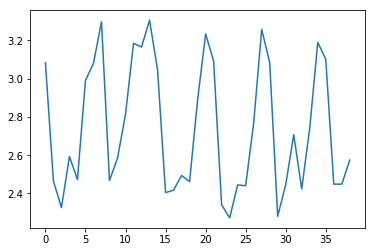

In [29]:
plt.plot(testpreds[129])

In [30]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [31]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.013714   
air_0164b9927d20bcc3_2017-04-23              1.344088   
air_0241aa3964b7f861_2017-04-23              2.541709   
air_0328696196e46f18_2017-04-23              2.067618   
air_034a3d5b40d5b1b1_2017-04-23              3.392858   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   6.491087  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.834689  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  11.701363  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.905968  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  28.750868

In [32]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [33]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [34]:
submission.to_csv("../submission/3003nb_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')